## 1. Libraries

Below are the libraries used for our EDA, Preprocessing, and Model Training

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import PowerTransformer, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from typing import Dict, List, Optional, Tuple
from scipy import stats
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import PolynomialFeatures
import itertools
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pandas as pd
import numpy as np
from typing import Tuple, List, Optional, Any

from scipy.stats import pointbiserialr


import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import ParameterGrid, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate

import numpy as np
import pandas as pd
from itertools import product
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

## 2. Data Loading

In [4]:
# Primary Data
df_company = pd.read_csv("./data/company_info.csv")
df_index = pd.read_csv("./data/monashIndex.csv")
df_stock = pd.read_csv("./data/stock_data.csv")
df_test_target = pd.read_csv("./data/testing_targets.csv")
df_train_target = pd.read_csv("./data/training_targets.csv")

# Optional Data
df_fed_fund = pd.read_csv("./data/optional_data/fed_funds_rate.csv")
df_fed_inflation = pd.read_csv("./data/optional_data/fed_inflation_rate.csv")
df_unemployment = pd.read_csv("./data/optional_data/fed_unemployment_rate.csv")
df_5y_treasury = pd.read_csv("./data/optional_data/us_5_year_treasury.csv")
df_10y_treasury = pd.read_csv("./data/optional_data/us_10_year_treasury.csv")
df_vix = pd.read_csv("./data/optional_data/vix_index.csv")

## 3. Preliminary EDA

Before we start with the preprocessing, we shall first perform some EDA on our datasets to understand the nature, format, distribution, and structure of each feature within our datasets to inform our preprocessing steps and modelling.

### 3.1 Data Structure Check

Under this section, we shall discover feature input format, missing values, outliers, and categories within each categorical features.

#### Train Target

In [5]:
df_train_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25618 entries, 0 to 25617
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   month_id           25618 non-null  object 
 1   stock_id           25618 non-null  object 
 2   outperform_binary  25618 non-null  int64  
 3   excess_return      25618 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 800.7+ KB


In [6]:
df_train_target.head()

,month_id,stock_id,outperform_binary,excess_return
0,2020_01,US001,0,-0.100593
1,2020_02,US001,0,-0.005920
2,2020_03,US001,1,0.013384
3,2020_04,US001,1,0.009597
4,2020_05,US001,0,-0.013023


In [7]:
df_train_target.describe()

,outperform_binary,excess_return
count,25618.000000,25618.000000
mean,0.490124,0.004170
std,0.499912,0.109273
min,0.000000,-0.724624
25%,0.000000,-0.049809
50%,0.000000,-0.001987
75%,1.000000,0.050377
max,1.000000,3.115830


**NOTE**

There is no missing value.

The average outperform_binary is around 0.5, so the distribution of overperformers and underperformers is almost even. In regard to excess_return, the average excess return is almost 0. There are potential outliers for excess_return since the std is only 0.11, but the max value is 3.11 for example.

Next, we shall discover the range of the month in this dataset. To help with this task, we shall convert "month_id" to datetime object for ease of sorting.

In [8]:
df_train_target["month_id"] = pd.to_datetime(df_train_target["month_id"], format="%Y_%m")

In [9]:
df_train_target.sort_values(by=["stock_id", "month_id"], ascending=[True, True]).head()

,month_id,stock_id,outperform_binary,excess_return
0,2020-01-01,US001,0,-0.100593
1,2020-02-01,US001,0,-0.005920
2,2020-03-01,US001,1,0.013384
3,2020-04-01,US001,1,0.009597
4,2020-05-01,US001,0,-0.013023


In [10]:
df_train_target.sort_values(by=["stock_id", "month_id"], ascending=[True, True]).tail()

,month_id,stock_id,outperform_binary,excess_return
25613,2023-02-01,US650,1,0.019193
25614,2023-03-01,US650,0,-0.142214
25615,2023-04-01,US650,0,-0.069182
25616,2023-05-01,US650,0,-0.055501
25617,2023-06-01,US650,0,-0.039958


**NOTE**

As can be seen above, the earliest month is 2020_01, and the oldest month is 2023_06 which is consistent with the dataset description. We shall convert month_id back to string format for ease of joining and data consistency check.

In [11]:
df_train_target["month_id"] = df_train_target["month_id"].dt.strftime("%Y_%m")

#### Company

In [12]:
df_company.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616 entries, 0 to 615
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   stock_id               616 non-null    object
 1   sector                 616 non-null    object
 2   business_model         616 non-null    object
 3   geographic_focus       616 non-null    object
 4   business_maturity      616 non-null    object
 5   competitive_position   616 non-null    object
 6   market_cap_category    616 non-null    object
 7   revenue_tier           616 non-null    object
 8   profitability_profile  616 non-null    object
 9   asset_intensity        616 non-null    object
 10  financial_strength     616 non-null    object
dtypes: object(11)
memory usage: 53.1+ KB


In [13]:
df_company.head()

,stock_id,sector,business_model,geographic_focus,business_maturity,competitive_position,market_cap_category,revenue_tier,profitability_profile,asset_intensity,financial_strength
0,US001,Industrials,B2B,Domestic,Mature,Market_Leader,Large,Tier_1,Standard,Moderate,Stable
1,US002,Industrials,B2B,Global,Growth,Strong_Player,Mid,Tier_2,Standard,Capital_Intensive,Stable
2,US003,Healthcare,B2C,Global,Mature,Market_Leader,Large,Tier_1,High_Margin,Moderate,Stable
3,US004,Healthcare,B2B,Global,Mature,Market_Leader,Large,Tier_1,High_Margin,Asset_Light,Strong
4,US005,Technology,B2B,Global,Mature,Market_Leader,Large,Tier_1,High_Margin,Moderate,Strong


In [14]:
df_company.describe()

,stock_id,sector,business_model,geographic_focus,business_maturity,competitive_position,market_cap_category,revenue_tier,profitability_profile,asset_intensity,financial_strength
count,616,616,616,616,616,616,616,616,616,616,616
unique,616,12,3,3,3,3,3,3,3,3,3
top,US001,Technology,B2C,Global,Mature,Strong_Player,Mid,Tier_2,Standard,Moderate,Stable
freq,1,100,294,285,316,362,374,374,329,300,265


In [15]:
# Loop through categorical columns to identify unique categories, excluding "stock_id"
for col in df_company.select_dtypes(include='object').columns.drop("stock_id"):
    print(f"Column: {col}")
    print(df_company[col].unique())
    print("-" * 50)

Column: sector
['Industrials' 'Healthcare' 'Technology' 'Utilities' 'Finance' 'Materials'
 'Consumer_Discretionary' 'Real_Estate' 'Communication' 'Consumer_Staples'
 'Energy' 'Other']
--------------------------------------------------
Column: business_model
['B2B' 'B2C' 'Platform']
--------------------------------------------------
Column: geographic_focus
['Domestic' 'Global' 'International']
--------------------------------------------------
Column: business_maturity
['Mature' 'Growth' 'Cyclical']
--------------------------------------------------
Column: competitive_position
['Market_Leader' 'Strong_Player' 'Niche_Specialist']
--------------------------------------------------
Column: market_cap_category
['Large' 'Mid' 'Small']
--------------------------------------------------
Column: revenue_tier
['Tier_1' 'Tier_2' 'Tier_3']
--------------------------------------------------
Column: profitability_profile
['Standard' 'High_Margin' 'Low_Margin']
-------------------------------------

**NOTE**

There is moderate cardinality in each of the category features.

#### Monash Index

In [16]:
df_index.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   month_id      42 non-null     object 
 1   index_return  42 non-null     float64
 2   index_value   42 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.1+ KB


In [17]:
df_index.head()

,month_id,index_return,index_value
0,2020_01,-0.006452,99.354842
1,2020_02,-0.053054,94.083684
2,2020_03,-0.111379,83.604709
3,2020_04,0.141313,95.419099
4,2020_05,0.071232,102.215965


In [18]:
df_index.describe()

,index_return,index_value
count,42.000000,42.000000
mean,0.008310,123.246575
std,0.045607,13.860218
min,-0.111379,83.604709
25%,-0.012409,118.909434
50%,0.005108,127.605003
75%,0.032112,133.667397
max,0.141313,139.438989


**NOTE**

Average index_return is small, but positive, indicating positive growth trend over time. There seem to be some periods with abnormally high and low returns in the stock index which is possible since index return is very volatile at times.

#### Stock

In [19]:
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25618 entries, 0 to 25617
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   stock_id               25618 non-null  object 
 1   month_id               25618 non-null  object 
 2   month_start_open_usd   25618 non-null  float64
 3   month_end_close_usd    25618 non-null  float64
 4   month_high_usd         25618 non-null  float64
 5   month_low_usd          25618 non-null  float64
 6   monthly_volume         25618 non-null  int64  
 7   intramonth_return      25618 non-null  float64
 8   return_1m              25597 non-null  float64
 9   return_3m              25555 non-null  float64
 10  return_6m              25483 non-null  float64
 11  intramonth_volatility  25616 non-null  float64
 12  volatility_3m          25555 non-null  float64
 13  volatility_6m          25483 non-null  float64
 14  trading_days           25618 non-null  int64  
 15  av

**NOTE**

Based on the output above, we can see that some columns contain missing values. We shall explore them further at a later stage.

In [20]:
df_stock.head()

,stock_id,month_id,month_start_open_usd,month_end_close_usd,month_high_usd,month_low_usd,monthly_volume,intramonth_return,return_1m,return_3m,return_6m,intramonth_volatility,volatility_3m,volatility_6m,trading_days,avg_volume_3m,volume_ratio,price_range_ratio
0,US001,2020_01,120.192,107.326,123.486,107.035,84539259,-0.107045,-0.100669,-0.030041,-0.075676,0.253304,0.278396,0.201608,21,3182487.0,1.207,0.136875
1,US001,2020_02,108.252,101.868,111.641,99.636,91313882,-0.058974,-0.050854,-0.112968,-0.060752,0.259208,0.245523,0.192782,19,3686371.0,1.126,0.110905
2,US001,2020_03,103.301,93.178,105.622,77.841,177930833,-0.097995,-0.085299,-0.219214,-0.154874,0.892709,0.088364,0.213051,22,5360363.0,1.509,0.268931
3,US001,2020_04,90.100,103.697,111.314,89.424,98448862,0.150910,0.112885,-0.033810,-0.062835,0.408352,0.366808,0.291241,21,5571115.0,0.803,0.242954
4,US001,2020_05,101.909,107.841,110.206,89.499,103380207,0.058209,0.039966,0.058641,-0.060951,0.419368,0.347233,0.292040,20,5753938.0,0.817,0.203186


In [21]:
df_stock.describe()

,month_start_open_usd,month_end_close_usd,month_high_usd,month_low_usd,monthly_volume,intramonth_return,return_1m,return_3m,return_6m,intramonth_volatility,volatility_3m,volatility_6m,trading_days,avg_volume_3m,volume_ratio,price_range_ratio
count,25618.000000,25618.000000,25618.000000,25618.000000,2.561800e+04,25618.000000,25597.000000,25555.000000,25483.000000,25616.000000,25555.000000,25483.000000,25618.000000,2.557600e+04,25576.000000,25618.000000
mean,133.718601,134.509803,144.473964,123.620124,1.247736e+08,0.012421,0.014740,0.042243,0.093739,0.384489,0.337133,0.356375,20.944414,5.641095e+06,1.005413,0.175590
std,245.900862,248.289855,263.700953,229.767331,4.721806e+08,0.126536,0.125580,0.224537,0.397024,0.253038,0.280432,0.240778,1.194822,2.094349e+07,0.209451,0.126633
min,0.700000,0.710000,0.997000,0.463000,1.500000e+03,-0.836003,-0.832263,-0.891459,-0.878101,0.037019,0.001361,0.020767,0.000000,1.440000e+02,0.046000,0.010922
25%,40.769500,40.839000,44.319250,37.065500,2.026318e+07,-0.054867,-0.053000,-0.073179,-0.093493,0.230496,0.174882,0.220319,20.000000,9.438960e+05,0.870000,0.101960
50%,78.925000,79.129000,85.501500,72.607500,4.413910e+07,0.006757,0.010027,0.026508,0.054570,0.312991,0.276629,0.300236,21.000000,2.040366e+06,0.984000,0.142549
75%,156.383750,157.484000,168.718750,144.102500,1.046730e+08,0.070576,0.073907,0.137254,0.220102,0.450122,0.420836,0.420214,22.000000,4.773016e+06,1.111000,0.207368
max,5870.000000,6350.620000,6386.620000,5528.090000,1.585655e+10,3.257143,3.197183,6.892996,19.942211,3.458247,7.123194,4.904750,23.000000,6.000172e+08,2.602000,3.457143


**NOTE**

There are some missing values for some of the features.

There is no unexpected value range for all of the numerical features since

#### Test Target

In [22]:
df_test_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616 entries, 0 to 615
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   month_id           616 non-null    object 
 1   stock_id           616 non-null    object 
 2   outperform_binary  0 non-null      float64
 3   excess_return      0 non-null      float64
dtypes: float64(2), object(2)
memory usage: 19.4+ KB


In [23]:
df_test_target.columns

Index(['month_id', 'stock_id', 'outperform_binary', 'excess_return'], dtype='object')

In [24]:
df_test_target.head()

,month_id,stock_id,outperform_binary,excess_return
0,2023_07,US001,NaN,NaN
1,2023_07,US002,NaN,NaN
2,2023_07,US003,NaN,NaN
3,2023_07,US004,NaN,NaN
4,2023_07,US005,NaN,NaN


**NOTE**

Missing values are expected in this dataset.

#### Fed Fund Rate

In [25]:
df_fed_fund.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   month_id  42 non-null     object 
 1   fed_rate  42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 804.0+ bytes


In [26]:
df_fed_fund.head()

,month_id,fed_rate
0,2020_01,1.55
1,2020_02,1.58
2,2020_03,0.65
3,2020_04,0.05
4,2020_05,0.05


In [27]:
df_fed_fund.describe()

,fed_rate
count,42.000000
mean,1.290238
std,1.774803
min,0.050000
25%,0.080000
50%,0.095000
75%,2.167500
max,5.080000


**NOTE**

There were periods with high fed fund rates that highly deviate from the norm which is not abnormal because the rate was raised within the period of this dataset to combat high inflation after Covid-19.

https://www.theguardian.com/business/2023/jul/26/fed-raises-interest-rates

#### Fed Inflation Rate

In [28]:
df_fed_inflation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   month_id        42 non-null     object 
 1   inflation_rate  42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 804.0+ bytes


In [29]:
df_fed_inflation.head()

,month_id,inflation_rate
0,2020_01,2.599768
1,2020_02,2.341317
2,2020_03,1.494040
3,2020_04,0.313047
4,2020_05,0.198201


In [30]:
df_fed_inflation.describe()

,inflation_rate
count,42.000000
mean,4.678918
std,2.840861
min,0.198201
25%,1.537406
50%,5.064135
75%,7.152438
max,8.999298


**NOTE**

The changes of the inflation rate seem to have been dramatic within the observation periods due to Covid-19 similar as the reason behind the large fed_rate increase from earlier.

#### Fed Unemployment Rate

In [31]:
df_unemployment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   month_id           42 non-null     object 
 1   unemployment_rate  42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 804.0+ bytes


In [32]:
df_unemployment.head()

,month_id,unemployment_rate
0,2020_01,3.6
1,2020_02,3.5
2,2020_03,4.4
3,2020_04,14.8
4,2020_05,13.2


In [33]:
df_unemployment.describe()

,unemployment_rate
count,42.000000
mean,5.390476
std,2.696955
min,3.400000
25%,3.600000
50%,4.100000
75%,6.175000
max,14.800000


**NOTE**

Unemployment rate was unusually high at 14 possibly due to Covid-19.

#### 5Y Treasury

In [34]:
df_5y_treasury.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   month_id     42 non-null     object 
 1   5y_treasury  42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 804.0+ bytes


In [35]:
df_5y_treasury.head()

,month_id,5y_treasury
0,2020_01,1.33
1,2020_02,0.91
2,2020_03,0.38
3,2020_04,0.34
4,2020_05,0.30


In [36]:
df_5y_treasury.describe()

,5y_treasury
count,42.000000
mean,1.798810
std,1.440586
min,0.220000
25%,0.505000
50%,1.170000
75%,3.210000
max,4.250000


**NOTE**

No unexpected value range.

#### 10Y Treasury

In [37]:
df_10y_treasury.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   month_id      42 non-null     object 
 1   10y_treasury  42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 804.0+ bytes


In [38]:
df_10y_treasury.head()

,month_id,10y_treasury
0,2020_01,1.52
1,2020_02,1.13
2,2020_03,0.70
3,2020_04,0.62
4,2020_05,0.65


In [39]:
df_10y_treasury.describe()

,10y_treasury
count,42.000000
mean,2.025952
std,1.170843
min,0.540000
25%,1.100000
50%,1.570000
75%,3.090000
max,4.080000


**NOTE**

No unexpected value range

#### VIX Index

In [40]:
df_vix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   month_id  42 non-null     object 
 1   vix       42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 804.0+ bytes


In [41]:
df_vix.head()

,month_id,vix
0,2020_01,13.94
1,2020_02,19.63
2,2020_03,57.74
3,2020_04,41.45
4,2020_05,30.90


In [42]:
df_vix.describe()

,vix
count,42.000000
mean,23.916429
std,7.555018
min,13.940000
25%,19.662500
50%,22.630000
75%,26.937500
max,57.740000


**NOTE**

Volatility index range is within expectation,

### 3.2 Data Consistency Check

In this part, we shall check whether the observations within the most important datasets match with each other.

In [43]:
# Check stock_id consistency training set
print(set(df_train_target["stock_id"]) - set(df_company["stock_id"]))

# Check stock_id consistency testing set
print(set(df_test_target["stock_id"]) - set(df_company["stock_id"]))

# Check month_id alignment
print(set(df_train_target["month_id"]) - set(df_index["month_id"]))
print(set(df_train_target["month_id"]) - set(df_stock["month_id"]))

set()
set()
set()
set()


**NOTE**

The dataset observations are aligned with no missing matching month_id or stock_id

### 3.2 Imbalance and Outlier Check

In this section, we shall visualize the distribution of the features to identify any outlier or need for transformation.

#### 3.2.1 Target Variable Distribution

##### Q1: Is the dataset balanced between outperformers and underperformers?

Important because class imbalance can bias classification models toward the majority class.

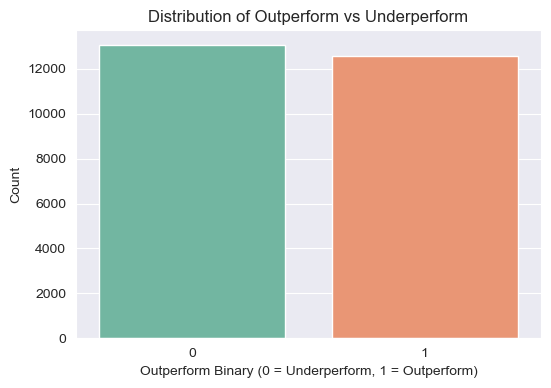

In [44]:
# Distribution of target variable (outperform_binary)
plt.figure(figsize=(6,4))
sns.countplot(x="outperform_binary", data=df_train_target, palette="Set2", hue ="outperform_binary", legend = False)
plt.title("Distribution of Outperform vs Underperform")
plt.xlabel("Outperform Binary (0 = Underperform, 1 = Outperform)")
plt.ylabel("Count")
plt.show()

**NOTE**

The binary target variable is balanced.

##### Q2: What is the distribution of excess_return?

Important to check skewness/heavy tails → may need log transform or robust models.

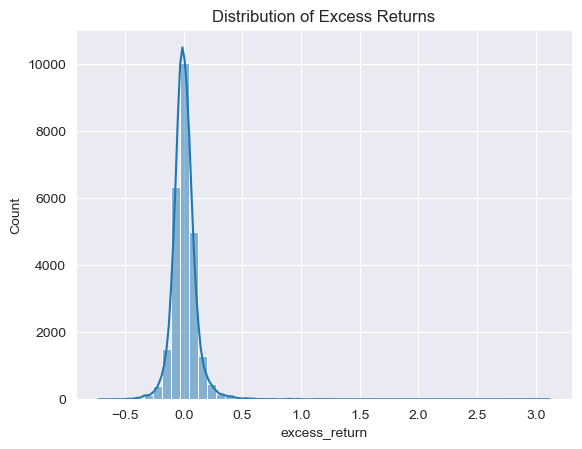

count    25618.000000
mean         0.004170
std          0.109273
min         -0.724624
25%         -0.049809
50%         -0.001987
75%          0.050377
max          3.115830
Name: excess_return, dtype: float64

In [45]:
sns.histplot(df_train_target["excess_return"], bins=50, kde=True)
plt.title("Distribution of Excess Returns")
plt.show()

df_train_target["excess_return"].describe()

**NOTE**

The distribution is right skewed which is expected for stock return, so there might be a need to transform excess_return to be more normally distributed for some models such as linear regression to maintain the residual normality assumption.

There are potential outliers to be considered. Most of the excess_return range between -0.5 and 0.5. Observations that lie outside of this range is few with some excess_return going up to 3.0.



#### 3.2.2 Predictor Distribution

##### Joining Numerical Dataset

To help with this step, we shall join all of the numerical features together in one dataframe.

In [46]:
def _prepare_macro(df: pd.DataFrame, name: str, keep_cols: Optional[List[str]] = None, prefix: bool = True) -> pd.DataFrame:
    """
    Keep 'month_id' + selected columns; optionally prefix columns with '{name}_'.
    """
    if keep_cols is None:
        keep_cols = [c for c in df.columns if c != "month_id"]
    missing = [c for c in keep_cols if c not in df.columns]
    if missing:
        raise ValueError(f"[{name}] keep_cols not found: {missing}. Available: {df.columns.tolist()}")
    out = df[["month_id"] + keep_cols].copy()
    if prefix:
        out = out.rename(columns={c: f"{name}_{c}" for c in keep_cols})
    return out

def merge_on_month(
    df_left: pd.DataFrame,
    macro_sources: Dict[str, pd.DataFrame],
    keep_map: Optional[Dict[str, List[str]]] = None,
    prefix: bool = True
) -> pd.DataFrame:
    """
    Left-merge df_stock_1_t with multiple macro/index dataframes on:
        df_stock_1_t.lag_month_id == macro.month_id

    If prefix=False, macro columns keep their original names.
    """
    out = df_left.copy()

    for name, mdf in macro_sources.items():
        keep_cols = None if keep_map is None else keep_map.get(name, None)
        right = _prepare_macro(mdf, name=name, keep_cols=keep_cols, prefix=prefix)

        out = out.merge(
            right,
            left_on="month_id",
            right_on="month_id",
            how="left"
        )

    return out

In [47]:
# Build the dict of sources (pick only columns you need to reduce noise)
macro_sources = {
    "index": df_index,                 # expect cols: month_id, index_return, index_value
    "fed": df_fed_fund,                # month_id, fed_funds_rate
    "cpi": df_fed_inflation,           # month_id, fed_inflation_rate
    "unemp": df_unemployment,          # month_id, fed_unemployment_rate (or similar)
    "t5y": df_5y_treasury,             # month_id, us_5_year_treasury
    "t10y": df_10y_treasury,           # month_id, us_10_year_treasury
    "vix": df_vix,                     # month_id, vix_index
}

df_num = merge_on_month(df_stock, macro_sources, prefix=False)

In [48]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25618 entries, 0 to 25617
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   stock_id               25618 non-null  object 
 1   month_id               25618 non-null  object 
 2   month_start_open_usd   25618 non-null  float64
 3   month_end_close_usd    25618 non-null  float64
 4   month_high_usd         25618 non-null  float64
 5   month_low_usd          25618 non-null  float64
 6   monthly_volume         25618 non-null  int64  
 7   intramonth_return      25618 non-null  float64
 8   return_1m              25597 non-null  float64
 9   return_3m              25555 non-null  float64
 10  return_6m              25483 non-null  float64
 11  intramonth_volatility  25616 non-null  float64
 12  volatility_3m          25555 non-null  float64
 13  volatility_6m          25483 non-null  float64
 14  trading_days           25618 non-null  int64  
 15  av

In [49]:
df_num.head()

,stock_id,month_id,month_start_open_usd,month_end_close_usd,month_high_usd,month_low_usd,monthly_volume,intramonth_return,return_1m,return_3m,...,volume_ratio,price_range_ratio,index_return,index_value,fed_rate,inflation_rate,unemployment_rate,5y_treasury,10y_treasury,vix
0,US001,2020_01,120.192,107.326,123.486,107.035,84539259,-0.107045,-0.100669,-0.030041,...,1.207,0.136875,-0.006452,99.354842,1.55,2.599768,3.6,1.33,1.52,13.94
1,US001,2020_02,108.252,101.868,111.641,99.636,91313882,-0.058974,-0.050854,-0.112968,...,1.126,0.110905,-0.053054,94.083684,1.58,2.341317,3.5,0.91,1.13,19.63
2,US001,2020_03,103.301,93.178,105.622,77.841,177930833,-0.097995,-0.085299,-0.219214,...,1.509,0.268931,-0.111379,83.604709,0.65,1.494040,4.4,0.38,0.70,57.74
3,US001,2020_04,90.100,103.697,111.314,89.424,98448862,0.150910,0.112885,-0.033810,...,0.803,0.242954,0.141313,95.419099,0.05,0.313047,14.8,0.34,0.62,41.45
4,US001,2020_05,101.909,107.841,110.206,89.499,103380207,0.058209,0.039966,0.058641,...,0.817,0.203186,0.071232,102.215965,0.05,0.198201,13.2,0.30,0.65,30.90


##### Categorical Features

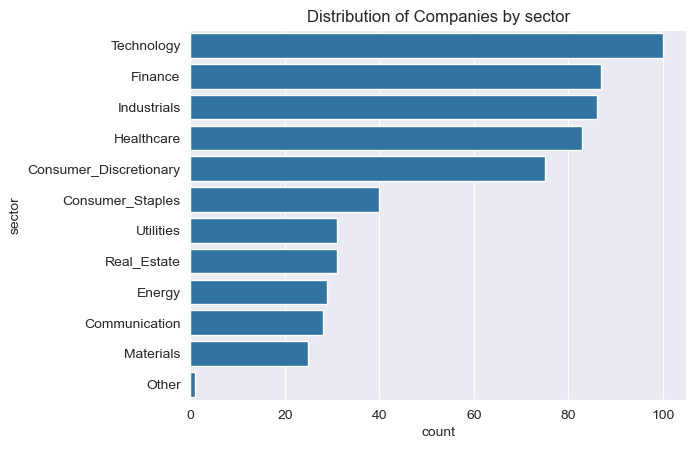

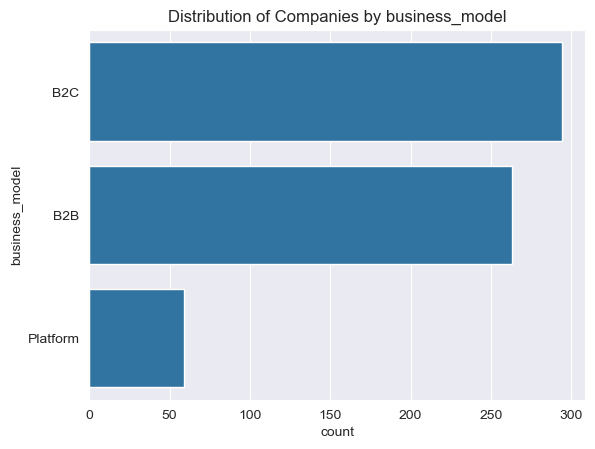

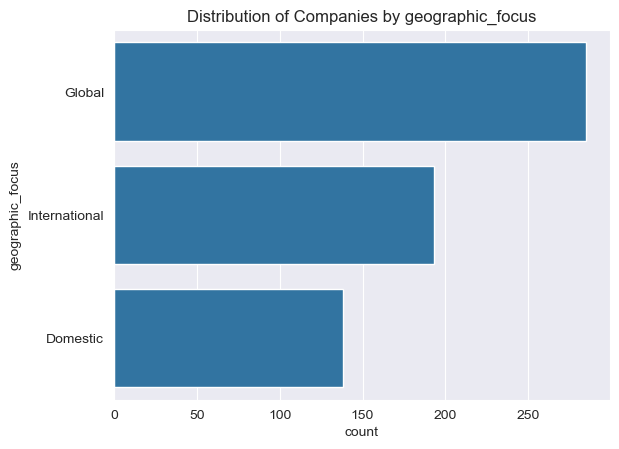

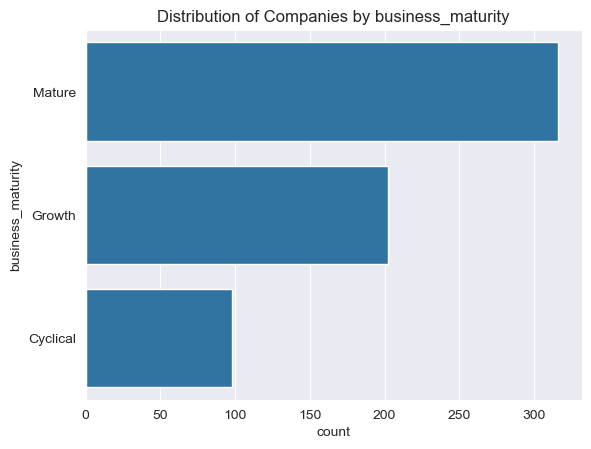

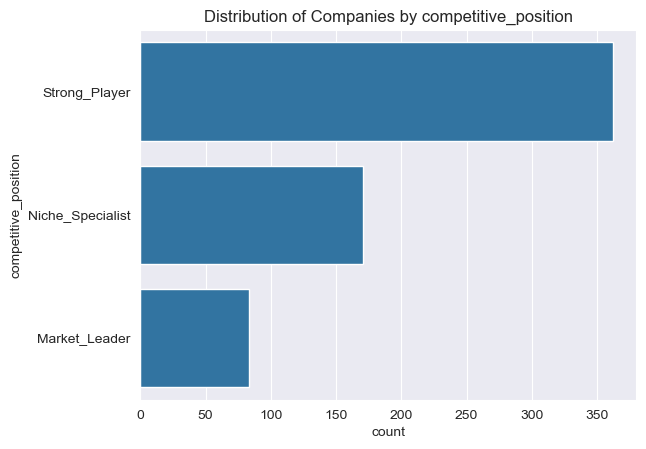

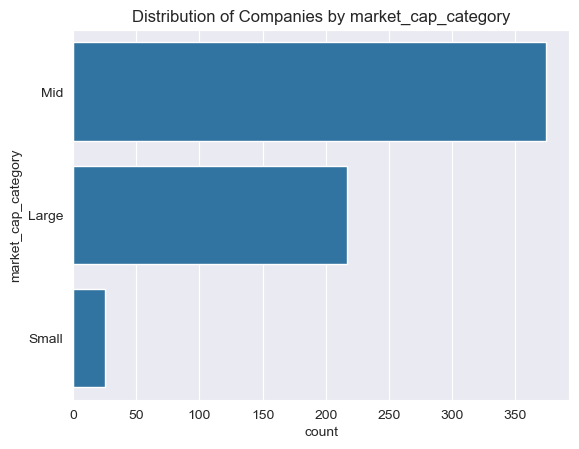

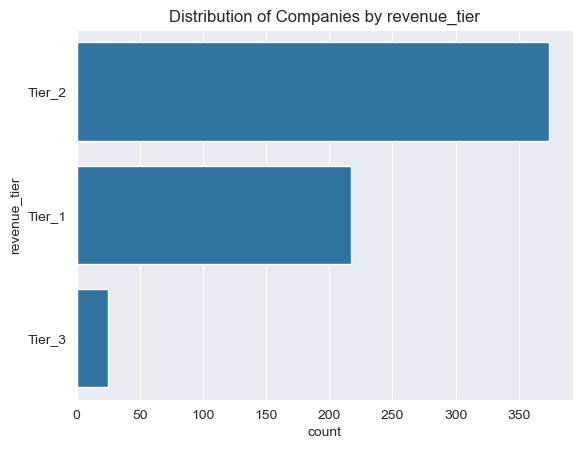

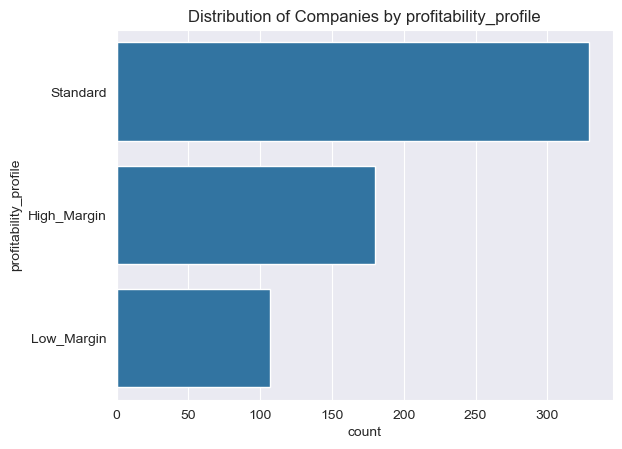

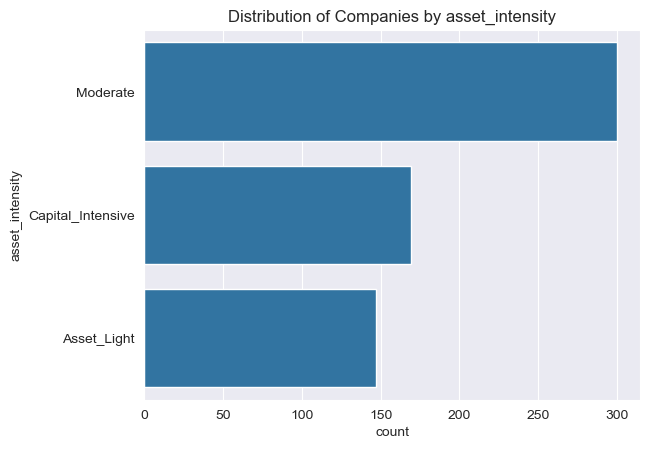

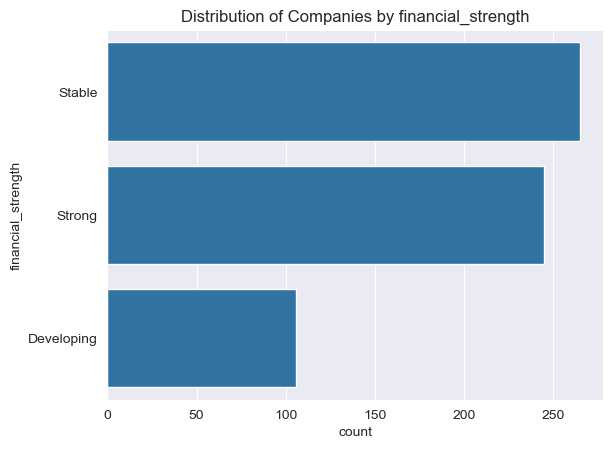

In [50]:
for col in df_company.columns:
    if df_company[col].dtype == "object" and col != "stock_id":
        sns.countplot(y=col, data=df_company, order=df_company[col].value_counts().index)
        plt.title(f"Distribution of Companies by {col}")
        plt.show()

**NOTE**

For df_company,

**Imbalance Across Sectors:** Technology is the largest sector which is not surprising since US markets are heavily weighted toward tech, while some sectors are relatively small

**Risk of Overfitting to Tech:** If most outperformers come from Tech, the model might rely too heavily on "sector = Tech" as a predictor.

**Poor Generalization for Small Sectors:** Predictors for smaller sectors may be less accurate.

**Validation Strategy:** During cross-validation, ensure all sectors are represented in each fold (avoid splits that leave out small sectors).

**Potential Extensions:** Consider grouped evaluation: report F1-scores by sector, not just overall, to show how balanced (or not) the model is.


Besides df_company, the distribution of most of the features' categories seem balanced enough, but for "Small" in market_cap_category, "Tier_3" in revenue_tier, and "Other" in sector, the numbers of their observations are relatively small compared to the rest of the categories in their corresponding features which can lead to imbalance issue, and thus weak prediction capacity for observations with those categories.

##### Numerical Features

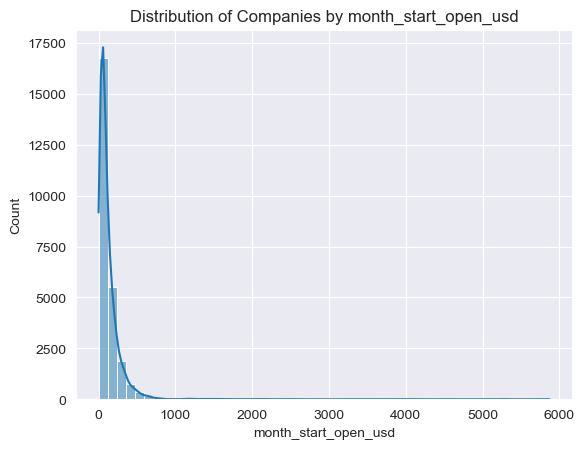

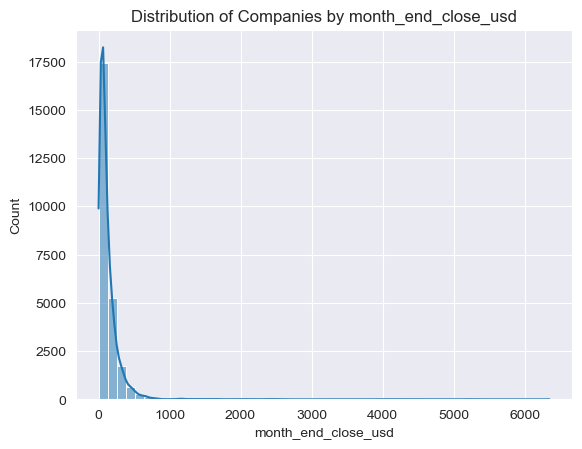

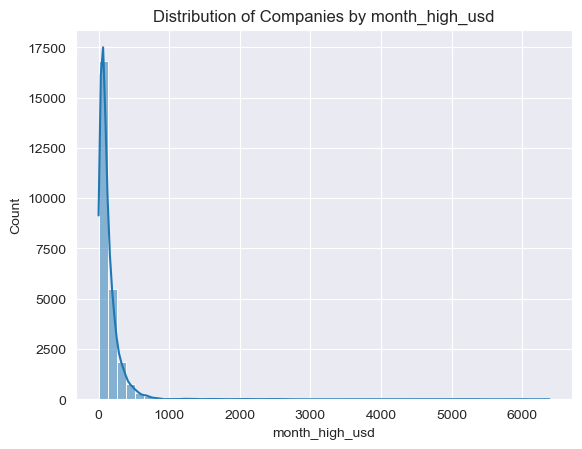

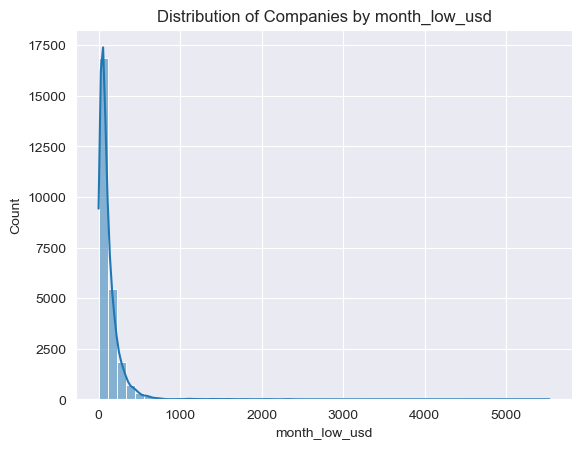

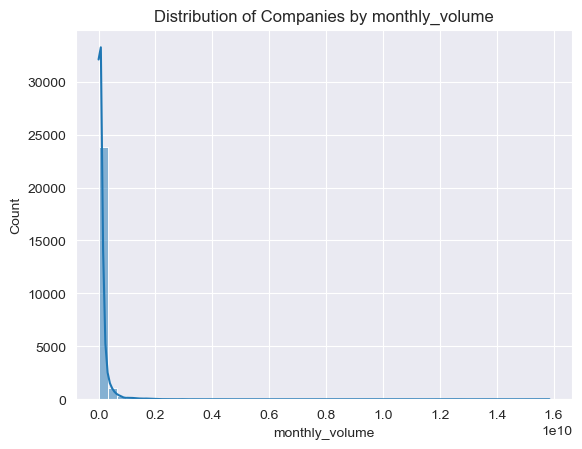

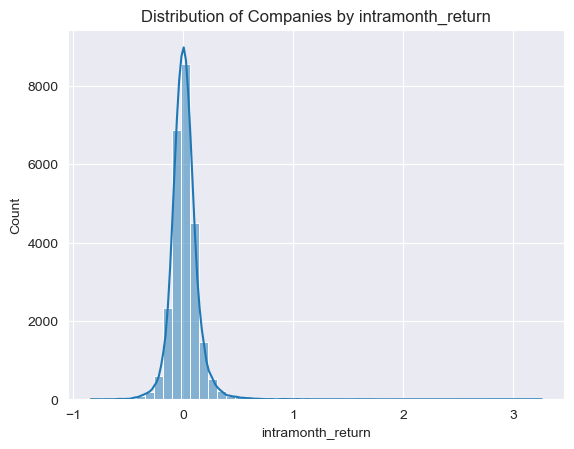

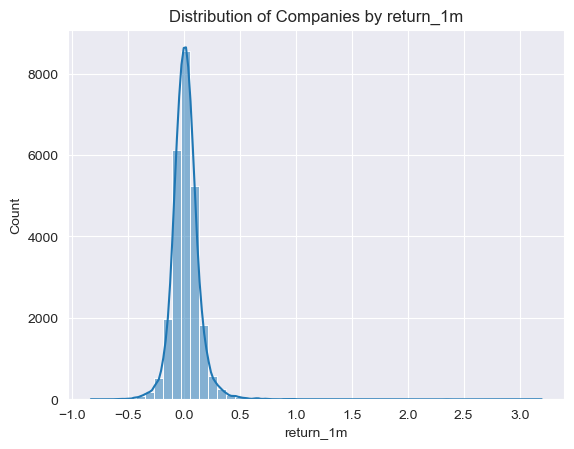

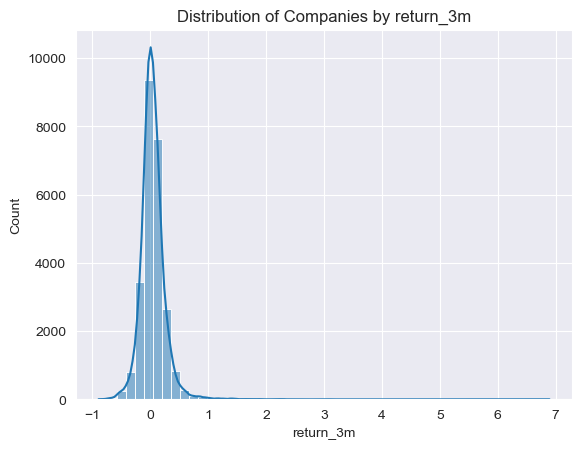

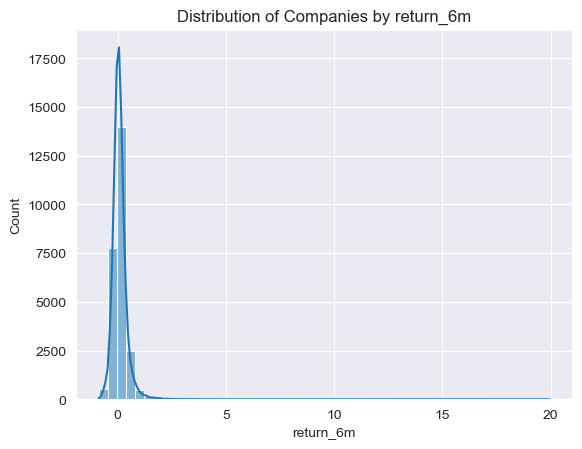

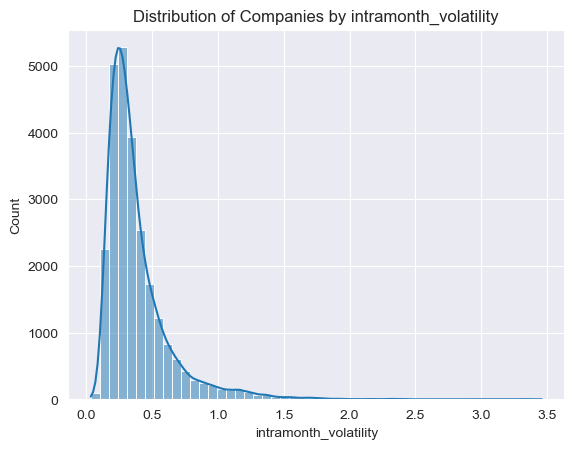

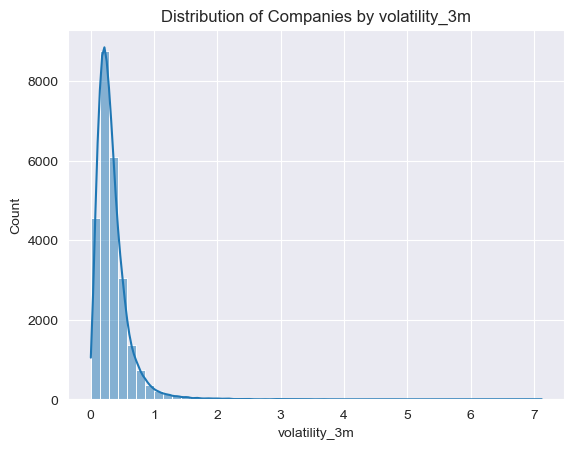

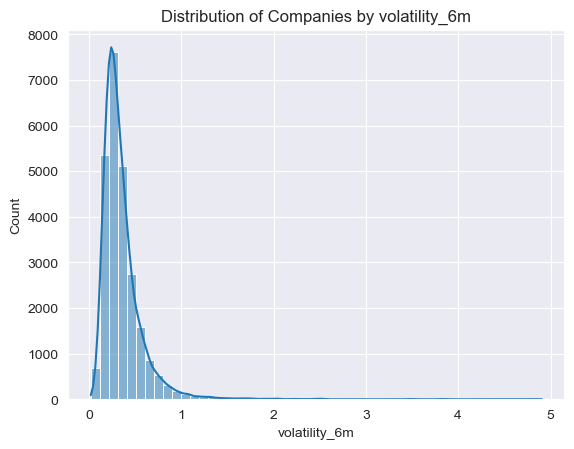

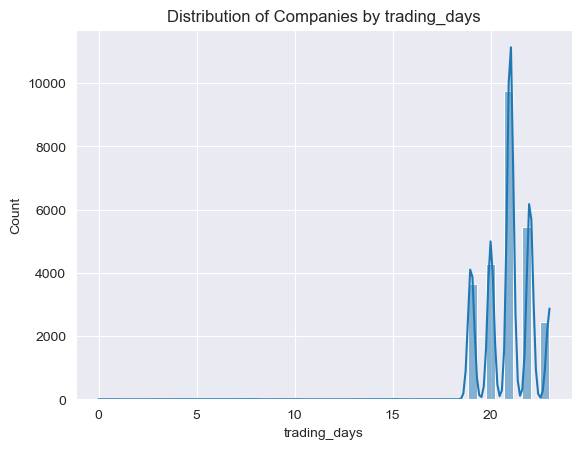

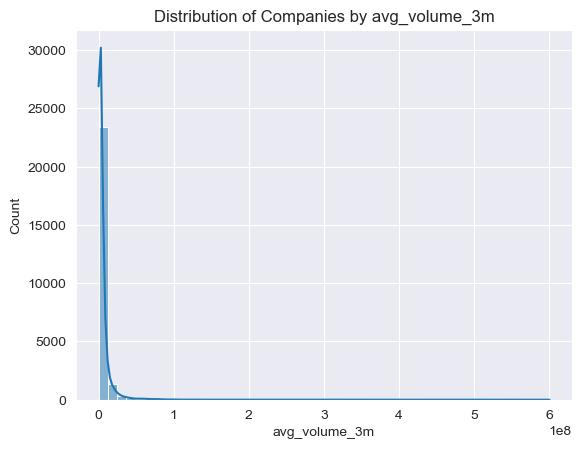

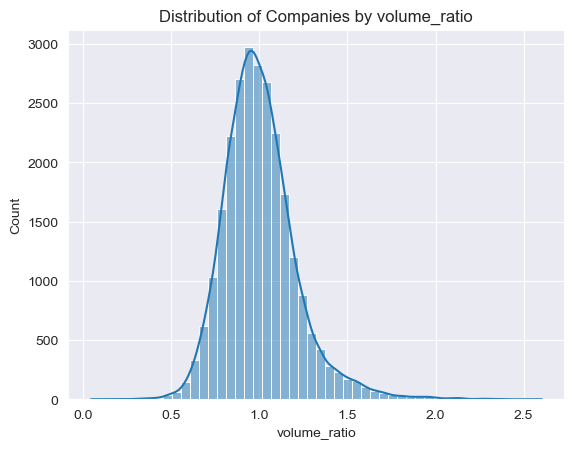

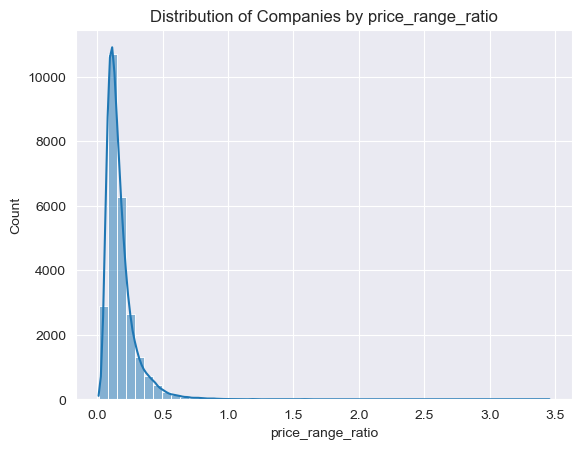

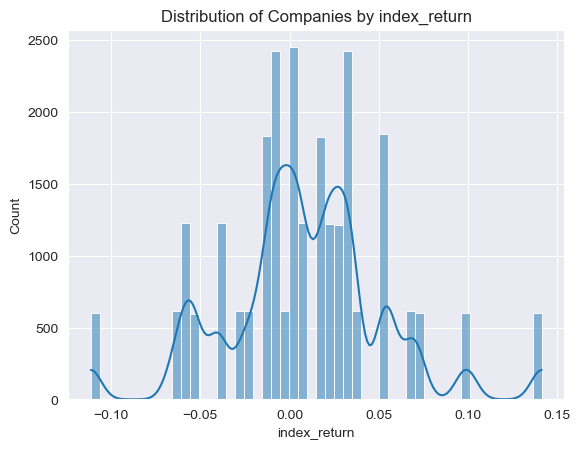

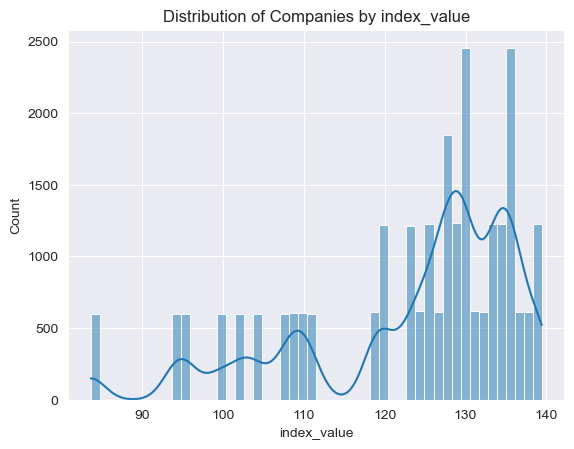

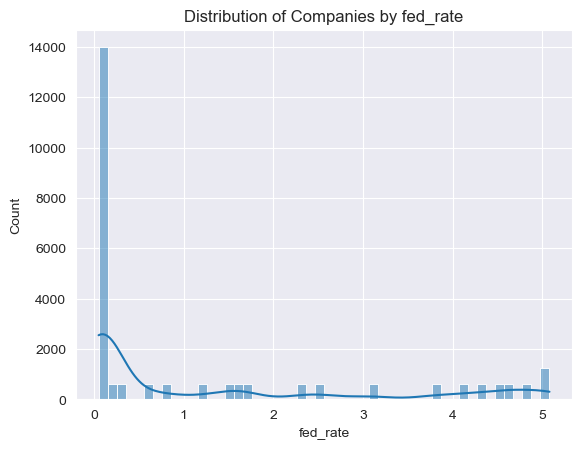

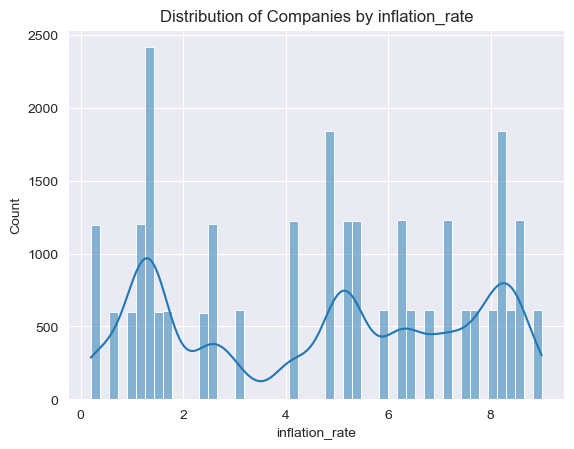

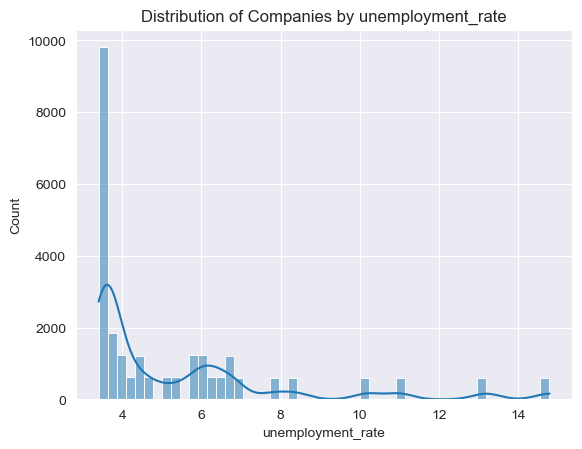

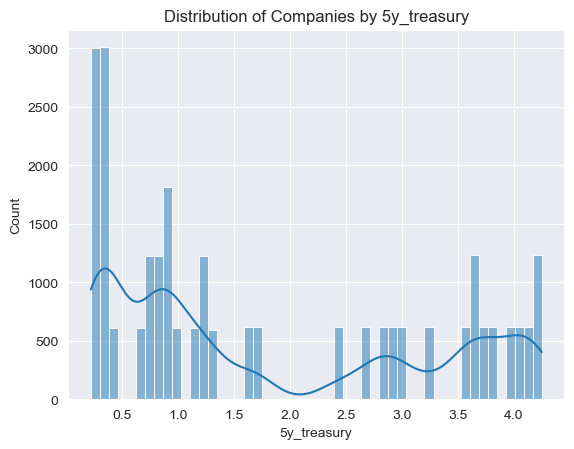

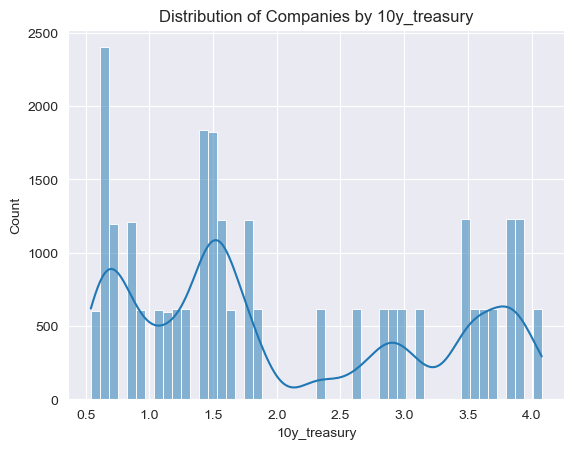

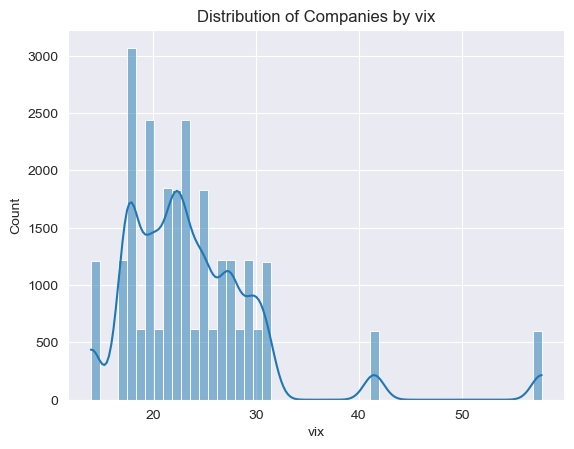

In [51]:
for col in df_num.columns:
    if col not in ["stock_id", "month_id"]:
        sns.histplot(df_num[col], bins=50, kde=True)
        plt.title(f"Distribution of Companies by {col}")
        plt.show()

**NOTE**

Most of the numerical features are highly skewed, so they will need transformation.

## 4. Data Pre-Processing and Feature Engineering

In this section, we shall perform some data preprocessing based on the insights from the preliminary process. In addition to that, we shall perform some feature engineering to further enhance the quality and predictive power of our features.

### 4.1 Missing Value Handling

From the previous EDA step, we saw that there were missing values in some of the features in the stock features. We shall explore these features in depth in this section.

In [52]:
# Count of missing values per column
missing_count = df_stock.isnull().sum()

# Proportion of missing values per column
missing_prop = df_stock.isnull().mean()

# Combine into one summary DataFrame
stock_missing_summary = pd.DataFrame({
    "missing_count": missing_count,
    "missing_proportion": missing_prop
})

stock_missing_summary

,missing_count,missing_proportion
stock_id,0,0.000000
month_id,0,0.000000
month_start_open_usd,0,0.000000
month_end_close_usd,0,0.000000
month_high_usd,0,0.000000
month_low_usd,0,0.000000
monthly_volume,0,0.000000
intramonth_return,0,0.000000
return_1m,21,0.000820
return_3m,63,0.002459


As can be seen above, the missing features are those that are related to to historical data such as return_1m and volatility_3m. Next, we shall investigate the features that contain rows with missing values in the feature. We shall start with "return_1m".

In [53]:
df_stock[df_stock["return_1m"].isna()].head()

,stock_id,month_id,month_start_open_usd,month_end_close_usd,month_high_usd,month_low_usd,monthly_volume,intramonth_return,return_1m,return_3m,return_6m,intramonth_volatility,volatility_3m,volatility_6m,trading_days,avg_volume_3m,volume_ratio,price_range_ratio
462,US012,2020_12,146.000,146.800,174.970,121.500,231751600,0.005479,NaN,NaN,NaN,0.789349,NaN,NaN,14,NaN,NaN,0.366233
3643,US088,2020_03,11.188,16.082,16.082,10.722,1370800,0.437433,NaN,NaN,NaN,1.430999,NaN,NaN,8,NaN,NaN,0.479167
4775,US115,2021_04,381.000,297.640,429.540,282.070,227757100,-0.218793,NaN,NaN,NaN,0.522406,NaN,NaN,12,NaN,NaN,0.387060
5054,US122,2022_01,36.828,46.520,48.410,36.828,1103300,0.263169,NaN,NaN,NaN,0.632513,NaN,NaN,8,NaN,NaN,0.314474
6332,US153,2020_12,182.000,142.750,195.500,135.380,92026800,-0.215659,NaN,NaN,NaN,0.628503,NaN,NaN,15,NaN,NaN,0.330330


Based on the above output, we can see that the rows with missing "return_1m" are stock observations whose number of trading days is less than a month. This can mean that the missing value for return_1m is because of the lack of previous month's closing stock price data as the stock only recently began trading. We can confirm this by checking whether these rows whose "return_1m" feature is missing are the earliest observation for that particular stock.

In [54]:
# Sort properly by year and month
df_stock = df_stock.sort_values(["stock_id","month_id"]).copy()

# First observation per stock
first_obs = df_stock.groupby("stock_id").head(1)[["stock_id","month_id"]]

# Rows with missing return_1m
missing_return1m = df_stock[df_stock["return_1m"].isna()][["stock_id","month_id"]]

# Check overlap
check = missing_return1m.merge(first_obs, on=["stock_id","month_id"], how="left", indicator=True)
print(check["_merge"].value_counts())

# Inspect some results
print(check)

_merge
both          21
left_only      0
right_only     0
Name: count, dtype: int64
   stock_id month_id _merge
0     US012  2020_12   both
1     US088  2020_03   both
2     US115  2021_04   both
3     US122  2022_01   both
4     US153  2020_12   both
5     US184  2021_02   both
6     US210  2022_12   both
7     US357  2020_03   both
8     US360  2020_09   both
9     US507  2020_09   both
10    US508  2021_03   both
11    US540  2021_01   both
12    US541  2021_07   both
13    US556  2021_01   both
14    US558  2020_12   both
15    US565  2020_02   both
16    US573  2020_06   both
17    US574  2020_04   both
18    US602  2021_05   both
19    US625  2022_01   both
20    US634  2020_10   both


Based on the result above, it confirms our hypothesis that these rows do not have "return_1m" input because they only recently began trading within the month of the earliest observation.

Next, we shall investigate the "return_3m" and "return_6m". For "return_3m" for example, our hypothesis is that it is missing because of the lack of "return_1m" data of the stock's first observation because "return_3m" would not be possible to be calculated this way. Its second and third observation's "return_1m" feature should not be missing in this case.

In [55]:
df_stock[df_stock["return_3m"].isna()].head(9)

,stock_id,month_id,month_start_open_usd,month_end_close_usd,month_high_usd,month_low_usd,monthly_volume,intramonth_return,return_1m,return_3m,return_6m,intramonth_volatility,volatility_3m,volatility_6m,trading_days,avg_volume_3m,volume_ratio,price_range_ratio
462,US012,2020_12,146.000,146.800,174.970,121.500,231751600,0.005479,NaN,NaN,NaN,0.789349,NaN,NaN,14,NaN,NaN,0.366233
463,US012,2021_01,150.990,183.630,216.000,137.000,142172900,0.216173,0.250886,NaN,NaN,0.921364,NaN,NaN,19,NaN,NaN,0.523213
464,US012,2021_02,187.480,206.350,219.940,175.000,98542100,0.100651,0.123727,NaN,NaN,0.783829,NaN,NaN,19,7158585.0,0.626,0.239706
3643,US088,2020_03,11.188,16.082,16.082,10.722,1370800,0.437433,NaN,NaN,NaN,1.430999,NaN,NaN,8,NaN,NaN,0.479167
3644,US088,2020_04,14.917,16.511,16.856,11.300,468019400,0.106858,0.026667,NaN,NaN,1.322662,NaN,NaN,21,NaN,NaN,0.372500
3645,US088,2020_05,16.157,19.084,19.560,14.385,220471800,0.181160,0.155844,NaN,NaN,0.682908,NaN,NaN,20,10452455.0,0.959,0.320254
4775,US115,2021_04,381.000,297.640,429.540,282.070,227757100,-0.218793,NaN,NaN,NaN,0.522406,NaN,NaN,12,NaN,NaN,0.387060
4776,US115,2021_05,304.000,236.540,306.980,208.000,164798200,-0.221908,-0.205282,NaN,NaN,0.776867,NaN,NaN,20,NaN,NaN,0.325592
4777,US115,2021_06,238.510,253.300,261.150,210.770,93093900,0.062010,0.070855,NaN,NaN,0.521156,NaN,NaN,22,7358321.0,0.575,0.211228


In [56]:
df_stock[df_stock["return_6m"].isna()].head(9)

,stock_id,month_id,month_start_open_usd,month_end_close_usd,month_high_usd,month_low_usd,monthly_volume,intramonth_return,return_1m,return_3m,return_6m,intramonth_volatility,volatility_3m,volatility_6m,trading_days,avg_volume_3m,volume_ratio,price_range_ratio
462,US012,2020_12,146.000,146.800,174.970,121.500,231751600,0.005479,NaN,NaN,NaN,0.789349,NaN,NaN,14,NaN,NaN,0.366233
463,US012,2021_01,150.990,183.630,216.000,137.000,142172900,0.216173,0.250886,NaN,NaN,0.921364,NaN,NaN,19,NaN,NaN,0.523213
464,US012,2021_02,187.480,206.350,219.940,175.000,98542100,0.100651,0.123727,NaN,NaN,0.783829,NaN,NaN,19,7158585.0,0.626,0.239706
465,US012,2021_03,195.820,187.940,215.490,161.900,134268900,-0.040241,-0.089217,0.280245,NaN,0.542879,0.595289,NaN,23,5681574.0,1.074,0.273670
466,US012,2021_04,192.500,172.710,194.480,164.120,69666400,-0.102805,-0.081036,-0.059467,NaN,0.309788,0.417948,NaN,21,4582991.0,0.691,0.157714
467,US012,2021_05,173.190,140.400,173.440,129.710,233049300,-0.189330,-0.187077,-0.319603,NaN,0.483224,0.204391,NaN,20,6620979.0,1.600,0.252497
3643,US088,2020_03,11.188,16.082,16.082,10.722,1370800,0.437433,NaN,NaN,NaN,1.430999,NaN,NaN,8,NaN,NaN,0.479167
3644,US088,2020_04,14.917,16.511,16.856,11.300,468019400,0.106858,0.026667,NaN,NaN,1.322662,NaN,NaN,21,NaN,NaN,0.372500
3645,US088,2020_05,16.157,19.084,19.560,14.385,220471800,0.181160,0.155844,NaN,NaN,0.682908,NaN,NaN,20,10452455.0,0.959,0.320254


As can be seen above, our hypothesis for rows whose "return_3m" and "return_6m" are correct. For "return_6m" of stock "US012" for example, it is only within the first 6 months that this data is missing because there is no first month data for inputting in the calculation.

Next, we investigate "volatility_3m" and "volatility_6m". We can see in the missing value summary that they share the same number of missing rows as "return_3m" and "return_6m" respectively, so the reason must be similar. We can verify it further below:

In [57]:
df_stock[df_stock["return_3m"].isna() & df_stock["volatility_3m"].isna()].shape[0]

63

In [58]:
df_stock[df_stock["return_6m"].isna() & df_stock["volatility_6m"].isna()].shape[0]

135

Their numbers match, so this confirms our hypothesis. We apply this same method with avg_volume_3m below.

In [59]:
df_stock[df_stock["return_3m"].isna() & df_stock["avg_volume_3m"].isna()].shape[0]

42

Since the total number of rows with missing avg_volume_3m is 42, and the number of rows with missing "return_3m" is 63, this means that when we drop rows with missing "return_3m", we shall also drop rows with missing "avg_volume_3m".

Lastly, we shall check rows with missing "intramonth_volatility".

In [60]:
df_stock[df_stock["intramonth_volatility"].isna()]

,stock_id,month_id,month_start_open_usd,month_end_close_usd,month_high_usd,month_low_usd,monthly_volume,intramonth_return,return_1m,return_3m,return_6m,intramonth_volatility,volatility_3m,volatility_6m,trading_days,avg_volume_3m,volume_ratio,price_range_ratio
14881,US360,2020_09,10.0,9.50,11.41,9.11,338584400,-0.050,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0.230000
22147,US541,2021_07,38.0,35.15,40.25,33.25,143106900,-0.075,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,0.184211


We can see that rows with missing "intramonth_volatility" also contains missing values in other columns such as volatility_3m.

Overall, the missing values stem from the lack of initial data such as "return_1m" which leads to other longer period aggregate feature such as "return_3m" and "return_6m" to be missing as well. Since these missing values are not missing at random, we cannot fill in the missing values without imputation methods such as mean or median. However, we do not introduce bias and since the number of total missing rows is small in proportion to the whole dataset, we can safely drop these rows. Furthermore, since the rows with missing "return_6m" also encompass the rows with other missing features as well, if we drop these rows, we shall handle the missing value entirely.

### 4.2 Data Transformation and Feature Engineering

#### 4.2.1 Data Encoding and Joining

##### df_company: Categorical Encoding, Collinearity Removed

In [61]:
# Loop through categorical columns to identify unique categories, excluding "stock_id"
for col in df_company.select_dtypes(include='object').columns.drop("stock_id"):
    print(f"Column: {col}")
    print(df_company[col].unique())
    print("-" * 50)

Column: sector
['Industrials' 'Healthcare' 'Technology' 'Utilities' 'Finance' 'Materials'
 'Consumer_Discretionary' 'Real_Estate' 'Communication' 'Consumer_Staples'
 'Energy' 'Other']
--------------------------------------------------
Column: business_model
['B2B' 'B2C' 'Platform']
--------------------------------------------------
Column: geographic_focus
['Domestic' 'Global' 'International']
--------------------------------------------------
Column: business_maturity
['Mature' 'Growth' 'Cyclical']
--------------------------------------------------
Column: competitive_position
['Market_Leader' 'Strong_Player' 'Niche_Specialist']
--------------------------------------------------
Column: market_cap_category
['Large' 'Mid' 'Small']
--------------------------------------------------
Column: revenue_tier
['Tier_1' 'Tier_2' 'Tier_3']
--------------------------------------------------
Column: profitability_profile
['Standard' 'High_Margin' 'Low_Margin']
-------------------------------------

In [62]:
# --- Cramér’s V function ---
def cramers_v(x, y):
    confusion = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion)[0]
    n = confusion.sum().sum()
    phi2 = chi2 / n
    r, k = confusion.shape
    phi2corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
    rcorr = r - (r-1)**2/(n-1)
    kcorr = k - (k-1)**2/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# --- Select only categorical columns (ignore stock_id) ---
cat_cols = [c for c in df_company.columns if c != "stock_id"]

# --- Compute pairwise Cramér’s V ---
results = []
for col1, col2 in itertools.combinations(cat_cols, 2):
    v = cramers_v(df_company[col1], df_company[col2])
    results.append({"Feature1": col1, "Feature2": col2, "CramersV": v})

df_cramers = pd.DataFrame(results).sort_values("CramersV", ascending=False)

# Show top associations
print(df_cramers.head(15))

                 Feature1               Feature2  CramersV
35    market_cap_category           revenue_tier  1.000000
0                  sector         business_model  0.669655
7                  sector        asset_intensity  0.462626
6                  sector  profitability_profile  0.384911
2                  sector      business_maturity  0.309570
23       geographic_focus     financial_strength  0.266918
38    market_cap_category     financial_strength  0.265826
41           revenue_tier     financial_strength  0.265826
20       geographic_focus           revenue_tier  0.249726
19       geographic_focus    market_cap_category  0.249726
15         business_model        asset_intensity  0.197150
5                  sector           revenue_tier  0.192581
4                  sector    market_cap_category  0.192581
14         business_model  profitability_profile  0.187023
42  profitability_profile        asset_intensity  0.168064


In [63]:
df_company_1 = df_company.drop(columns=["revenue_tier"])

**NOTE**

Cramér’s V ≈ 0.8–1.0 → Almost redundant (likely encode only one).

Cramér’s V ≈ 0.5–0.8 → Strong association (may cause collinearity, handle carefully).

Cramér’s V < 0.5 → Moderate or weak association, both can stay.

We assessed collinearity among categorical variables using Cramér’s V. The analysis revealed perfect association (V = 1.0) between market_cap_category and revenue_tier, indicating redundancy, as both capture firm size. To avoid duplicating information and introducing collinearity, we decide to retain market_cap_category and drop revenue_tier instead since we already have another profitability metric within profitability_profile.

A strong association (V ≈ 0.67) was observed between sector and business_model, reflecting the natural alignment between industries and their dominant business models. However, since they are not perfectly overlapping, we decided to retain both, as they may still provide complementary signals. For example, the types of company within the technology sector can be diverse as some can be B2B and some can be B2C as well.

Other categorical variables showed moderate or weak associations (V < 0.5), suggesting they contribute distinct information and were kept in the feature set.

In [64]:
# Helper function for one hot encoding categorical and ordinal features
def transform_categoricals(df, ohe_cols, ordinal_specs):
    """
    Encode categorical features with one-hot or ordinal encoding.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with categorical features
    ohe_cols : list
        List of column names to one-hot encode
    ordinal_specs : dict
        Dictionary of {col: [ordered_categories]} for ordinal encoding

    Returns
    -------
    df_out : pd.DataFrame
        DataFrame with encoded columns
    dropped_dummies : dict
        Records which dummy was dropped for each OHE column
    """
    df_out = df.copy()
    dropped_dummies = {}

    # --- One-hot encoding with drop-first ---
    for col in ohe_cols:
        dummies = pd.get_dummies(df_out[col], prefix=col, dtype=float)
        # Drop first category to avoid collinearity
        dropped = dummies.columns[0]
        dummies = dummies.drop(columns=dropped)

        # Record dropped dummy for interpretability
        dropped_dummies[col] = dropped

        # Add dummies back to df
        df_out = pd.concat([df_out, dummies], axis=1)

        # Drop original column
        df_out = df_out.drop(columns=[col])

    # --- Ordinal encoding ---
    for col, categories in ordinal_specs.items():
        cat_type = pd.CategoricalDtype(categories=categories, ordered=True)
        df_out[col + "_ord"] = df_out[col].astype(cat_type).cat.codes.astype(float)

        # Drop original column
        df_out = df_out.drop(columns=[col])

    return df_out, dropped_dummies


In [65]:
OHE_COLS = ["sector", "business_model", "business_maturity",
            "competitive_position", "geographic_focus", "asset_intensity"]

ORDINAL_SPECS = {
    "market_cap_category": ["Small", "Mid", "Large"],
    "profitability_profile": ["Low_Margin", "Standard", "High_Margin"],
    "financial_strength": ["Developing", "Stable", "Strong"]
}

df_company_ohe, dropped_dummies = transform_categoricals(df_company_1, OHE_COLS, ORDINAL_SPECS)

print("Dropped dummies:", dropped_dummies)
df_company_ohe.head()


Dropped dummies: {'sector': 'sector_Communication', 'business_model': 'business_model_B2B', 'business_maturity': 'business_maturity_Cyclical', 'competitive_position': 'competitive_position_Market_Leader', 'geographic_focus': 'geographic_focus_Domestic', 'asset_intensity': 'asset_intensity_Asset_Light'}


,stock_id,sector_Consumer_Discretionary,sector_Consumer_Staples,sector_Energy,sector_Finance,sector_Healthcare,sector_Industrials,sector_Materials,sector_Other,sector_Real_Estate,...,business_maturity_Mature,competitive_position_Niche_Specialist,competitive_position_Strong_Player,geographic_focus_Global,geographic_focus_International,asset_intensity_Capital_Intensive,asset_intensity_Moderate,market_cap_category_ord,profitability_profile_ord,financial_strength_ord
0,US001,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0
1,US002,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
2,US003,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0
3,US004,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,2.0
4,US005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,2.0,2.0


In [66]:
df_company_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616 entries, 0 to 615
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   stock_id                               616 non-null    object 
 1   sector_Consumer_Discretionary          616 non-null    float64
 2   sector_Consumer_Staples                616 non-null    float64
 3   sector_Energy                          616 non-null    float64
 4   sector_Finance                         616 non-null    float64
 5   sector_Healthcare                      616 non-null    float64
 6   sector_Industrials                     616 non-null    float64
 7   sector_Materials                       616 non-null    float64
 8   sector_Other                           616 non-null    float64
 9   sector_Real_Estate                     616 non-null    float64
 10  sector_Technology                      616 non-null    float64
 11  sector

##### df_num, Numerical Features:  missing values removed, lagged historical features

To avoid look ahead bias, we shall use lagged data instead for all of the numerical features that cannot be known within the same month of the prediction. For example, for July's return_1m, we shall use June's return_1m instead.

While doing it, we will also apply it to the testing set observation as well.

In [67]:
# Helper function for combining test observation keys with the train observations and lagging their features
def build_lagged_with_testkeys(
    df_num: pd.DataFrame,
    df_test_target: pd.DataFrame,
    *,
    holdout_month: Optional[str] = None,   # e.g., "2023_07"; if None, use all months in df_test_target
    id_cols: List[str] = ("stock_id", "month_id"),
    keep_current_cols: bool = False,       # if True, keep original (t) features alongside lag1
    drop_na_after: bool = True             # drop rows with any NA in predictors after lagging
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Create 1-month lagged features and carve out a holdout set for test keys.

    df_num: monthly (no lags) combined stock+macro data with ['stock_id','month_id', ...features...]
    df_test_target: has ['stock_id','month_id'] for test period (e.g., 2023_07) to inject before lagging.

    Returns: (df_train, df_holdout) where each keeps id columns + *_lag1 (and optionally current features).
    """
    # --- normalize IDs ---
    base = df_num.copy()
    for c in id_cols:
        base[c] = base[c].astype(str).str.strip()

    test_keys = (
        df_test_target.loc[:, list(id_cols)].drop_duplicates().copy()
    )
    for c in id_cols:
        test_keys[c] = test_keys[c].astype(str).str.strip()

    if holdout_month is not None:
        test_keys = test_keys.loc[test_keys["month_id"] == holdout_month].copy()

    # --- inject missing test rows with NaNs so their lag1 can populate from previous month ---
    existing_keys = base[list(id_cols)].drop_duplicates()
    need_rows = (
        test_keys.merge(existing_keys, on=list(id_cols), how="left", indicator=True)
                 .query("_merge == 'left_only'")
                 .drop(columns="_merge")
    )
    if not need_rows.empty:
        empty = pd.DataFrame(np.nan, index=range(len(need_rows)), columns=base.columns)
        empty[list(id_cols)] = need_rows[list(id_cols)].values
        base = pd.concat([base, empty], ignore_index=True)

    # --- safe datetime for sorting; supports "YYYY_MM" or "YYYY-MM" strings ---
    month_dt = pd.to_datetime(base["month_id"].astype(str).str.replace("_","-", regex=False) + "-01",
                              format="%Y-%m-%d", errors="coerce")
    base = base.assign(_month_dt=month_dt).sort_values(["stock_id","_month_dt"]).reset_index(drop=True)

    # --- build lag1 for all non-ID columns ---
    non_id = [c for c in base.columns if c not in list(id_cols) + ["_month_dt"]]
    lagged = base.copy()
    for col in non_id:
        lagged[f"{col}_lag1"] = lagged.groupby("stock_id", observed=True)[col].shift(1)

    # --- select output columns ---
    lag_cols = [c for c in lagged.columns if c.endswith("_lag1")]
    out_cols = list(id_cols) + (non_id if keep_current_cols else []) + lag_cols

    out = lagged[out_cols].copy()
    out["month_id"] = lagged["_month_dt"].dt.strftime("%Y_%m")  # ensure "YYYY_MM"
    # carve sets
    test_key_set = set(map(tuple, test_keys[list(id_cols)].values))
    is_holdout = out.apply(lambda r: (r["stock_id"], r["month_id"]) in test_key_set, axis=1)

    df_holdout = out.loc[is_holdout].copy()
    df_train   = out.loc[~is_holdout].copy()

    # --- drop NA rows (after split) if requested ---
    pred_cols = [c for c in out.columns if c not in list(id_cols)]
    if drop_na_after:
        df_train = df_train.dropna(subset=pred_cols).reset_index(drop=True)
        df_holdout = df_holdout.dropna(subset=pred_cols).reset_index(drop=True)

    return df_train, df_holdout


In [68]:
# Build lagged train / holdout where holdout is exactly the test month (e.g., "2023_07")
df_train_num_lag, df_test_num_lag = build_lagged_with_testkeys(
    df_num, df_test_target,
    holdout_month="2023_07",        # or None to use all months in df_test_target
    keep_current_cols=False,        # typical: only *_lag1 predictors
    drop_na_after=True
)


In [69]:
df_train_num_lag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24867 entries, 0 to 24866
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   stock_id                    24867 non-null  object 
 1   month_id                    24867 non-null  object 
 2   month_start_open_usd_lag1   24867 non-null  float64
 3   month_end_close_usd_lag1    24867 non-null  float64
 4   month_high_usd_lag1         24867 non-null  float64
 5   month_low_usd_lag1          24867 non-null  float64
 6   monthly_volume_lag1         24867 non-null  float64
 7   intramonth_return_lag1      24867 non-null  float64
 8   return_1m_lag1              24867 non-null  float64
 9   return_3m_lag1              24867 non-null  float64
 10  return_6m_lag1              24867 non-null  float64
 11  intramonth_volatility_lag1  24867 non-null  float64
 12  volatility_3m_lag1          24867 non-null  float64
 13  volatility_6m_lag1          248

In [70]:
df_test_num_lag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616 entries, 0 to 615
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   stock_id                    616 non-null    object 
 1   month_id                    616 non-null    object 
 2   month_start_open_usd_lag1   616 non-null    float64
 3   month_end_close_usd_lag1    616 non-null    float64
 4   month_high_usd_lag1         616 non-null    float64
 5   month_low_usd_lag1          616 non-null    float64
 6   monthly_volume_lag1         616 non-null    float64
 7   intramonth_return_lag1      616 non-null    float64
 8   return_1m_lag1              616 non-null    float64
 9   return_3m_lag1              616 non-null    float64
 10  return_6m_lag1              616 non-null    float64
 11  intramonth_volatility_lag1  616 non-null    float64
 12  volatility_3m_lag1          616 non-null    float64
 13  volatility_6m_lag1          616 non

In [71]:
df_test_num_lag.head()

,stock_id,month_id,month_start_open_usd_lag1,month_end_close_usd_lag1,month_high_usd_lag1,month_low_usd_lag1,monthly_volume_lag1,intramonth_return_lag1,return_1m_lag1,return_3m_lag1,...,volume_ratio_lag1,price_range_ratio_lag1,index_return_lag1,index_value_lag1,fed_rate_lag1,inflation_rate_lag1,unemployment_rate_lag1,5y_treasury_lag1,10y_treasury_lag1,vix_lag1
0,US001,2023_07,72.553,77.692,81.417,71.707,113707426.0,0.070831,0.072661,-0.033285,...,1.270,0.133839,0.053319,135.757066,5.08,3.059253,3.6,4.14,3.85,14.01
1,US002,2023_07,61.667,69.941,70.364,61.446,17775400.0,0.134172,0.138255,0.057193,...,0.819,0.144616,0.053319,135.757066,5.08,3.059253,3.6,4.14,3.85,14.01
2,US003,2023_07,97.484,104.286,104.592,96.174,108476000.0,0.069776,0.068823,0.082015,...,1.042,0.086351,0.053319,135.757066,5.08,3.059253,3.6,4.14,3.85,14.01
3,US004,2023_07,124.353,123.866,128.408,120.400,135187500.0,-0.003916,-0.023413,-0.146832,...,1.141,0.064395,0.053319,135.757066,5.08,3.059253,3.6,4.14,3.85,14.01
4,US005,2023_07,294.364,297.108,315.739,284.996,62201300.0,0.009322,0.008695,0.083908,...,1.119,0.104439,0.053319,135.757066,5.08,3.059253,3.6,4.14,3.85,14.01


##### Data Joining

Now that we have lagged our numerical features, we can join them together with the categorical features.

In [72]:
df_train_feat_merged = df_train_num_lag.merge(
    df_company_ohe,
    on = "stock_id",
    how = "left"
)

df_train_feat_merged.info()
df_train_feat_merged.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24867 entries, 0 to 24866
Data columns (total 50 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   stock_id                               24867 non-null  object 
 1   month_id                               24867 non-null  object 
 2   month_start_open_usd_lag1              24867 non-null  float64
 3   month_end_close_usd_lag1               24867 non-null  float64
 4   month_high_usd_lag1                    24867 non-null  float64
 5   month_low_usd_lag1                     24867 non-null  float64
 6   monthly_volume_lag1                    24867 non-null  float64
 7   intramonth_return_lag1                 24867 non-null  float64
 8   return_1m_lag1                         24867 non-null  float64
 9   return_3m_lag1                         24867 non-null  float64
 10  return_6m_lag1                         24867 non-null  float64
 11  in

,stock_id,month_id,month_start_open_usd_lag1,month_end_close_usd_lag1,month_high_usd_lag1,month_low_usd_lag1,monthly_volume_lag1,intramonth_return_lag1,return_1m_lag1,return_3m_lag1,...,business_maturity_Mature,competitive_position_Niche_Specialist,competitive_position_Strong_Player,geographic_focus_Global,geographic_focus_International,asset_intensity_Capital_Intensive,asset_intensity_Moderate,market_cap_category_ord,profitability_profile_ord,financial_strength_ord
0,US001,2020_02,120.192,107.326,123.486,107.035,84539259.0,-0.107045,-0.100669,-0.030041,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0
1,US001,2020_03,108.252,101.868,111.641,99.636,91313882.0,-0.058974,-0.050854,-0.112968,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0
2,US001,2020_04,103.301,93.178,105.622,77.841,177930833.0,-0.097995,-0.085299,-0.219214,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0
3,US001,2020_05,90.100,103.697,111.314,89.424,98448862.0,0.150910,0.112885,-0.033810,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0
4,US001,2020_06,101.909,107.841,110.206,89.499,103380207.0,0.058209,0.039966,0.058641,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0


In [73]:
df_train_feat_merged.to_csv("data_train_feat_merged.csv", index=False)

In [74]:
df_test_feat_merged = df_test_num_lag.merge(
    df_company_ohe,
    on = "stock_id",
    how = "left"
)

df_test_feat_merged.info()
df_test_feat_merged.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616 entries, 0 to 615
Data columns (total 50 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   stock_id                               616 non-null    object 
 1   month_id                               616 non-null    object 
 2   month_start_open_usd_lag1              616 non-null    float64
 3   month_end_close_usd_lag1               616 non-null    float64
 4   month_high_usd_lag1                    616 non-null    float64
 5   month_low_usd_lag1                     616 non-null    float64
 6   monthly_volume_lag1                    616 non-null    float64
 7   intramonth_return_lag1                 616 non-null    float64
 8   return_1m_lag1                         616 non-null    float64
 9   return_3m_lag1                         616 non-null    float64
 10  return_6m_lag1                         616 non-null    float64
 11  intram

,stock_id,month_id,month_start_open_usd_lag1,month_end_close_usd_lag1,month_high_usd_lag1,month_low_usd_lag1,monthly_volume_lag1,intramonth_return_lag1,return_1m_lag1,return_3m_lag1,...,business_maturity_Mature,competitive_position_Niche_Specialist,competitive_position_Strong_Player,geographic_focus_Global,geographic_focus_International,asset_intensity_Capital_Intensive,asset_intensity_Moderate,market_cap_category_ord,profitability_profile_ord,financial_strength_ord
0,US001,2023_07,72.553,77.692,81.417,71.707,113707426.0,0.070831,0.072661,-0.033285,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0
1,US002,2023_07,61.667,69.941,70.364,61.446,17775400.0,0.134172,0.138255,0.057193,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
2,US003,2023_07,97.484,104.286,104.592,96.174,108476000.0,0.069776,0.068823,0.082015,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0
3,US004,2023_07,124.353,123.866,128.408,120.400,135187500.0,-0.003916,-0.023413,-0.146832,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,2.0
4,US005,2023_07,294.364,297.108,315.739,284.996,62201300.0,0.009322,0.008695,0.083908,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,2.0,2.0


In [75]:
df_test_feat_merged.to_csv('holdout.csv', index = False)

In [76]:
df_test_feat_merged.head()

,stock_id,month_id,month_start_open_usd_lag1,month_end_close_usd_lag1,month_high_usd_lag1,month_low_usd_lag1,monthly_volume_lag1,intramonth_return_lag1,return_1m_lag1,return_3m_lag1,...,business_maturity_Mature,competitive_position_Niche_Specialist,competitive_position_Strong_Player,geographic_focus_Global,geographic_focus_International,asset_intensity_Capital_Intensive,asset_intensity_Moderate,market_cap_category_ord,profitability_profile_ord,financial_strength_ord
0,US001,2023_07,72.553,77.692,81.417,71.707,113707426.0,0.070831,0.072661,-0.033285,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0
1,US002,2023_07,61.667,69.941,70.364,61.446,17775400.0,0.134172,0.138255,0.057193,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
2,US003,2023_07,97.484,104.286,104.592,96.174,108476000.0,0.069776,0.068823,0.082015,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0
3,US004,2023_07,124.353,123.866,128.408,120.400,135187500.0,-0.003916,-0.023413,-0.146832,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,2.0
4,US005,2023_07,294.364,297.108,315.739,284.996,62201300.0,0.009322,0.008695,0.083908,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,2.0,2.0


#### 4.2.2 Feature Engineering

Next, we will begin feature engineering by extracting feature signal (binning, flagging), adding feature interactions, and engineering financial ratios based on domain knowledge. These additional features are useful in capturing hidden signals between predictors that are not captured when they are alone.

In [77]:
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Engineer macro-financial and interaction features.
    Expects df to contain lagged macro columns (e.g., 10y_treasury).
    """

    df = df.copy()
    # ---------- Safety & sorting ----------
    required = [
        "10y_treasury_lag1", "5y_treasury_lag1",
        "fed_rate_lag1", "inflation_rate_lag1",
        "unemployment_rate_lag1", "vix_lag1"
    ]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise KeyError(f"Missing expected lagged columns: {missing}")

    # Ensure sorted for groupby diffs
    df = df.sort_values(["stock_id", "month_id"]).reset_index(drop=True)

    before_cols = set(df.columns)

    # ---------- 1) Derived Macro Indicators ----------
    df["yield_slope"] = df["10y_treasury_lag1"] - df["5y_treasury_lag1"]
    df["real_rate"]   = df["fed_rate_lag1"] - df["inflation_rate_lag1"]



    # ---------- 2) Regime Flags ----------
    infl_median = df["inflation_rate_lag1"].median(skipna=True)
    vix_75      = df["vix_lag1"].quantile(0.75)

    df["regime_high_inflation"] = (df["inflation_rate_lag1"] > infl_median).astype(int)
    df["regime_risk_off"]       = (df["vix_lag1"] > vix_75).astype(int)
    df["regime_inverted_curve"] = (df["yield_slope"] < 0).astype(int)

    # ---------- 3) Macro × Firm/Sector Interactions ----------
    if "profitability_profile_ord" in df.columns:
        df["infl1_x_profitability"] = (
            df["inflation_rate_lag1"] * df["profitability_profile_ord"]
        )

    if "market_cap_category_ord" in df.columns:
        df["realrate1_x_mktcap"] = (
            df["real_rate"] * df["market_cap_category_ord"]
        )

    # Sector interaction terms
    sector_cols = [c for c in df.columns if c.startswith("sector_")]
    for c in sector_cols:
        df[f"unemp_x_{c}"] = df["unemployment_rate_lag1"] * df[c]
        df[f"vix_x_{c}"]   = df["vix_lag1"] * df[c]

    # ---------- Summary ----------
    added = sorted(set(df.columns) - before_cols)
    print(f"✅ Added {len(added)} engineered features")

    return df

def add_month_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Extract month info from 'month_id' string ('YYYY_MM')
    and add as new feature(s).

    Parameters
    ----------
    df : DataFrame with 'month_id' column as string

    Returns
    -------
    DataFrame with new month-related features
    """
    out = df.copy()

    # Ensure 'month_id' looks like 'YYYY_MM'
    # Extract numeric month
    out["month_num"] = out["month_id"].str[-2:].astype(int)

    # Cyclical encoding for models that don’t handle ordinality well
    out["month_sin"] = np.sin(2 * np.pi * out["month_num"] / 12)
    out["month_cos"] = np.cos(2 * np.pi * out["month_num"] / 12)

    out.drop(columns="month_num", inplace=True)

    return out

def add_interactions(
    df: pd.DataFrame,
    center_numeric: bool = False
) -> Tuple[pd.DataFrame, List[str]]:
    """
    Add targeted, domain-driven interactions using exact column names provided.
    - Does NOT handle any prefixes; expects columns named exactly as in your list.
    - Will NOT overwrite existing interaction columns.
    - Optionally mean-centers numeric drivers used in interactions (no effect on predictions).

    Returns (df_with_interactions, created_columns_list)
    """
    out = df.copy()
    created = []

    # ---- helpers ----
    def maybe_create(name: str, expr):
        if name not in out.columns:
            out[name] = expr
            created.append(name)

    def center_col(col: str) -> str:
        """Return the name to use (centered or raw)."""
        if not center_numeric:
            return col
        c = col + "_c"
        if c not in out.columns:
            out[c] = out[col] - out[col].mean()
        return c

    # ---- columns we will use (must exist to create the interaction) ----
    # macros / market
    FED   = "fed_rate_lag1"
    VIX   = "vix_lag1"
    IDXRT = "index_return_lag1"
    INF = "inflation_rate_lag1"

    # stock-level (lagged)
    RET1  = "return_1m_lag1"
    LIQ1  = "monthly_volume_lag1"
    VOL1 = "intramonth_volatility_lag1"
    PRRATI1  = "price_range_ratio_lag1"

    # ordinals
    SIZE  = "market_cap_category_ord"
    FINSTR= "financial_strength_ord"

    # sectors (OHE dummies)
    SEC_FIN   = "sector_Finance"
    SEC_TECH  = "sector_Technology"
    SEC_UTIL  = "sector_Utilities"
    SEC_RE    = "sector_Real_Estate"
    SEC_ENER  = "sector_Energy"
    SEC_CD = "sector_Consumer_Discretionary"


    # ===================== INTERACTIONS =====================
    # 1) Rate-sensitive sectors × Fed Funds (Finance/Real Estate)
    if all(c in out.columns for c in [SEC_FIN, FED]):
        maybe_create(f"{SEC_FIN}_X_{FED}", out[SEC_FIN] * out[center_col(FED)])
    if all(c in out.columns for c in [SEC_RE, FED]):
        maybe_create(f"{SEC_RE}_X_{FED}", out[SEC_RE] * out[center_col(FED)])

    # 2) Inflation Sensitive Sector
    if all(c in out.columns for c in [SEC_CD, INF]):
        maybe_create(f"{SEC_FIN}_X_{FED}", out[SEC_CD] * out[center_col(INF)])

    # 2) Energy × VIX
    #if all(c in out.columns for c in [SEC_ENER, VIX]):
        #maybe_create(f"{SEC_ENER}_X_{VIX}", out[SEC_ENER] * out[center_col(VIX)])

    # 3) Size × Momentum (ordinal size with momentum)
    if all(c in out.columns for c in [SIZE, RET1]):
        maybe_create("sizeord_X_ret1m", out[center_col(SIZE)] * out[center_col(RET1)])

    # 4) Financial Strength × VIX (and Fed)
    if all(c in out.columns for c in [FINSTR, VIX]):
        maybe_create("finstr_X_vix", out[center_col(FINSTR)] * out[center_col(VIX)])
    if all(c in out.columns for c in [FINSTR, FED]):
        maybe_create("finstr_X_fed", out[center_col(FINSTR)] * out[center_col(FED)])

    # 5) Volatility × Liquidity (risk × trading depth)
    if all(c in out.columns for c in [VOL1, LIQ1]):
        maybe_create("vol1m_X_liq1m", out[center_col(VOL1)] * out[center_col(LIQ1)])

    # 7) Microstructure/volatility flavor
    if all(c in out.columns for c in [LIQ1, VIX]):
        maybe_create("intramonth_vol_X_vix", out[center_col(LIQ1)] * out[center_col(VIX)])
    if all(c in out.columns for c in [PRRATI1, VOL1]):
        maybe_create("pricerange_X_vol1m", out[center_col(PRRATI1)] * out[center_col(VOL1)])

    return out

def add_ratios(df):
    df = df.copy()

    # --- Stock-level ratios ---
    df["ret1m_div_vol"] = df["return_1m_lag1"] / (df["intramonth_volatility_lag1"] + 1e-6)
    df["vol_div_range"] = df["monthly_volume_lag1"] / (df["price_range_ratio_lag1"] + 1e-6)

    # --- Macro ratios ---
    #df["real_rate"] = df["fed_rate"] - df["inflation_rate"]
    df["term_spread"] = df["10y_treasury_lag1"] - df["fed_rate_lag1"]
    df["mkt_ret_div_vix"] = df["index_return_lag1"] / (df["vix_lag1"] + 1e-6)

    return df


To enrich the predictive power of the dataset, we engineered a set of features grounded in financial domain knowledge. Time-based encodings (month sine and cosine) were added to capture seasonal and cyclical industry patterns that raw dates cannot represent effectively. From the macroeconomic side, the yield slope (10y–5y treasury) was included as a proxy for growth expectations, and the real rate (Fed rate minus inflation) reflects the effective cost of capital faced by firms. We also defined regime flags, such as high inflation, risk-off (high VIX), and inverted yield curve, to capture discrete market states known to shift sectoral performance. A range of interaction terms combine firm fundamentals, sectors, and macro indicators: rate-sensitive sectors (Finance, Real Estate, Utilities, Technology) with Fed rate; Energy and other cyclical sectors with VIX; Consumer Discretionary with inflation; financial strength and profitability with VIX, Fed rate, and inflation; and market capitalization with short-term returns, reflecting well-documented momentum-size effects. Additional interactions such as volatility with liquidity, price range with volatility, and stock returns with overall market returns encode microstructure and alignment effects, while unemployment × sector interactions capture labor-market sensitivity. Finally, ratio features were engineered to provide risk-adjusted and relative measures, including return-to-volatility (Sharpe-like), volume-to-price range, market return-to-VIX (reward-to-risk), and the term spread (10y treasury minus Fed rate) as another yield curve measure. Together, these features embed established financial theory into the dataset, ensuring that the models learn from economically meaningful signals rather than relying solely on statistical patterns.

In [78]:
df_train_feat_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24867 entries, 0 to 24866
Data columns (total 50 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   stock_id                               24867 non-null  object 
 1   month_id                               24867 non-null  object 
 2   month_start_open_usd_lag1              24867 non-null  float64
 3   month_end_close_usd_lag1               24867 non-null  float64
 4   month_high_usd_lag1                    24867 non-null  float64
 5   month_low_usd_lag1                     24867 non-null  float64
 6   monthly_volume_lag1                    24867 non-null  float64
 7   intramonth_return_lag1                 24867 non-null  float64
 8   return_1m_lag1                         24867 non-null  float64
 9   return_3m_lag1                         24867 non-null  float64
 10  return_6m_lag1                         24867 non-null  float64
 11  in

In [79]:
df_train_feat_eng = engineer_features(df_train_feat_merged)
df_train_feat_eng = add_month_features(df_train_feat_eng)
df_train_feat_eng = add_interactions(df_train_feat_eng)
df_train_feat_eng = add_ratios(df_train_feat_eng)


df_train_feat_eng.info()
df_train_feat_eng.head()

✅ Added 29 engineered features
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24867 entries, 0 to 24866
Data columns (total 93 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   stock_id                               24867 non-null  object 
 1   month_id                               24867 non-null  object 
 2   month_start_open_usd_lag1              24867 non-null  float64
 3   month_end_close_usd_lag1               24867 non-null  float64
 4   month_high_usd_lag1                    24867 non-null  float64
 5   month_low_usd_lag1                     24867 non-null  float64
 6   monthly_volume_lag1                    24867 non-null  float64
 7   intramonth_return_lag1                 24867 non-null  float64
 8   return_1m_lag1                         24867 non-null  float64
 9   return_3m_lag1                         24867 non-null  float64
 10  return_6m_lag1                         

,stock_id,month_id,month_start_open_usd_lag1,month_end_close_usd_lag1,month_high_usd_lag1,month_low_usd_lag1,monthly_volume_lag1,intramonth_return_lag1,return_1m_lag1,return_3m_lag1,...,sizeord_X_ret1m,finstr_X_vix,finstr_X_fed,vol1m_X_liq1m,intramonth_vol_X_vix,pricerange_X_vol1m,ret1m_div_vol,vol_div_range,term_spread,mkt_ret_div_vix
0,US001,2020_02,120.192,107.326,123.486,107.035,84539259.0,-0.107045,-0.100669,-0.030041,...,-0.201338,13.94,1.55,2.141413e+07,1.178477e+09,0.034671,-0.397422,6.176339e+08,-0.03,-0.000463
1,US001,2020_03,108.252,101.868,111.641,99.636,91313882.0,-0.058974,-0.050854,-0.112968,...,-0.101708,19.63,1.58,2.366929e+07,1.792492e+09,0.028747,-0.196189,8.233448e+08,-0.45,-0.002703
2,US001,2020_04,103.301,93.178,105.622,77.841,177930833.0,-0.097995,-0.085299,-0.219214,...,-0.170598,57.74,0.65,1.588405e+08,1.027373e+10,0.240077,-0.095551,6.616202e+08,0.05,-0.001929
3,US001,2020_05,90.100,103.697,111.314,89.424,98448862.0,0.150910,0.112885,-0.033810,...,0.225770,41.45,0.05,4.020179e+07,4.080705e+09,0.099211,0.276440,4.052144e+08,0.57,0.003409
4,US001,2020_06,101.909,107.841,110.206,89.499,103380207.0,0.058209,0.039966,0.058641,...,0.079932,30.90,0.05,4.335435e+07,3.194448e+09,0.085210,0.095300,5.087934e+08,0.60,0.002305


In [80]:
df_train_feat_eng.isna().sum()

stock_id                     0
month_id                     0
month_start_open_usd_lag1    0
month_end_close_usd_lag1     0
month_high_usd_lag1          0
                            ..
pricerange_X_vol1m           0
ret1m_div_vol                0
vol_div_range                0
term_spread                  0
mkt_ret_div_vix              0
Length: 93, dtype: int64

**NOTE**

After feature engineering, there is no missing values introduced. On the other hand, the number of features increase to 49. To prevent overfitting, we shall conduct feature pruning in the next steps.


#### 4.2.3 High Collinear Features Processing

After feature engineering, some features are bound to be made redundant due to collinearity between the engineered features and the raw features. By removing highly collinear features, we can reduce noise in our model training, and improve our model performance.

##### Identifying highly collinear features

In [81]:
# Helper function for identifying highly collinear pairs
def find_collinear_pairs(df, threshold=0.8):
    """
    Find and print highly correlated feature pairs.

    Parameters
    ----------
    df : pd.DataFrame
        Feature dataframe (numeric columns only).
    threshold : float
        Correlation threshold for flagging pairs.

    Returns
    -------
    pd.DataFrame of correlated pairs
    """
    # Keep only numeric columns
    num_df = df.select_dtypes(include=[np.number])

    # Compute correlation matrix
    corr = num_df.corr()

    # Flatten and filter pairs
    corr_pairs = (
        corr.stack()
        .reset_index()
        .rename(columns={"level_0":"Feature1","level_1":"Feature2",0:"Corr"})
    )
    corr_pairs = corr_pairs.loc[corr_pairs["Feature1"] < corr_pairs["Feature2"]]  # avoid duplicates
    high_corr = corr_pairs.loc[corr_pairs["Corr"].abs() > threshold]

    return high_corr

# Helper function for plotting collinearity heatmap
def plot_collinearity_heatmap(df, figsize=(12,10)):
    """
    Plot correlation heatmap for numeric features.

    Parameters
    ----------
    df : pd.DataFrame
        Feature dataframe (numeric columns only).
    figsize : tuple
        Figure size for heatmap.
    """
    # Keep only numeric columns
    num_df = df.select_dtypes(include=[np.number])

    # Compute correlation matrix
    corr = num_df.corr()

    # Mask upper triangle for readability
    mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=figsize)
    sns.heatmap(
        corr,
        mask=mask,
        cmap="coolwarm",
        vmin=-1, vmax=1,
        annot=False,
        cbar_kws={"shrink": .8}
    )
    plt.title("Feature Collinearity Heatmap", fontsize=14)
    plt.show()

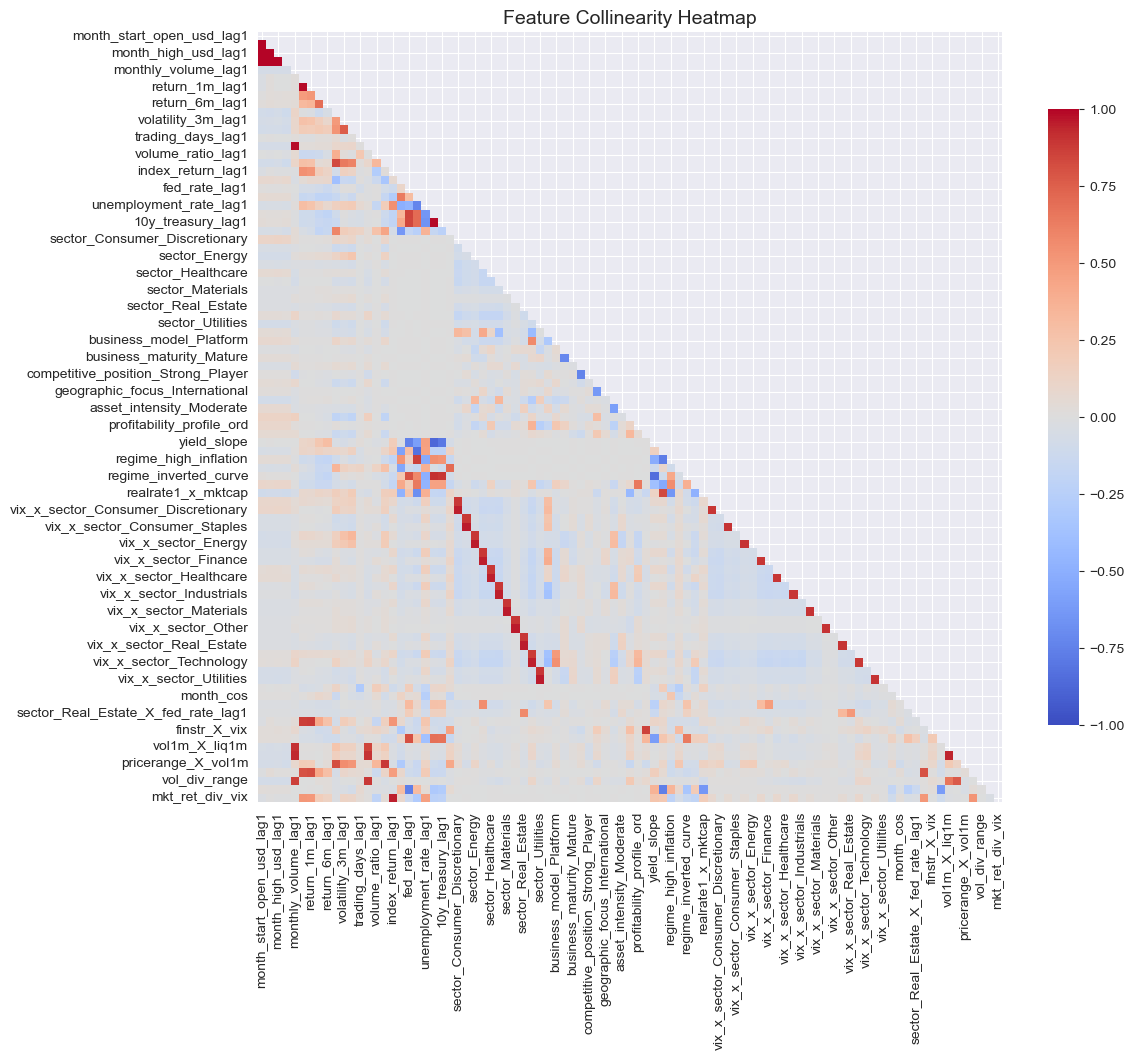

In [82]:
# Check collinearity heatmap of stock features
num_cols = [c for c in df_train_feat_eng.columns if c not in ["stock_id", "month_id"]]
plot_collinearity_heatmap(df_train_feat_eng[num_cols])

In [83]:
# Check collinearity of stock features
find_collinear_pairs(df_train_feat_eng[num_cols], threshold=0.8).sort_values("Corr", ascending=False)

,Feature1,Feature2,Corr
182,month_high_usd_lag1,month_start_open_usd_lag1,0.997990
94,month_end_close_usd_lag1,month_low_usd_lag1,0.997526
93,month_end_close_usd_lag1,month_high_usd_lag1,0.997406
273,month_low_usd_lag1,month_start_open_usd_lag1,0.996625
185,month_high_usd_lag1,month_low_usd_lag1,0.996174
...,...,...,...
7998,ret1m_div_vol,sizeord_X_ret1m,0.804157
542,intramonth_return_lag1,ret1m_div_vol,0.800635
1778,inflation_rate_lag1,real_rate,-0.822984
4780,regime_inverted_curve,yield_slope,-0.837818


**NOTE**

As can be seen from the heatmap and the calculated collinearities above, there are many highly collinear features. 0.8 correlation threshold is chosen since it is a normal data science benchmark. We will now go through these highly collinear features individually and decide which ones to keep depending on univariate prediction power and p-value.

##### Collinear Feature Exploration and Removal

Firstly, we shall merge Existing feature dataset with df_train_target to get our target variable outperform_binary for calculating univariate prediction power and p-value to aid our collinearity removal decisions.

In [84]:
# Merge on stock_id + month_id
df_train_merged_eng = df_train_feat_eng.merge(
    df_train_target[["stock_id", "month_id", "outperform_binary"]],
    on=["stock_id", "month_id"],
    how="left"
)

df_train_merged_eng.info()
df_train_merged_eng.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24867 entries, 0 to 24866
Data columns (total 94 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   stock_id                               24867 non-null  object 
 1   month_id                               24867 non-null  object 
 2   month_start_open_usd_lag1              24867 non-null  float64
 3   month_end_close_usd_lag1               24867 non-null  float64
 4   month_high_usd_lag1                    24867 non-null  float64
 5   month_low_usd_lag1                     24867 non-null  float64
 6   monthly_volume_lag1                    24867 non-null  float64
 7   intramonth_return_lag1                 24867 non-null  float64
 8   return_1m_lag1                         24867 non-null  float64
 9   return_3m_lag1                         24867 non-null  float64
 10  return_6m_lag1                         24867 non-null  float64
 11  in

,stock_id,month_id,month_start_open_usd_lag1,month_end_close_usd_lag1,month_high_usd_lag1,month_low_usd_lag1,monthly_volume_lag1,intramonth_return_lag1,return_1m_lag1,return_3m_lag1,...,finstr_X_vix,finstr_X_fed,vol1m_X_liq1m,intramonth_vol_X_vix,pricerange_X_vol1m,ret1m_div_vol,vol_div_range,term_spread,mkt_ret_div_vix,outperform_binary
0,US001,2020_02,120.192,107.326,123.486,107.035,84539259.0,-0.107045,-0.100669,-0.030041,...,13.94,1.55,2.141413e+07,1.178477e+09,0.034671,-0.397422,6.176339e+08,-0.03,-0.000463,0
1,US001,2020_03,108.252,101.868,111.641,99.636,91313882.0,-0.058974,-0.050854,-0.112968,...,19.63,1.58,2.366929e+07,1.792492e+09,0.028747,-0.196189,8.233448e+08,-0.45,-0.002703,1
2,US001,2020_04,103.301,93.178,105.622,77.841,177930833.0,-0.097995,-0.085299,-0.219214,...,57.74,0.65,1.588405e+08,1.027373e+10,0.240077,-0.095551,6.616202e+08,0.05,-0.001929,1
3,US001,2020_05,90.100,103.697,111.314,89.424,98448862.0,0.150910,0.112885,-0.033810,...,41.45,0.05,4.020179e+07,4.080705e+09,0.099211,0.276440,4.052144e+08,0.57,0.003409,0
4,US001,2020_06,101.909,107.841,110.206,89.499,103380207.0,0.058209,0.039966,0.058641,...,30.90,0.05,4.335435e+07,3.194448e+09,0.085210,0.095300,5.087934e+08,0.60,0.002305,0


In [85]:
# Check for consistency
df_train_target.head()

,month_id,stock_id,outperform_binary,excess_return
0,2020_01,US001,0,-0.100593
1,2020_02,US001,0,-0.005920
2,2020_03,US001,1,0.013384
3,2020_04,US001,1,0.009597
4,2020_05,US001,0,-0.013023


**NOTE**

The joining is done properly with no missing value and mismatched binary from the original dataset for each stock. Next, is the helper function to calculate correlation and collinearity between features and target variable.

In [86]:
from scipy.stats import pointbiserialr
def corr_and_collinearity(
    df: pd.DataFrame,
    features: List[str],
    target_col: str,
    min_n: int = 3,
    p_decimals: int = 6
) -> Dict[str, Any]:
    """
    Compute:
      1) point-biserial correlation (r, p-value) between each feature and a binary target
      2) feature-feature Pearson correlation matrix

    Returns a dict with:
      - present_features
      - missing_features
      - corr_to_target (DataFrame)
      - feature_feature_corr (DataFrame)
    """
    if target_col not in df.columns:
        raise KeyError(f"Target column '{target_col}' not found in df.")

    # Keep only features that exist
    present = [c for c in features if c in df.columns]
    missing = sorted(set(features) - set(present))

    # Numeric versions (coerce errors to NaN)
    X = df[present].apply(pd.to_numeric, errors="coerce")
    y = pd.to_numeric(df[target_col], errors="coerce")

    # 1) Correlation with target
    rows = []
    for col in present:
        s = X[col]
        mask = s.notna() & y.notna()
        n = int(mask.sum())
        if n >= min_n:
            try:
                r, p = pointbiserialr(y[mask], s[mask])
            except Exception:
                r, p = np.nan, np.nan
        else:
            r, p = np.nan, np.nan

        rows.append({
            "feature": col,
            "n": n,
            "r_pointbiserial": r,
            "abs_r": abs(r) if pd.notna(r) else np.nan,
            "p_value": (round(p, p_decimals) if pd.notna(p) else np.nan)

        })

    corr_to_target = (
        pd.DataFrame(rows)
        .sort_values(["abs_r", "p_value"], ascending=[False, True])
        .reset_index(drop=True)
    )

    # 2) Feature-feature correlation matrix
    ff_corr = X.corr(method="pearson")

    return {
        "present_features": present,
        "missing_features": missing,
        "corr_to_target": corr_to_target,
        "feature_feature_corr": ff_corr
    }

###### OHLC Price & Ratios

In [87]:
cols_ohlc = [
    "intramonth_volatility_lag1",
    "month_start_open_usd_lag1",
    "month_end_close_usd_lag1",
    "month_high_usd_lag1",
    "month_low_usd_lag1",
    "price_range_ratio_lag1",
    "pricerange_X_vol1m",    # interaction with volatility
]

report = corr_and_collinearity(df_train_merged_eng, cols_ohlc, target_col="outperform_binary")

display(report["corr_to_target"])   # r & p-values vs target
display(report["feature_feature_corr"])        # full feature-feature corr matrix

,feature,n,r_pointbiserial,abs_r,p_value
0,intramonth_volatility_lag1,24867,0.036485,0.036485,0.000000
1,pricerange_X_vol1m,24867,0.031583,0.031583,0.000001
2,price_range_ratio_lag1,24867,0.029034,0.029034,0.000005
3,month_end_close_usd_lag1,24867,-0.006388,0.006388,0.313820
4,month_low_usd_lag1,24867,-0.006206,0.006206,0.327782
5,month_high_usd_lag1,24867,-0.005538,0.005538,0.382484
6,month_start_open_usd_lag1,24867,-0.005448,0.005448,0.390285


,intramonth_volatility_lag1,month_start_open_usd_lag1,month_end_close_usd_lag1,month_high_usd_lag1,month_low_usd_lag1,price_range_ratio_lag1,pricerange_X_vol1m
intramonth_volatility_lag1,1.000000,-0.081867,-0.087744,-0.071217,-0.104760,0.830052,0.817508
month_start_open_usd_lag1,-0.081867,1.000000,0.994881,0.997990,0.996625,-0.084560,-0.067858
month_end_close_usd_lag1,-0.087744,0.994881,1.000000,0.997406,0.997526,-0.082154,-0.069721
month_high_usd_lag1,-0.071217,0.997990,0.997406,1.000000,0.996174,-0.067696,-0.058081
month_low_usd_lag1,-0.104760,0.996625,0.997526,0.996174,1.000000,-0.102157,-0.083089
price_range_ratio_lag1,0.830052,-0.084560,-0.082154,-0.067696,-0.102157,1.000000,0.885281
pricerange_X_vol1m,0.817508,-0.067858,-0.069721,-0.058081,-0.083089,0.885281,1.000000


- **Keep**
  - `price_range_ratio` – captures the relative difference between high and low prices; not fully collinear with OHLC levels
  - `month_end_close_usd` – strong representation of monthly price level; highly correlated with open/high/low, but best as a stable closing measure

- **Remove**
  - `month_low_usd` – almost perfectly correlated with open/high/close (0.99+), redundant
  - `month_start_open_usd` – almost perfectly correlated with close and low (0.99+), redundant
  - `month_high_usd` – almost perfectly correlated with low/open/close (0.99+), redundant
  - `pricerange_X_vol1m` – highly collinear with `price_range_ratio` (0.89) and adds little new information

In [88]:
num_cols_drop = []
num_cols_drop.extend(["month_low_usd_lag1", "month_start_open_usd_lag1", "month_low_usd_lag1", "pricerange_X_vol1m"])

###### Returns & Momentum

In [89]:
cols_volume = ["return_1m_lag1", "return_3m_lag1", "return_6m_lag1", "intramonth_return_lag1", "sizeord_X_ret1m", "ret1m_div_vol"]

report = corr_and_collinearity(df_train_merged_eng, cols_volume, target_col="outperform_binary")

display(report["corr_to_target"])   # r & p-values vs target
display(report["feature_feature_corr"])        # full feature-feature corr matrix

,feature,n,r_pointbiserial,abs_r,p_value
0,sizeord_X_ret1m,24867,-0.011313,0.011313,0.074429
1,return_1m_lag1,24867,-0.008876,0.008876,0.161601
2,return_6m_lag1,24867,0.005623,0.005623,0.375229
3,intramonth_return_lag1,24867,-0.005460,0.005460,0.389277
4,ret1m_div_vol,24867,-0.002475,0.002475,0.696379
5,return_3m_lag1,24867,0.000272,0.000272,0.965809


,return_1m_lag1,return_3m_lag1,return_6m_lag1,intramonth_return_lag1,sizeord_X_ret1m,ret1m_div_vol
return_1m_lag1,1.000000,0.513963,0.348944,0.991923,0.877999,0.816485
return_3m_lag1,0.513963,1.000000,0.687861,0.488601,0.416565,0.426997
return_6m_lag1,0.348944,0.687861,1.000000,0.325816,0.262763,0.282994
intramonth_return_lag1,0.991923,0.488601,0.325816,1.000000,0.871204,0.800635
sizeord_X_ret1m,0.877999,0.416565,0.262763,0.871204,1.000000,0.804157
ret1m_div_vol,0.816485,0.426997,0.282994,0.800635,0.804157,1.000000


- **Keep**
  - `return_1m` – strong momentum feature; borderline collinearity (0.81) but still adds predictive value
  - `sizeord_X_ret1m` – interaction term (market cap size × one-month return); provides cross-effect information beyond raw return

- **Remove**
  - `return_3m` – highly correlated with `return_6m` (0.69) and weaker univariate predictor
  - `return_6m` – moderate correlation with `return_3m`, but weaker point-biserial correlation and p-value not significant
  - `intramonth_return` – highly collinear with `return_1m` (0.99), redundant
  - `ret1m_div_vol` – highly collinear with both `return_1m` (0.82) and `sizeord_X_ret1m` (0.80), adds little new information

In [90]:
num_cols_drop.extend(["return_3m_lag1", "return_6m_lag1", "intramonth_return_lag1", "ret1m_div_vol"])

###### Volatility & Microstructure

In [91]:
cols_vol_micro = ["volatility_3m_lag1", "volatility_6m_lag1", "intramonth_volatility_lag1", "intramonth_vol_X_vix", "vix_lag1"]

report = corr_and_collinearity(df_train_merged_eng, cols_vol_micro, target_col="outperform_binary")

display(report["corr_to_target"])   # r & p-values vs target
display(report["feature_feature_corr"])        # full feature-feature corr matrix

,feature,n,r_pointbiserial,abs_r,p_value
0,vix_lag1,24867,0.075305,0.075305,0.000000
1,intramonth_volatility_lag1,24867,0.036485,0.036485,0.000000
2,intramonth_vol_X_vix,24867,0.017760,0.017760,0.005099
3,volatility_3m_lag1,24867,0.016828,0.016828,0.007961
4,volatility_6m_lag1,24867,0.014747,0.014747,0.020045


,volatility_3m_lag1,volatility_6m_lag1,intramonth_volatility_lag1,intramonth_vol_X_vix,vix_lag1
volatility_3m_lag1,1.000000,0.760677,0.499639,0.092903,0.179676
volatility_6m_lag1,0.760677,1.000000,0.525375,0.090303,0.141076
intramonth_volatility_lag1,0.499639,0.525375,1.000000,0.162115,0.587098
intramonth_vol_X_vix,0.092903,0.090303,0.162115,1.000000,0.138046
vix_lag1,0.179676,0.141076,0.587098,0.138046,1.000000


- **Keep**
  - `intramonth_volatility` – strong univariate predictor and a good short-term indicator of volatility
  - `volatility_6m` – provides a longer-term view of volatility, less collinear with `intramonth_volatility`
  - `intramonth_vol_X_vix` – interaction feature that captures combined effects of short-term volatility with market-wide VIX sentiment
  - `vix` – widely used external benchmark of market volatility, not highly collinear with other features

- **Remove**
  - `volatility_3m` – highly collinear with `volatility_6m` (correlation 0.76) and adds limited incremental predictive power

In [92]:
num_cols_drop.extend(["volatility_3m_lag1"])

###### Volume & Liquidity

In [93]:
cols_volume = ["avg_volume_3m_lag1", "volume_ratio_lag1", "monthly_volume_lag1", "trading_days_lag1", "vol_div_range", "vol1m_X_liq1m"]

report = corr_and_collinearity(df_train_merged_eng, cols_volume, target_col="outperform_binary")

display(report["corr_to_target"])   # r & p-values vs target
display(report["feature_feature_corr"])        # full feature-feature corr matrix

,feature,n,r_pointbiserial,abs_r,p_value
0,volume_ratio_lag1,24867,0.040135,0.040135,0.000000
1,trading_days_lag1,24867,0.022384,0.022384,0.000416
2,vol1m_X_liq1m,24867,0.013568,0.013568,0.032389
3,monthly_volume_lag1,24867,0.010962,0.010962,0.083895
4,avg_volume_3m_lag1,24867,0.009991,0.009991,0.115165
5,vol_div_range,24867,0.004681,0.004681,0.460476


,avg_volume_3m_lag1,volume_ratio_lag1,monthly_volume_lag1,trading_days_lag1,vol_div_range,vol1m_X_liq1m
avg_volume_3m_lag1,1.000000,-0.000353,0.979438,0.004234,0.885939,0.850781
volume_ratio_lag1,-0.000353,1.000000,0.059768,0.222115,0.002486,0.113274
monthly_volume_lag1,0.979438,0.059768,1.000000,0.016326,0.865000,0.907110
trading_days_lag1,0.004234,0.222115,0.016326,1.000000,0.018202,0.021619
vol_div_range,0.885939,0.002486,0.865000,0.018202,1.000000,0.660507
vol1m_X_liq1m,0.850781,0.113274,0.907110,0.021619,0.660507,1.000000


- **Keep**
  - `volume_ratio`
  - `vol1m_X_liq1m`
  - `trading_days`

- **Remove**
  - `monthly_volume` – highly correlated to `avg_volume_3m` and `vol1m_X_liq1m`
  - `avg_volume_3m` – highly correlated to other features, low p-value, and weak univariate correlation
  - `vol_div_range` – highly correlated to other features and low univariate predictive power

In [94]:
num_cols_drop.extend(["avg_volume_3m_lag1", "monthly_volume_lag1", "vol_div_range"])

###### Treasury & Rates

In [95]:
cols_rates = ["10y_treasury_lag1", "5y_treasury_lag1", "index_value_lag1", "index_return_lag1", "fed_rate_lag1", "real_rate", "yield_slope", "realrate1_x_mktcap", "inflation_rate_lag1", "unemployment_rate_lag1"]

report = corr_and_collinearity(df_train_merged_eng, cols_rates, target_col="outperform_binary")

display(report["corr_to_target"])   # r & p-values vs target
display(report["feature_feature_corr"])        # full feature-feature corr matrix

,feature,n,r_pointbiserial,abs_r,p_value
0,index_return_lag1,24867,-0.030430,0.030430,0.000002
1,unemployment_rate_lag1,24867,0.029489,0.029489,0.000003
2,realrate1_x_mktcap,24867,-0.014704,0.014704,0.020407
3,yield_slope,24867,0.014490,0.014490,0.022311
4,fed_rate_lag1,24867,-0.012996,0.012996,0.040431
5,inflation_rate_lag1,24867,-0.009848,0.009848,0.120439
6,index_value_lag1,24867,-0.009668,0.009668,0.127373
7,10y_treasury_lag1,24867,0.007614,0.007614,0.229905
8,5y_treasury_lag1,24867,0.002988,0.002988,0.637563
9,real_rate,24867,0.002135,0.002135,0.736415


,10y_treasury_lag1,5y_treasury_lag1,index_value_lag1,index_return_lag1,fed_rate_lag1,real_rate,yield_slope,realrate1_x_mktcap,inflation_rate_lag1,unemployment_rate_lag1
10y_treasury_lag1,1.000000,0.990862,0.409136,-0.194197,0.838408,-0.207865,-0.794035,-0.173527,0.705266,-0.663356
5y_treasury_lag1,0.990862,1.000000,0.340075,-0.199429,0.848390,-0.203668,-0.868767,-0.170136,0.707013,-0.644033
index_value_lag1,0.409136,0.340075,1.000000,0.063599,0.104712,-0.578544,-0.030468,-0.481016,0.638900,-0.500121
index_return_lag1,-0.194197,-0.199429,0.063599,1.000000,-0.111607,0.223178,0.185775,0.185795,-0.288766,0.543210
fed_rate_lag1,0.838408,0.848390,0.104712,-0.111607,1.000000,0.292594,-0.745239,0.242872,0.302404,-0.471709
real_rate,-0.207865,-0.203668,-0.578544,0.223178,0.292594,1.000000,0.154699,0.832030,-0.822984,0.454295
yield_slope,-0.794035,-0.868767,-0.030468,0.185775,-0.745239,0.154699,1.000000,0.129649,-0.596922,0.466960
realrate1_x_mktcap,-0.173527,-0.170136,-0.481016,0.185795,0.242872,0.832030,0.129649,1.000000,-0.685090,0.378186
inflation_rate_lag1,0.705266,0.707013,0.638900,-0.288766,0.302404,-0.822984,-0.596922,-0.685090,1.000000,-0.733067
unemployment_rate_lag1,-0.663356,-0.644033,-0.500121,0.543210,-0.471709,0.454295,0.466960,0.378186,-0.733067,1.000000


- **Keep**
  - `fed_rate` – statistically significant (p ≈ 0.04); capturing short-term policy stance distinct from market yields.
  - `yield_slope` – statistically significant (p ≈ 0.02);
  - `index_return` – very low p-value (<0.001); although effect size is weak (r ≈ -0.03), statistical significance and independence from rates make it useful
  - `realrate1_x_mktcap` – low p-value (0.02); provides interaction effects linking real rates to firm size.

- **Remove**
  - `5y_treasury` – redundant with `10y_treasury` (correlation 0.99)
  - `10y_treasury` - redundant with `yield_slope` which captures treasury information and is poor univariate predictor
  - `index_value` – weak predictor and redundant with `index_return`
  - `real_rate` – minimal standalone predictive power; highly collinear with inflation

In [96]:
num_cols_drop.extend(["5y_treasury_lag1", "index_value_lag1", "real_rate", "10y_treasury_lag1"])

###### Inflation and Unemployment

Try combining inflation_rate and unemployment_rate as they are collinear and only unemployment_rate is a good univariate predictor.

In [97]:
# Product (interaction term)
df_train_merged_eng["infl_unemp_prod"] = df_train_merged_eng["inflation_rate_lag1"] * df_train_merged_eng["unemployment_rate_lag1"]

# Ratio (relative comparison)
df_train_merged_eng["infl_unemp_ratio"] = df_train_merged_eng["inflation_rate_lag1"] / (df_train_merged_eng["unemployment_rate_lag1"] + 1e-6)

# Difference (spread)
df_train_merged_eng["infl_unemp_diff"] = df_train_merged_eng["inflation_rate_lag1"] - df_train_merged_eng["unemployment_rate_lag1"]

# Sum (overall macro pressure)
df_train_merged_eng["infl_unemp_sum"] = df_train_merged_eng["inflation_rate_lag1"] + df_train_merged_eng["unemployment_rate_lag1"]

In [98]:
interaction_features = [
    "infl_unemp_prod",
    "infl_unemp_ratio",
    "infl_unemp_diff",
    "infl_unemp_sum"
]

report_inter = corr_and_collinearity(
    df_train_merged_eng,
    interaction_features,
    target_col="outperform_binary"
)

display(report_inter["corr_to_target"])

,feature,n,r_pointbiserial,abs_r,p_value
0,infl_unemp_sum,24867,0.025254,0.025254,0.000068
1,infl_unemp_diff,24867,-0.020822,0.020822,0.001024
2,infl_unemp_ratio,24867,-0.012479,0.012479,0.049083
3,infl_unemp_prod,24867,-0.003317,0.003317,0.600945


No Significant improvements, drop inflation rate as it is the worse predictor.

- **Keep**
  - `unemployment_rate` – very low p-value (<0.001); moderate correlations with inflation (-0.73) and Treasury yields (-0.66) show it provides complementary macro information beyond rates alone.

- **Remove**
  - `inflation_rate` – p-value not significant (0.12), but potentially useful as multivariate predictor

In [99]:
num_cols_drop.extend(["inflation_rate_lag1"] + interaction_features)

###### Macro Regimes

In [100]:
cols_macro = [
    "inflation_rate_lag1",
    "unemployment_rate_lag1",
    "regime_high_inflation",
    "regime_inverted_curve",
    "yield_slope"
]

report = corr_and_collinearity(df_train_merged_eng, cols_macro, target_col="outperform_binary")

display(report["corr_to_target"])   # r & p-values vs target
display(report["feature_feature_corr"])        # full feature-feature corr matrix

,feature,n,r_pointbiserial,abs_r,p_value
0,unemployment_rate_lag1,24867,0.029489,0.029489,0.000003
1,yield_slope,24867,0.014490,0.014490,0.022311
2,regime_high_inflation,24867,0.011850,0.011850,0.061672
3,regime_inverted_curve,24867,0.010657,0.010657,0.092849
4,inflation_rate_lag1,24867,-0.009848,0.009848,0.120439


,inflation_rate_lag1,unemployment_rate_lag1,regime_high_inflation,regime_inverted_curve,yield_slope
inflation_rate_lag1,1.000000,-0.733067,0.864001,0.583028,-0.596922
unemployment_rate_lag1,-0.733067,1.000000,-0.533380,-0.503543,0.466960
regime_high_inflation,0.864001,-0.533380,1.000000,0.425786,-0.517955
regime_inverted_curve,0.583028,-0.503543,0.425786,1.000000,-0.837818
yield_slope,-0.596922,0.466960,-0.517955,-0.837818,1.000000


- **Keep**
  - `unemployment_rate` – statistically significant (p < 0.001), moderate correlations with other variables (-0.73 with inflation), provides independent macroeconomic information.
  - `regime_high_inflation` – borderline significant (p ≈ 0.06), very strong correlation with inflation (0.86) but offers categorical regime signal, simplifying interpretation.


- **Remove (or downweight)**
  - `inflation_rate` – weak univariate predictor (p = 0.12), highly collinear with `regime_high_inflation`; regime version is more interpretable.
  - `regime_inverted_curve` – higher p_value and redundant with `yield_slope` which is better predictor

In [101]:
# Inflation rate already removed in treasury & rates exploration
num_cols_drop.extend(["regime_inverted_curve"])

###### VIX & Market Stress

In [102]:
cols_vix = [
    "vix_lag1",
    "mkt_ret_div_vix",
    "intramonth_vol_X_vix",  # already in vol_micro but vix-linked
]


report = corr_and_collinearity(df_train_merged_eng, cols_vix, target_col="outperform_binary")

display(report["corr_to_target"])   # r & p-values vs target
display(report["feature_feature_corr"])        # full feature-feature corr matrix

,feature,n,r_pointbiserial,abs_r,p_value
0,vix_lag1,24867,0.075305,0.075305,0.000000
1,mkt_ret_div_vix,24867,-0.029146,0.029146,0.000004
2,intramonth_vol_X_vix,24867,0.017760,0.017760,0.005099


,vix_lag1,mkt_ret_div_vix,intramonth_vol_X_vix
vix_lag1,1.000000,-0.002712,0.138046
mkt_ret_div_vix,-0.002712,1.000000,-0.010650
intramonth_vol_X_vix,0.138046,-0.010650,1.000000


- **Keep**
  - `vix` – strongest predictor (highest correlation with target, lowest p-value); benchmark volatility index.
  - `intramonth_vol_X_vix` – weaker univariate signal but complements VIX by combining realized & implied volatility.
  - `mkt_ret_div_vix` – also weaker univariate signal but not collinear, no reason to remove


###### Sector Interactions

In [103]:
cols_sector_dummies = [
    "sector_Energy", "sector_Materials", "sector_Utilities",
    "sector_Real_Estate", "sector_Consumer_Staples",
    "sector_Consumer_Discretionary", "sector_Healthcare",
    "sector_Finance", "sector_Industrials", "sector_Technology",
    "sector_Other",
]

# Interaction with vix
cols_sector_x_vix = [
    "vix_x_sector_Energy", "vix_x_sector_Materials",
    "vix_x_sector_Utilities", "vix_x_sector_Real_Estate",
    "vix_x_sector_Consumer_Staples", "vix_x_sector_Consumer_Discretionary",
    "vix_x_sector_Healthcare", "vix_x_sector_Finance",
    "vix_x_sector_Industrials", "vix_x_sector_Technology",
    "vix_x_sector_Other", "vix"
]

# Interaction with unemployment
cols_sector_x_unemp = [
    "unemp_x_sector_Energy", "unemp_x_sector_Materials",
    "unemp_x_sector_Utilities", "unemp_x_sector_Real_Estate",
    "unemp_x_sector_Consumer_Staples", "unemp_x_sector_Consumer_Discretionary",
    "unemp_x_sector_Healthcare", "unemp_x_sector_Finance",
    "unemp_x_sector_Industrials", "unemp_x_sector_Technology",
    "unemp_x_sector_Other",
]

Use function to compare sector features between dummy, interaction with vix and interaction with unemployment rate to see which serves as the best predictor according to p-value and absolute correlation. Then take best feature per sector and drop rest.

In [104]:
from scipy.stats import pointbiserialr

def compare_sector_interactions(df, sector_dummies, target="outperform_binary", min_n=50):
    """
    For each sector dummy, compare:
      - sector dummy itself
      - vix_x_sector
      - unemp_x_sector
    Returns long + wide tables for direct comparison.
    """
    records = []

    for sec in sector_dummies:
        # sector_Energy → suffix = Energy
        suffix = sec.replace("sector_", "")
        candidates = {
            "dummy": sec,
            "vix_x": f"vix_x_sector_{suffix}",
            "unemp_x": f"unemp_x_sector_{suffix}"
        }

        for kind, col in candidates.items():
            if col not in df.columns:
                continue
            s = pd.to_numeric(df[col], errors="coerce")
            y = pd.to_numeric(df[target], errors="coerce")
            mask = s.notna() & y.notna()
            if mask.sum() < min_n:
                continue
            try:
                r, p = pointbiserialr(y[mask], s[mask])
            except Exception:
                r, p = np.nan, np.nan
            records.append({
                "sector": suffix,
                "feature_type": kind,
                "feature": col,
                "r": r,
                "abs_r": abs(r) if pd.notna(r) else np.nan,
                "p": p,
                "n": mask.sum()
            })

    df_long = pd.DataFrame(records)

    # Wide pivot for side-by-side comparison
    df_wide = df_long.pivot(index="sector", columns="feature_type", values="r").reset_index()

    # Identify best feature per sector (by |r|)
    best_feats = (
        df_long.sort_values(["sector","p", "abs_r",], ascending=[True,True,False])
        .groupby("sector").first()
        .reset_index()
    )

    return df_long, df_wide, best_feats


In [105]:
df_long, df_wide, best_feats = compare_sector_interactions(
    df_train_merged_eng,
    cols_sector_dummies,
    target="outperform_binary"
)


print("=== Wide format (side-by-side dummy vs VIX vs Unemp) ===")
print(df_wide)

print("=== Best feature per sector ===")
print(best_feats[["sector","feature","p", "r"]])

=== Wide format (side-by-side dummy vs VIX vs Unemp) ===
feature_type                  sector     dummy   unemp_x     vix_x
0             Consumer_Discretionary  0.005519  0.019197  0.022828
1                   Consumer_Staples -0.002958 -0.011148 -0.005536
2                             Energy  0.007441  0.000445  0.018503
3                            Finance -0.000268  0.004313  0.010509
4                         Healthcare -0.011520 -0.010333 -0.003544
5                        Industrials  0.011281  0.018791  0.017742
6                          Materials  0.006391  0.012761  0.011202
7                              Other -0.000254  0.001413  0.002679
8                        Real_Estate -0.004374 -0.003686 -0.003979
9                         Technology  0.007783  0.023109  0.018637
10                         Utilities -0.013021 -0.020911 -0.015660
=== Best feature per sector ===
                    sector                              feature         p  \
0   Consumer_Discretionary  vi

keep:
=== Best feature per sector ===
                    sector                              feature         p  \
0   Consumer_Discretionary  vix_x_sector_Consumer_Discretionary  0.000318
1         Consumer_Staples      unemp_x_sector_Consumer_Staples  0.078753
2                   Energy                  vix_x_sector_Energy  0.003525
3                  Finance                 vix_x_sector_Finance  0.097503
4               Healthcare                    sector_Healthcare  0.069276
5              Industrials           unemp_x_sector_Industrials  0.003043
6                Materials             unemp_x_sector_Materials  0.044194
7                    Other                   vix_x_sector_Other  0.672670
8              Real_Estate                   sector_Real_Estate  0.490393
9               Technology            unemp_x_sector_Technology  0.000268
10               Utilities             unemp_x_sector_Utilities  0.000975

In [106]:
# Get list of best features
best_sector_cols = best_feats["feature"].tolist()

print("Keeping best sector features:", best_sector_cols)

# Drop all other sector-related columns
sector_related = (
    cols_sector_dummies +
    [f"vix_x_sector_{c.replace('sector_','')}" for c in cols_sector_dummies] +
    [f"unemp_x_sector_{c.replace('sector_','')}" for c in cols_sector_dummies]
)

drop_cols = [c for c in sector_related if c not in best_sector_cols]

num_cols_drop.extend(drop_cols)


Keeping best sector features: ['vix_x_sector_Consumer_Discretionary', 'unemp_x_sector_Consumer_Staples', 'vix_x_sector_Energy', 'vix_x_sector_Finance', 'sector_Healthcare', 'unemp_x_sector_Industrials', 'unemp_x_sector_Materials', 'vix_x_sector_Other', 'sector_Real_Estate', 'unemp_x_sector_Technology', 'unemp_x_sector_Utilities']


###### Ordinals & Firm Fundamentals

In [107]:
cols_ordinals = [
    "financial_strength_ord",
    "finstr_X_vix",
    "finstr_X_fed",
    "market_cap_category_ord",
    "vix_lag1"
]

report = corr_and_collinearity(df_train_merged_eng, cols_ordinals, target_col="outperform_binary")

display(report["corr_to_target"])   # r & p-values vs target
display(report["feature_feature_corr"])        # full feature-feature corr matrix

,feature,n,r_pointbiserial,abs_r,p_value
0,vix_lag1,24867,0.075305,0.075305,0.000000
1,finstr_X_vix,24867,0.034907,0.034907,0.000000
2,market_cap_category_ord,24867,0.018878,0.018878,0.002910
3,financial_strength_ord,24867,0.005670,0.005670,0.371319
4,finstr_X_fed,24867,-0.005622,0.005622,0.375374


,financial_strength_ord,finstr_X_vix,finstr_X_fed,market_cap_category_ord,vix_lag1
financial_strength_ord,1.000000,0.857105,0.343378,0.329323,0.001108
finstr_X_vix,0.857105,1.000000,0.204372,0.281743,0.445686
finstr_X_fed,0.343378,0.204372,1.000000,0.115181,-0.150287
market_cap_category_ord,0.329323,0.281743,0.115181,1.000000,0.000306
vix_lag1,0.001108,0.445686,-0.150287,0.000306,1.000000


- **Keep**
  - `finstr_X_vix` – strongest predictor in this group (low p-value, statistically robust) and low collinearity with vix
  - `market_cap_category_ord` – moderate predictive power, significant p-value, adds complementary categorical info.

- **Remove**
  - `financial_strength_ord` – weak, non-significant predictor; redundant with `finstr_X_vix`.
  - `finstr_X_fed` – very weak and non-significant predictor; low value-added.

In [108]:
num_cols_drop.extend(["financial_strength_ord", "finstr_X_fed"])

###### Dropping Columns

In [109]:
print(len(num_cols_drop))
print(num_cols_drop)

46
['month_low_usd_lag1', 'month_start_open_usd_lag1', 'month_low_usd_lag1', 'pricerange_X_vol1m', 'return_3m_lag1', 'return_6m_lag1', 'intramonth_return_lag1', 'ret1m_div_vol', 'volatility_3m_lag1', 'avg_volume_3m_lag1', 'monthly_volume_lag1', 'vol_div_range', '5y_treasury_lag1', 'index_value_lag1', 'real_rate', '10y_treasury_lag1', 'inflation_rate_lag1', 'infl_unemp_prod', 'infl_unemp_ratio', 'infl_unemp_diff', 'infl_unemp_sum', 'regime_inverted_curve', 'sector_Energy', 'sector_Materials', 'sector_Utilities', 'sector_Consumer_Staples', 'sector_Consumer_Discretionary', 'sector_Finance', 'sector_Industrials', 'sector_Technology', 'sector_Other', 'vix_x_sector_Materials', 'vix_x_sector_Utilities', 'vix_x_sector_Real_Estate', 'vix_x_sector_Consumer_Staples', 'vix_x_sector_Healthcare', 'vix_x_sector_Industrials', 'vix_x_sector_Technology', 'unemp_x_sector_Energy', 'unemp_x_sector_Real_Estate', 'unemp_x_sector_Consumer_Discretionary', 'unemp_x_sector_Healthcare', 'unemp_x_sector_Finance', 

In [110]:
# Make a copy to avoid modifying the original
df_reduced = df_train_feat_eng.drop(columns=num_cols_drop, errors="ignore")

print("Dropped columns:", num_cols_drop)
print("Remaining shape:", df_reduced.shape)

Dropped columns: ['month_low_usd_lag1', 'month_start_open_usd_lag1', 'month_low_usd_lag1', 'pricerange_X_vol1m', 'return_3m_lag1', 'return_6m_lag1', 'intramonth_return_lag1', 'ret1m_div_vol', 'volatility_3m_lag1', 'avg_volume_3m_lag1', 'monthly_volume_lag1', 'vol_div_range', '5y_treasury_lag1', 'index_value_lag1', 'real_rate', '10y_treasury_lag1', 'inflation_rate_lag1', 'infl_unemp_prod', 'infl_unemp_ratio', 'infl_unemp_diff', 'infl_unemp_sum', 'regime_inverted_curve', 'sector_Energy', 'sector_Materials', 'sector_Utilities', 'sector_Consumer_Staples', 'sector_Consumer_Discretionary', 'sector_Finance', 'sector_Industrials', 'sector_Technology', 'sector_Other', 'vix_x_sector_Materials', 'vix_x_sector_Utilities', 'vix_x_sector_Real_Estate', 'vix_x_sector_Consumer_Staples', 'vix_x_sector_Healthcare', 'vix_x_sector_Industrials', 'vix_x_sector_Technology', 'unemp_x_sector_Energy', 'unemp_x_sector_Real_Estate', 'unemp_x_sector_Consumer_Discretionary', 'unemp_x_sector_Healthcare', 'unemp_x_sec

In [111]:
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24867 entries, 0 to 24866
Data columns (total 52 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   stock_id                               24867 non-null  object 
 1   month_id                               24867 non-null  object 
 2   month_end_close_usd_lag1               24867 non-null  float64
 3   month_high_usd_lag1                    24867 non-null  float64
 4   return_1m_lag1                         24867 non-null  float64
 5   intramonth_volatility_lag1             24867 non-null  float64
 6   volatility_6m_lag1                     24867 non-null  float64
 7   trading_days_lag1                      24867 non-null  float64
 8   volume_ratio_lag1                      24867 non-null  float64
 9   price_range_ratio_lag1                 24867 non-null  float64
 10  index_return_lag1                      24867 non-null  float64
 11  fe

In [112]:
df_reduced.to_csv("features_reduced.csv", index=False)

#### 4.2.4 Feature transformation

In [113]:
df_transform = pd.read_csv("features_reduced.csv")

In [114]:
# Helper function for comparing and before and after effect of transformation
def compare_transforms(df, feature):
    fig, axes = plt.subplots(1, 4, figsize=(16,4))

    # Original
    sns.histplot(df[feature].dropna(), bins=50, kde=True, ax=axes[0])
    axes[0].set_title("Original")

    # Log (if positive)
    if (df[feature] > 0).all():
        sns.histplot(np.log1p(df[feature]), bins=50, kde=True, ax=axes[1])
        axes[1].set_title("Log(1+x)")
    else:
        axes[1].set_title("Log skipped (negatives present)")

    # Yeo-Johnson
    pt_yj = PowerTransformer(method="yeo-johnson")
    yj_trans = pt_yj.fit_transform(df[[feature]].dropna())
    sns.histplot(yj_trans.flatten(), bins=50, kde=True, ax=axes[2])
    axes[2].set_title("Yeo-Johnson")

    # Box-Cox (only if positive)
    if (df[feature] > 0).all():
        pt_bc = PowerTransformer(method="box-cox")
        bc_trans = pt_bc.fit_transform(df[[feature]].dropna())
        sns.histplot(bc_trans.flatten(), bins=50, kde=True, ax=axes[3])
        axes[3].set_title("Box-Cox")
    else:
        axes[3].set_title("Box-Cox skipped (negatives present)")

    plt.suptitle(f"Distribution of {feature} Before/After Transforms", y=1.05)
    plt.tight_layout()
    plt.show()

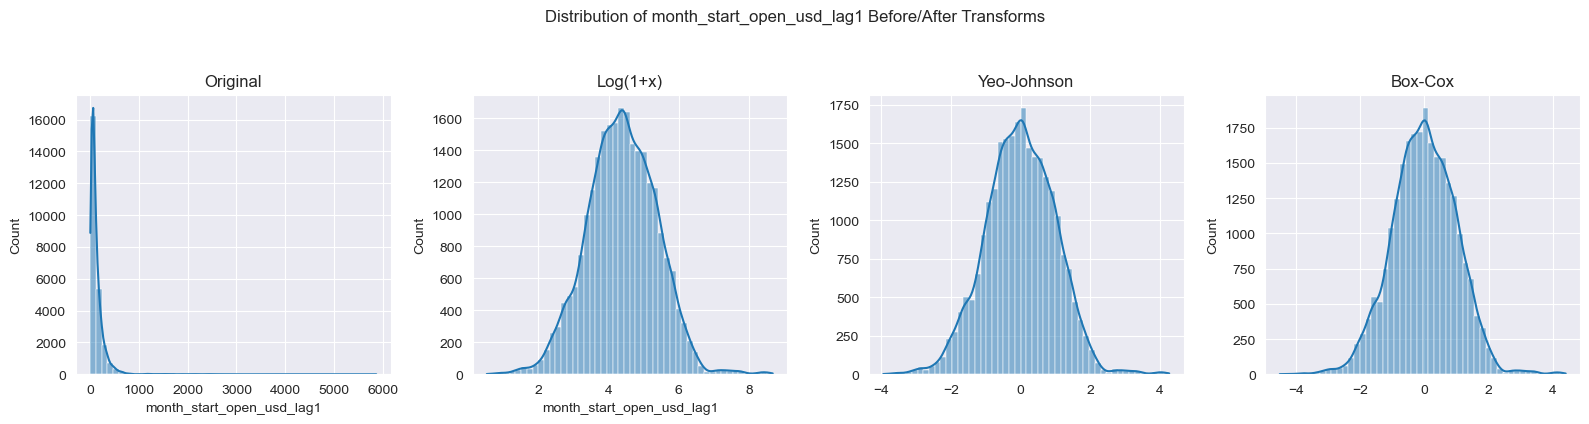

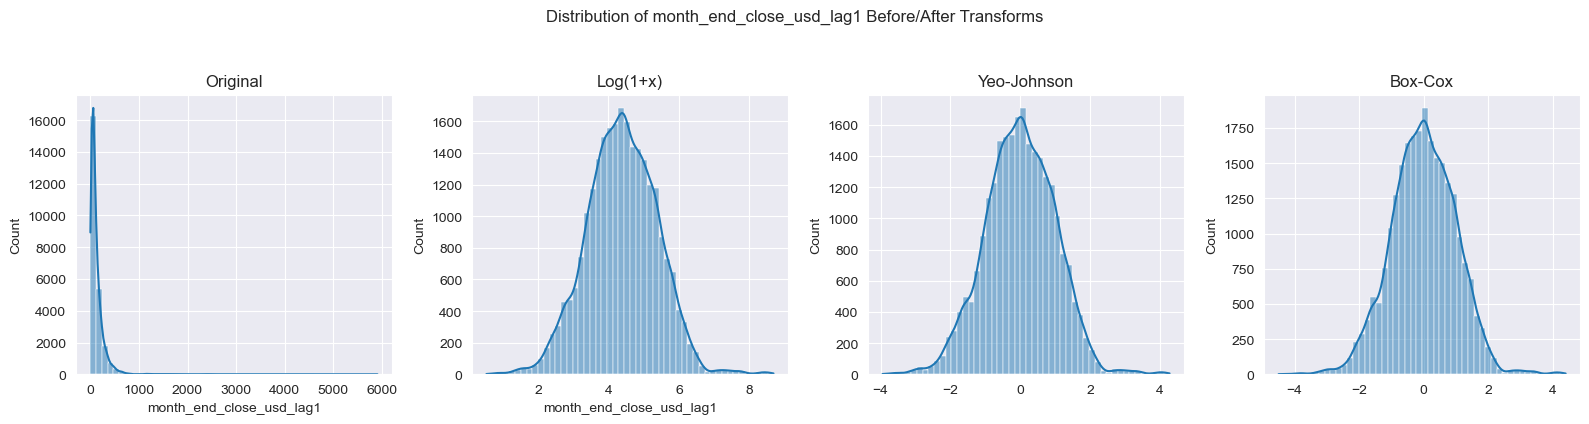

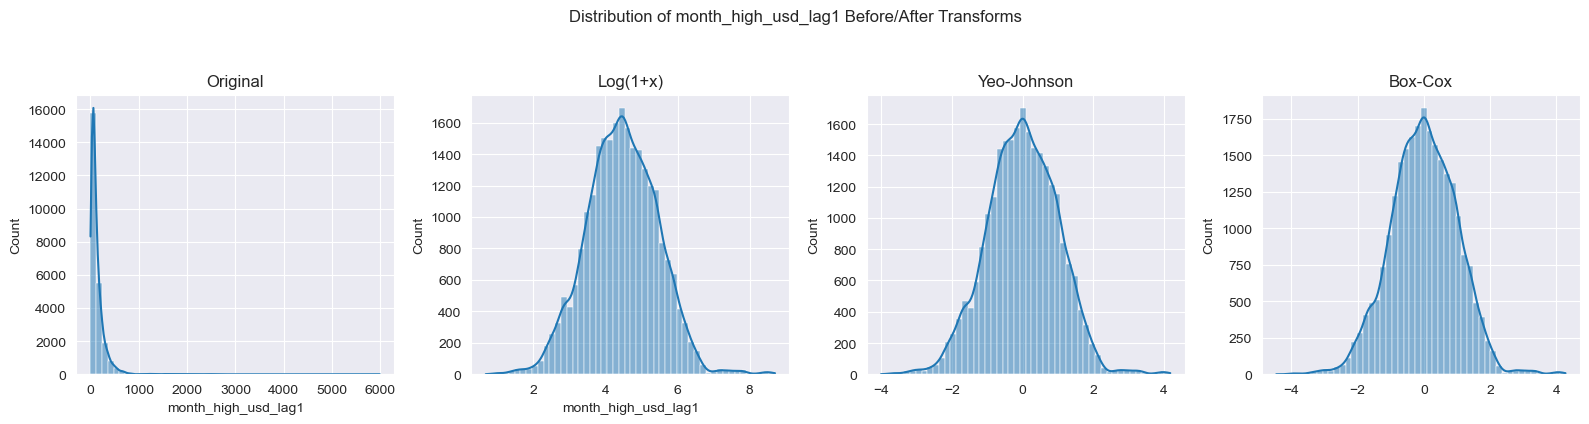

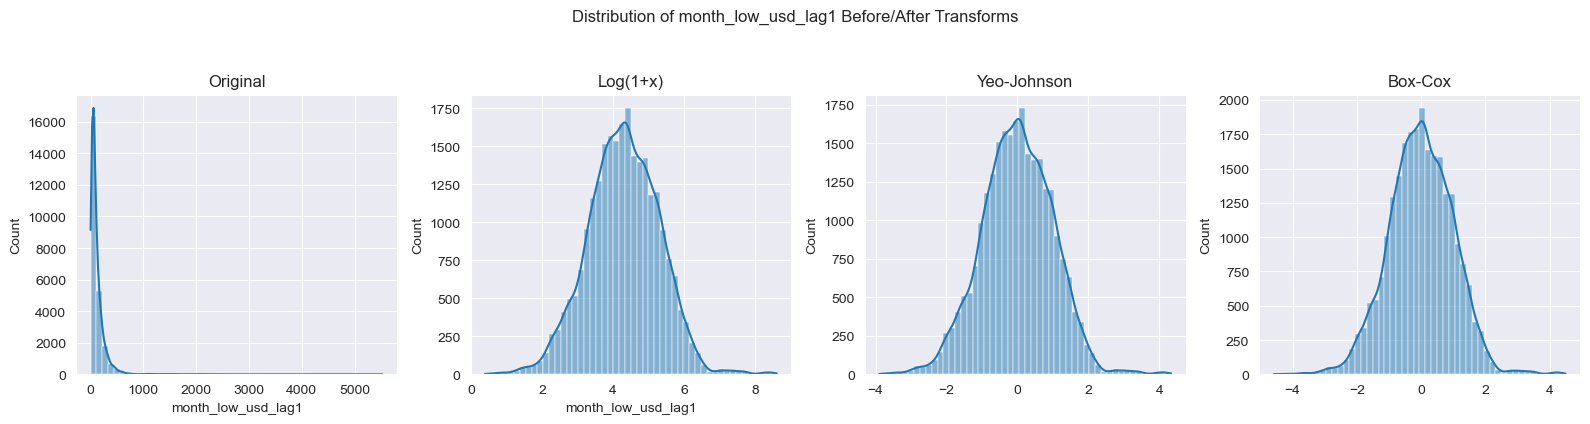

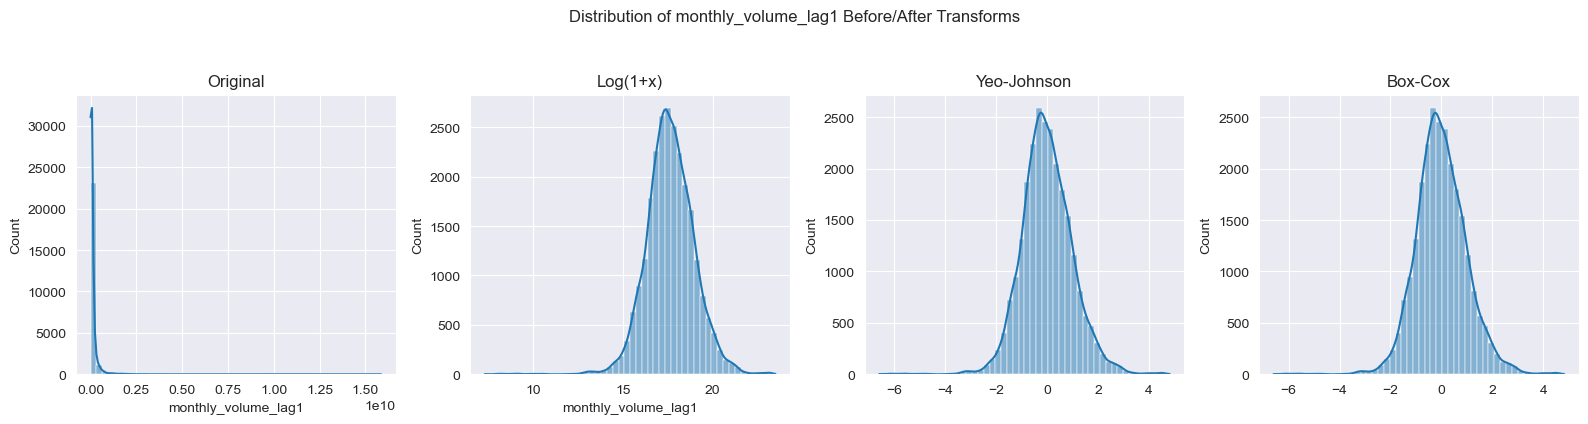

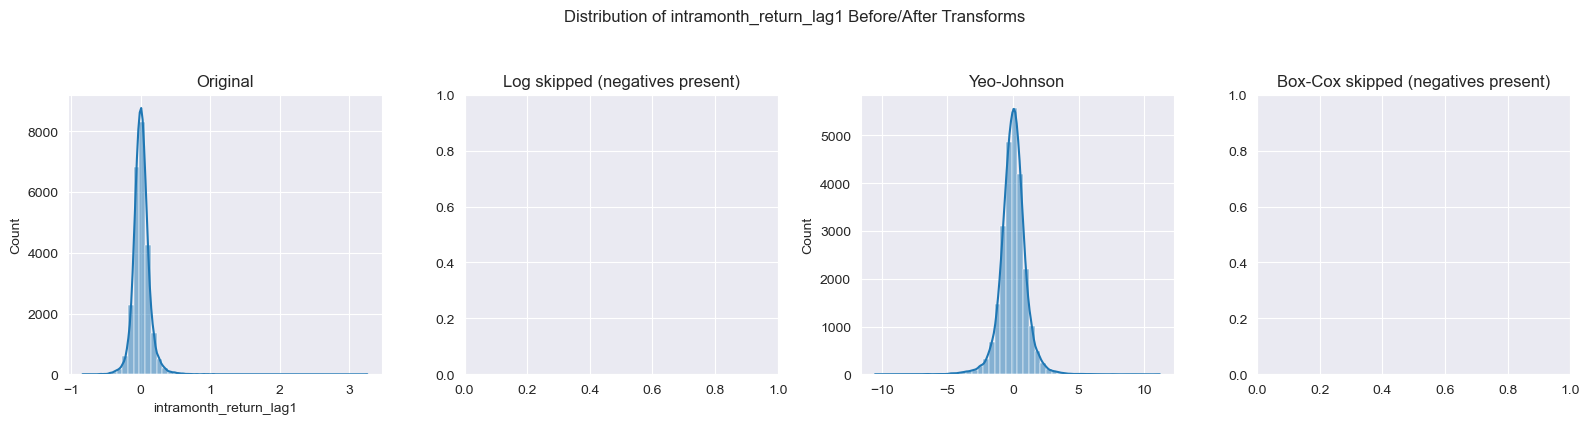

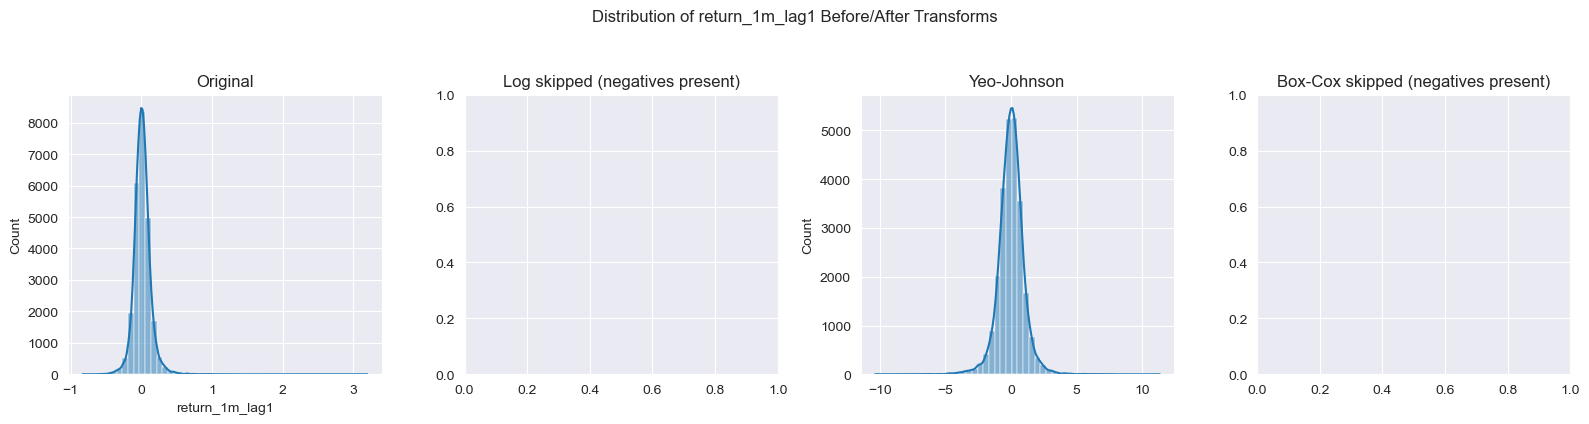

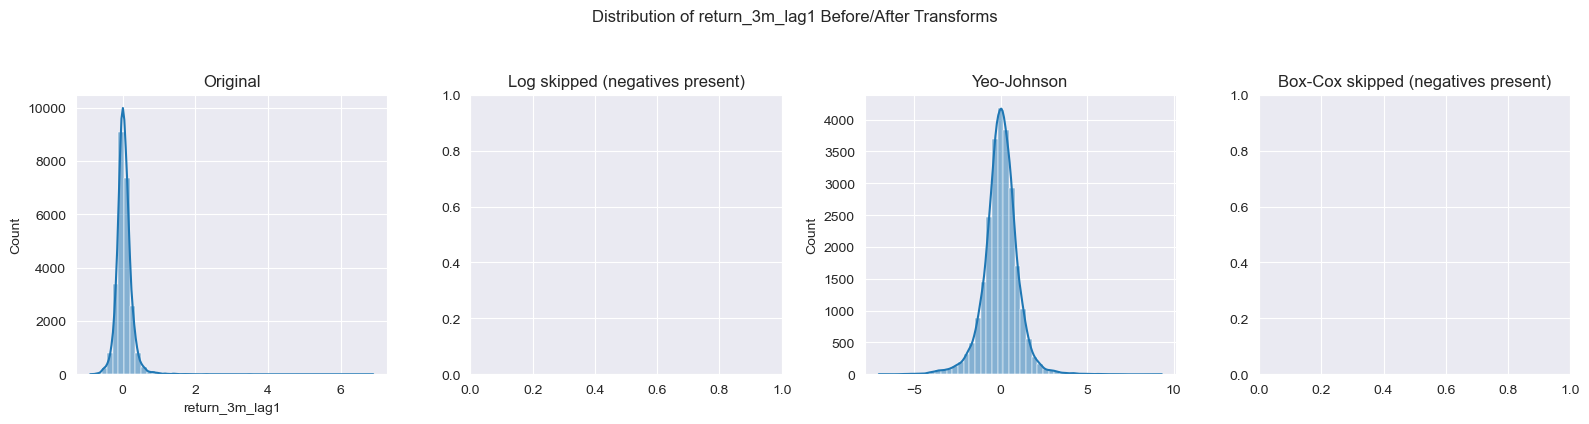

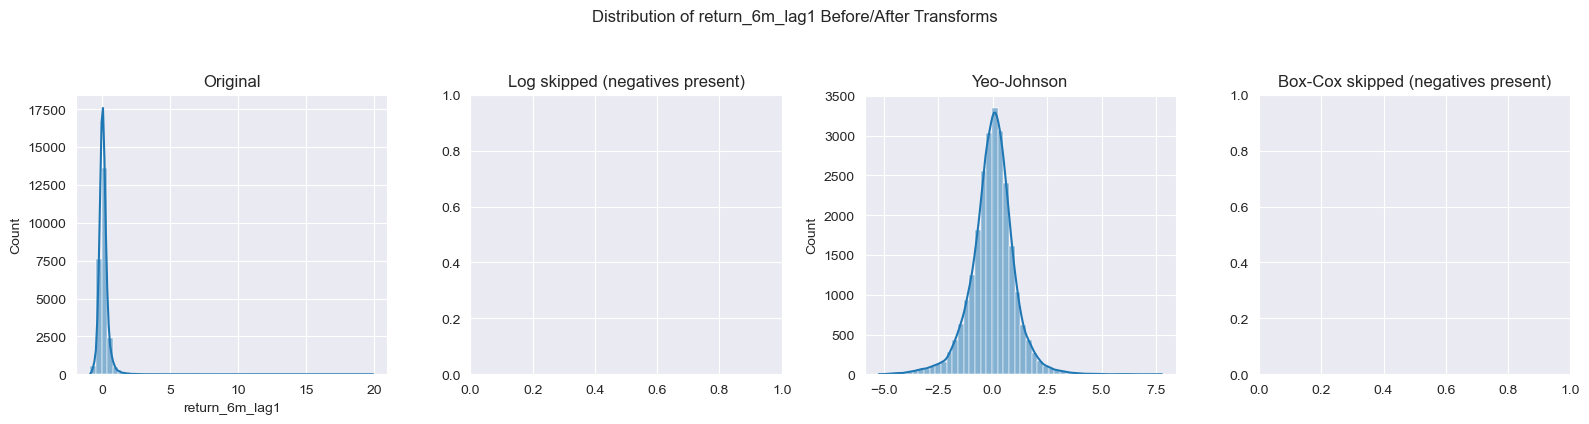

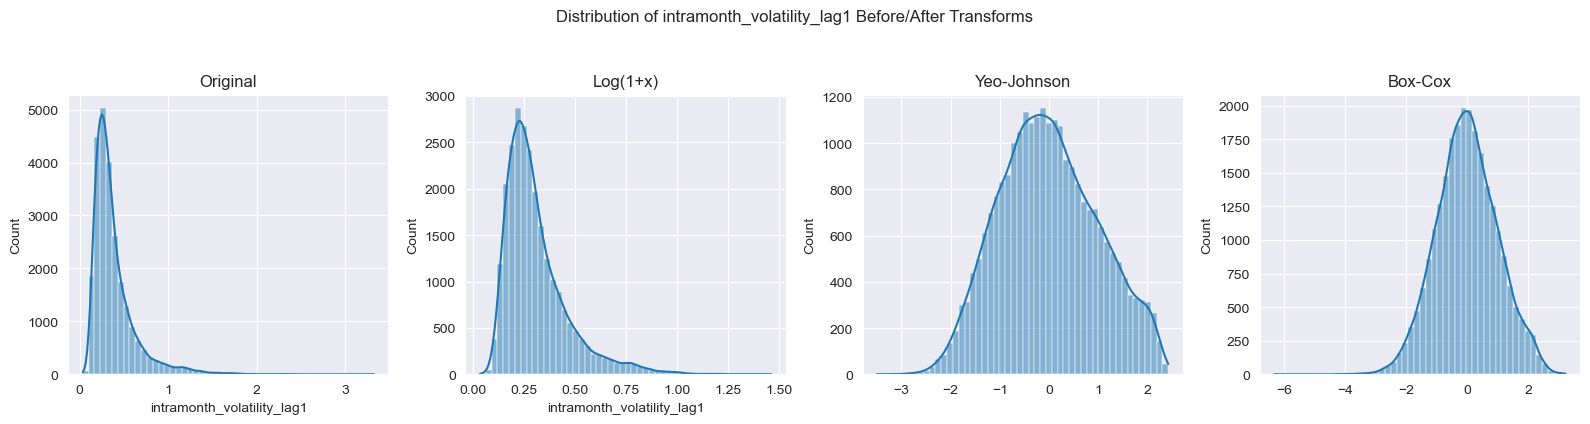

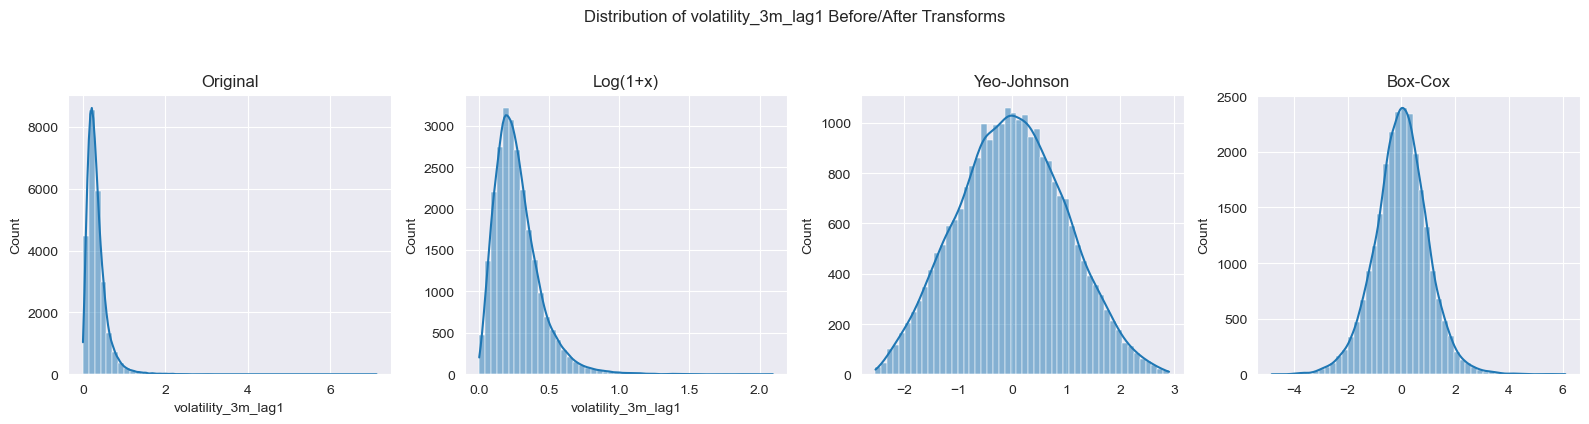

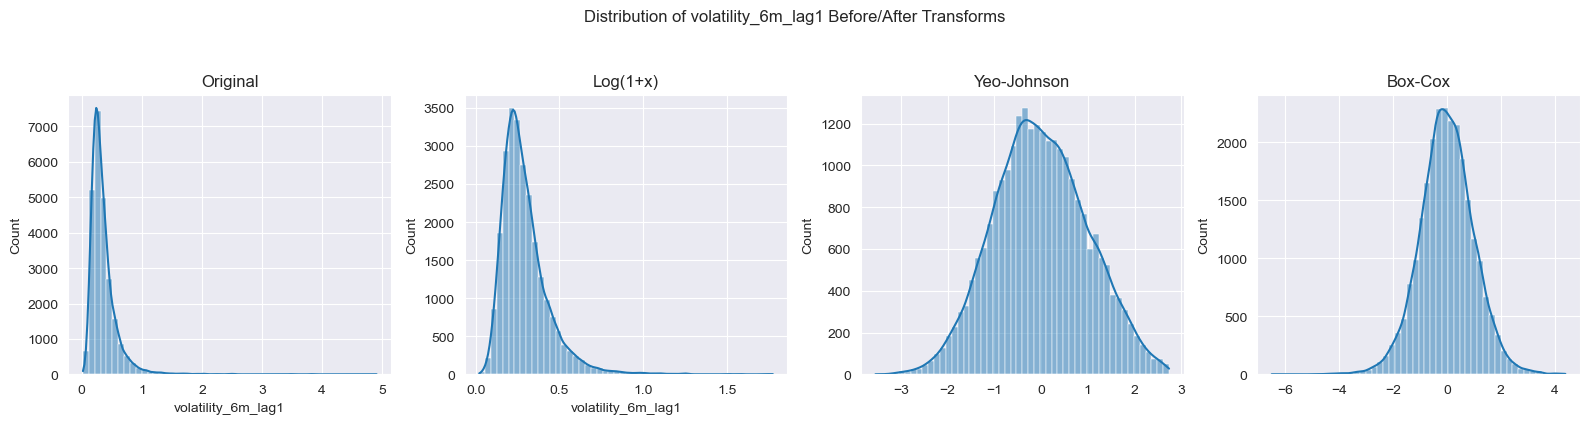

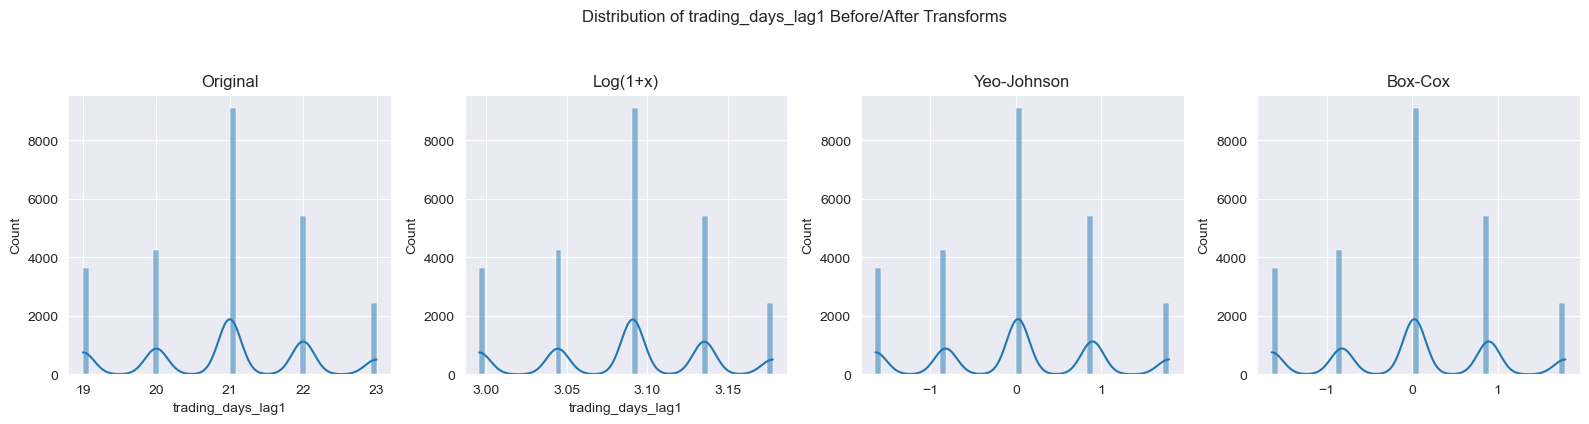

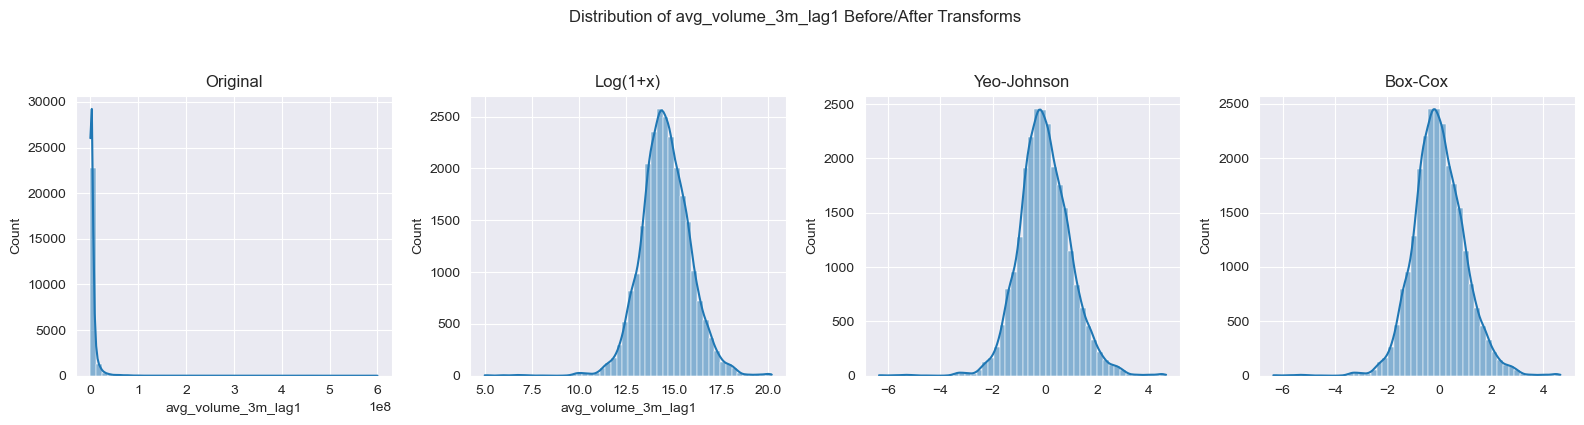

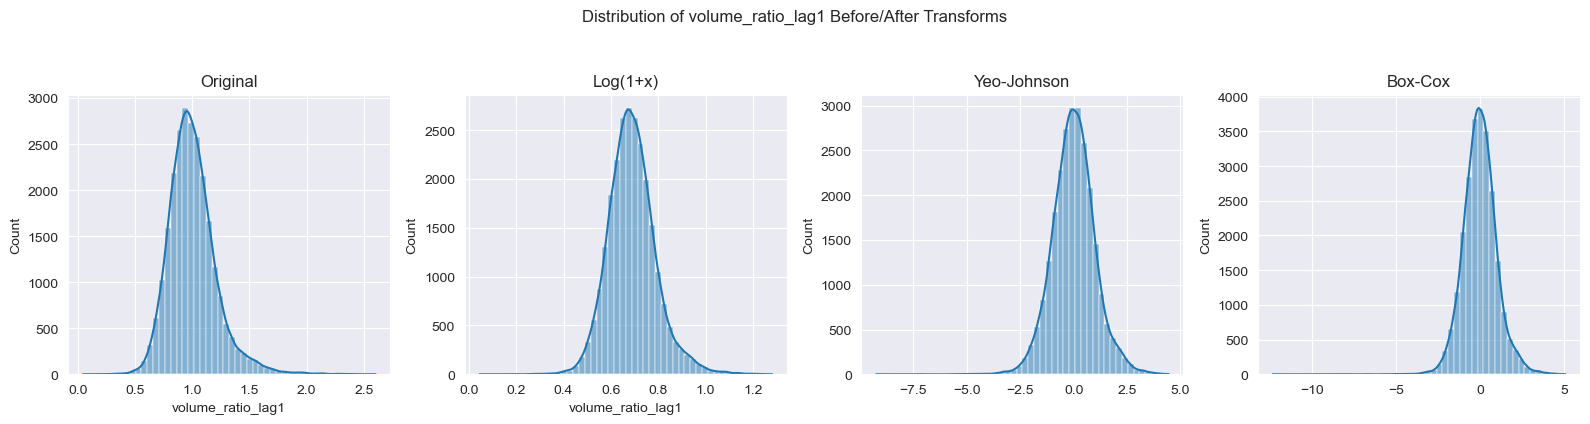

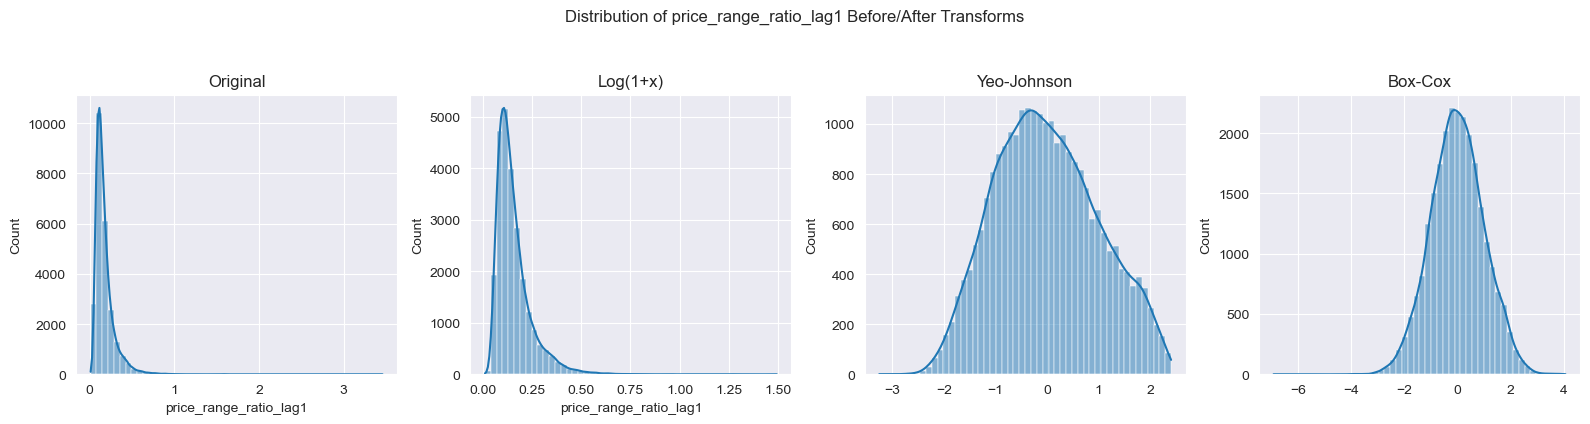

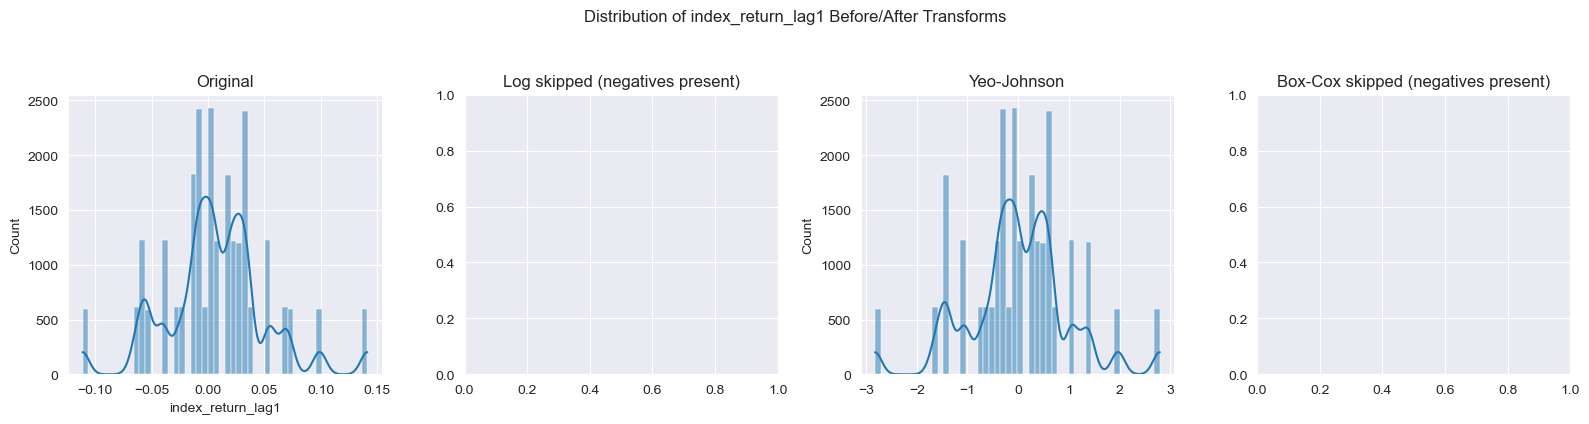

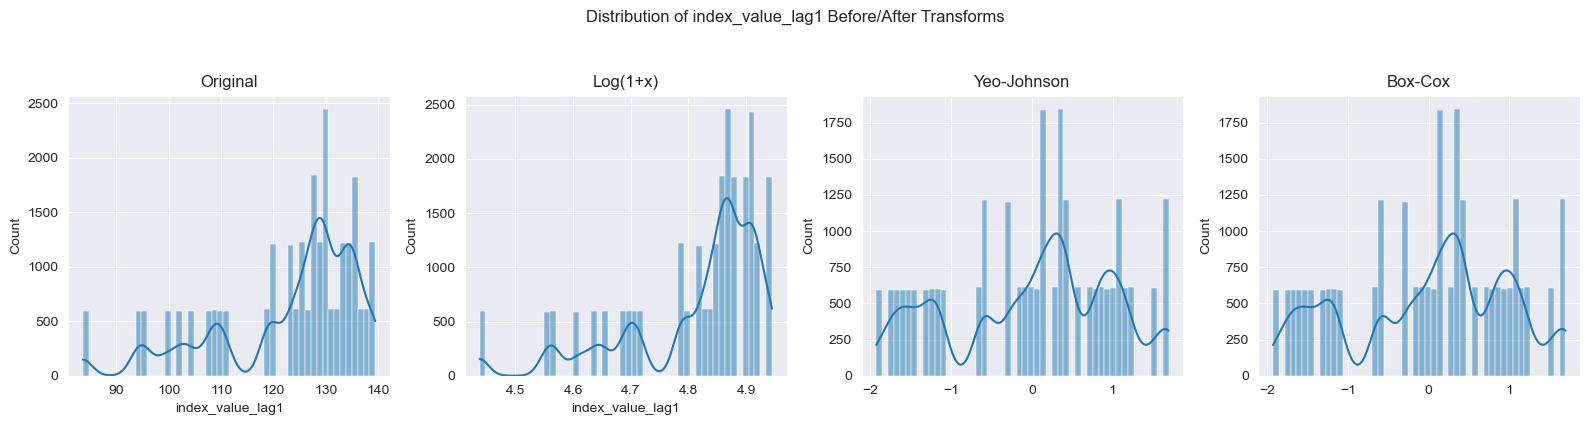

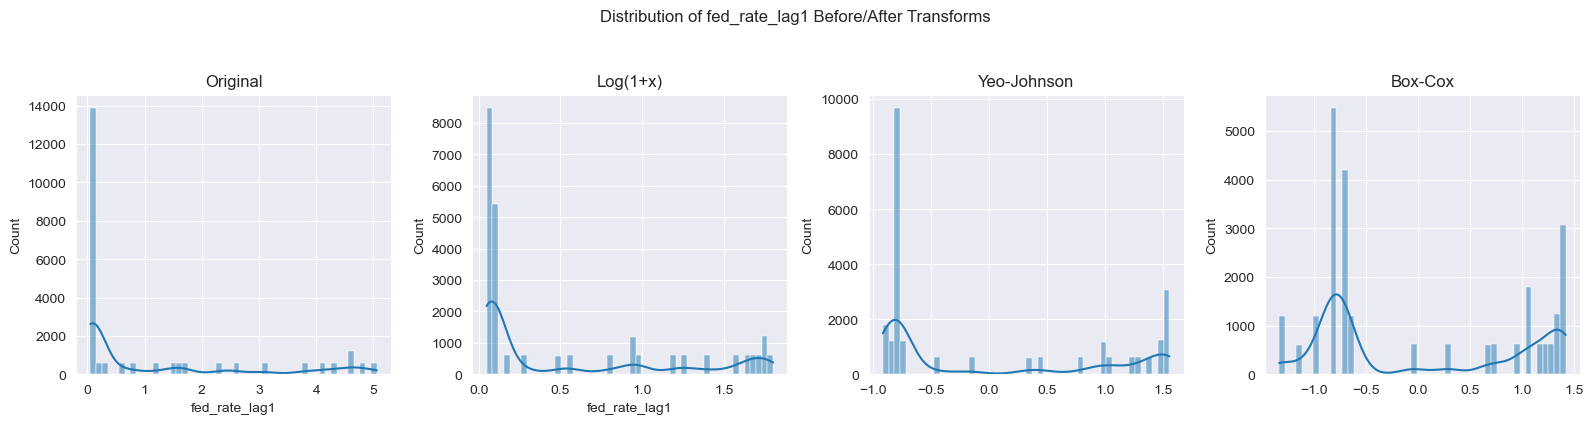

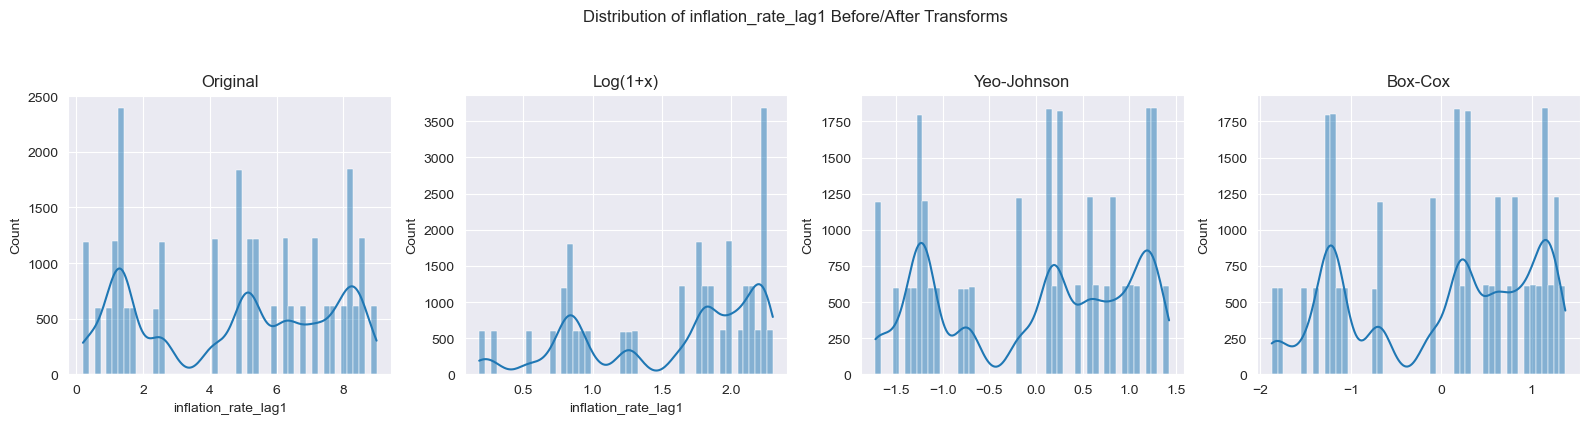

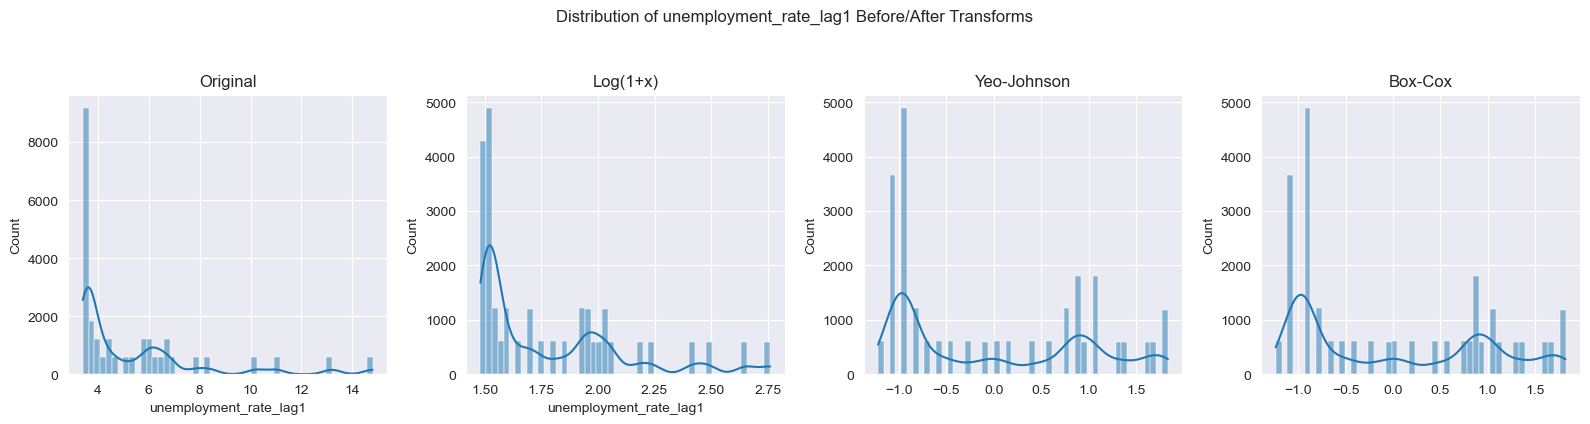

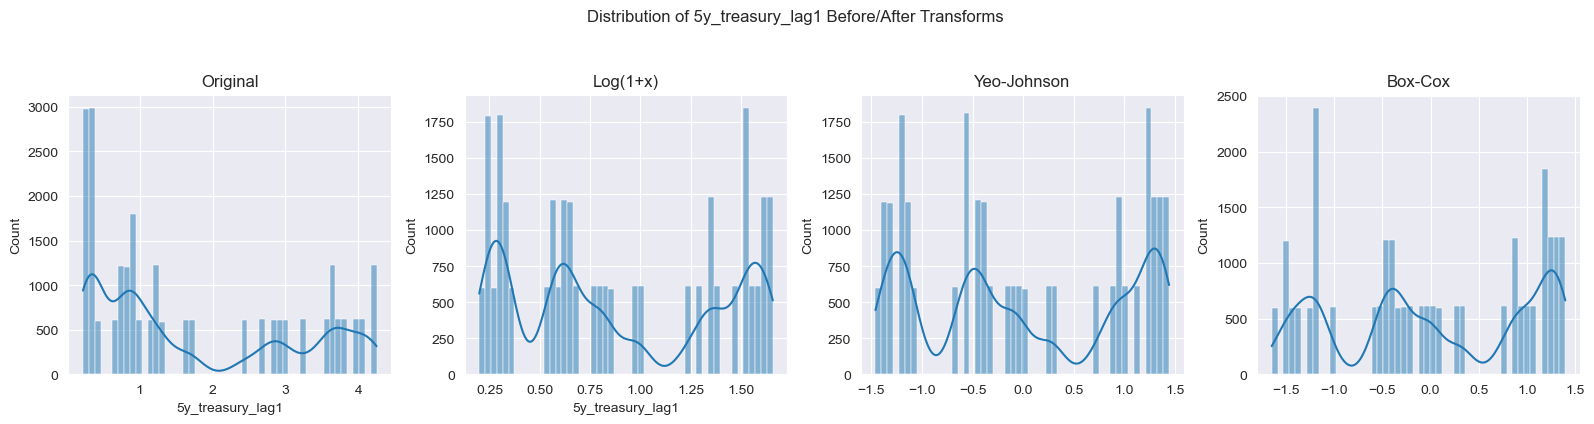

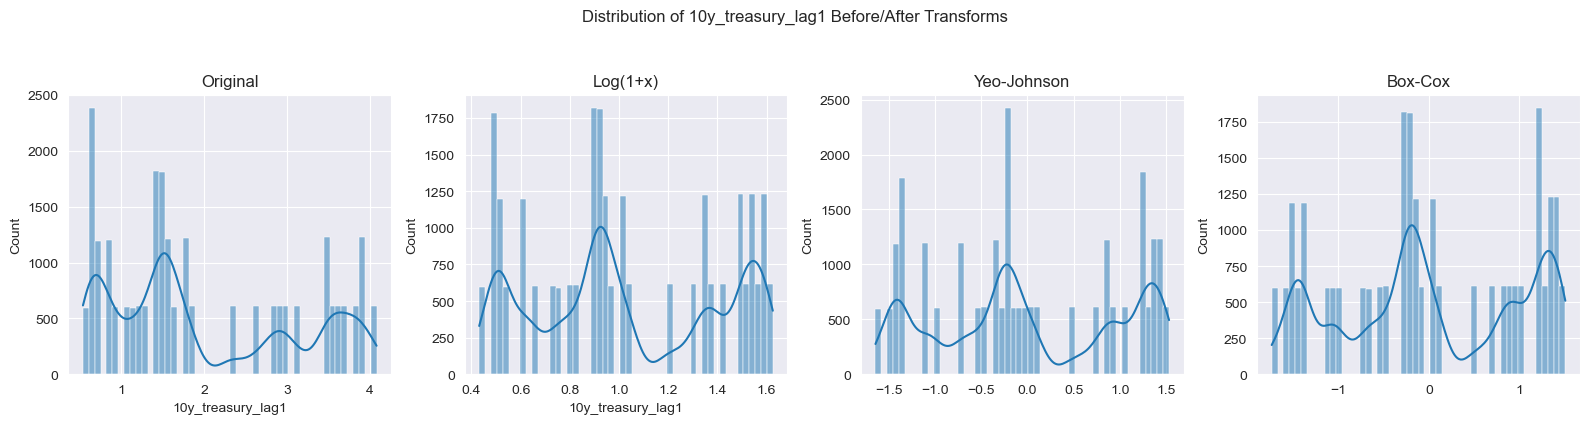

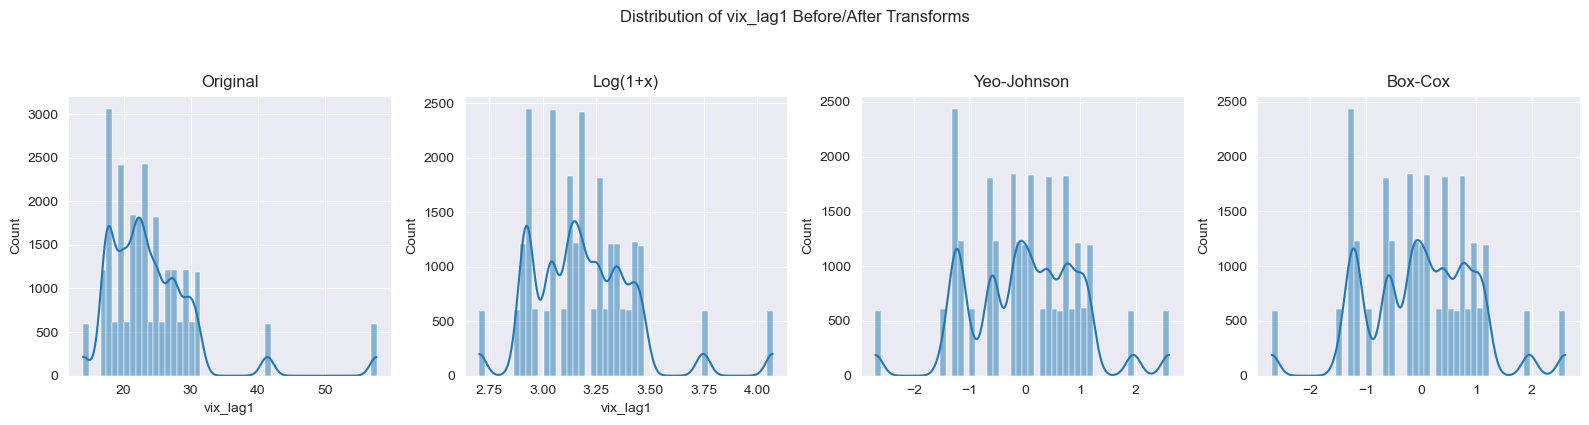

In [115]:
for col in df_train_num_lag.columns:
    if col not in ["stock_id", "month_id"]:
        compare_transforms(df_train_num_lag, col)

**NOTE**

As can be seen from the above graphs, most of the numerical features benefit from transformation as they become more normally distributed. However, since there are many features, we shall only choose a subset of them for transformation. Below are the list of chosen features for transformation:

In [116]:
to_transform = [
    "month_end_close_usd_lag1",
    "month_high_usd_lag1",
    "return_1m_lag1",
    "intramonth_volatility_lag1",
    "volatility_6m_lag1",
    "trading_days_lag1",
    "volume_ratio_lag1",
    "price_range_ratio_lag1",
    "index_return_lag1",
    "fed_rate_lag1",
    "unemployment_rate_lag1",
    "vix_lag1",
    "yield_slope",
    "term_spread"
]

Next, we shall quantify the effects of the transformation to get the best transformation method for teach of the feature.

In [117]:
def _qq_rmse(a: np.ndarray) -> float:
    """RMSE between sample quantiles and fitted normal line in a Q–Q plot."""
    a = np.asarray(a)
    a = a[np.isfinite(a)]
    (osm, osr), (slope, intercept, r) = stats.probplot(a, dist="norm")
    pred = slope * osm + intercept
    return float(np.sqrt(np.mean((osr - pred) ** 2)))

def evaluate_transformations(
    s: pd.Series,
    sample_for_tests: int = 5000,
    random_state: int = 123,
    feature_name: str | None = None,
) -> pd.DataFrame:
    """
    Try multiple transformations on a numeric Series and score normality.

    Parameters
    ----------
    s : pd.Series
        Numeric series (will drop NaNs and non-finite values).
    sample_for_tests : int
        Max sample size for Shapiro/normality tests (for speed/stability).
    random_state : int
        RNG seed for sampling.
    plot : bool
        If True, show histograms+KDE for each transformed variant.
    feature_name : str | None
        Optional label for plot titles.

    Returns
    -------
    pd.DataFrame
        Table of metrics for each transform, sorted by a composite score.
    """
    name = feature_name or getattr(s, "name", "feature")
    x = pd.to_numeric(s, errors="coerce").dropna().values
    x = x[np.isfinite(x)]
    n = x.size
    if n == 0:
        raise ValueError("Series has no finite values after cleaning.")

    rng = np.random.default_rng(random_state)
    # sample for normality tests
    idx = rng.choice(n, size=min(sample_for_tests, n), replace=False)
    xs = x[idx]

    transforms = {"Original": x}

    # log1p allowed if all values > -1 (strictly, you usually want x >= 0)
    if np.min(x) > -1.0:
        transforms["Log1p"] = np.log1p(x)

    # Yeo–Johnson (handles negative values)
    pt_yj = PowerTransformer(method="yeo-johnson")
    transforms["Yeo-Johnson"] = pt_yj.fit_transform(x.reshape(-1, 1)).ravel()

    # Box–Cox only valid if all values > 0
    if np.min(x) > 0:
        pt_bc = PowerTransformer(method="box-cox")
        transforms["Box-Cox"] = pt_bc.fit_transform(x.reshape(-1, 1)).ravel()

    rows = []
    for label, arr in transforms.items():
        arr = arr[np.isfinite(arr)]
        # stats
        sk = stats.skew(arr, bias=False)
        ku = stats.kurtosis(arr, fisher=False, bias=False)  # 3 for normal
        # Shapiro (on sample)
        a_sample = arr if arr.size <= sample_for_tests else arr[rng.choice(arr.size, sample_for_tests, replace=False)]
        try:
            sh_p = stats.shapiro(a_sample).pvalue
        except Exception:
            sh_p = np.nan
        # D'Agostino (omni normality test)
        try:
            dag_p = stats.normaltest(a_sample).pvalue
        except Exception:
            dag_p = np.nan
        # Q–Q RMSE
        qq = _qq_rmse(arr)
        rows.append(
            dict(Transform=label, Skewness=sk, Kurtosis=ku, Shapiro_p=sh_p, DAgostino_p=dag_p, QQ_RMSE=qq)
        )

    out = pd.DataFrame(rows)

    # Composite score: smaller |skew| and |kurt-3| and QQ_RMSE; larger p-values.
    # Normalize each metric to [0,1] and combine (you can tweak weights).
    def _minmax(v, invert=False):
        v = np.asarray(v, float)
        v = (v - np.nanmin(v)) / (np.nanmax(v) - np.nanmin(v) + 1e-12)
        return 1 - v if invert else v

    out["abs_skew"] = out["Skewness"].abs()
    out["abs_kurt_dev"] = (out["Kurtosis"] - 3.0).abs()

    score = (
        0.35 * _minmax(out["abs_skew"], invert=True)
        + 0.35 * _minmax(out["abs_kurt_dev"], invert=True)
        + 0.20 * _minmax(out["QQ_RMSE"], invert=True)
        + 0.05 * _minmax(out["Shapiro_p"])       # larger is better
        + 0.05 * _minmax(out["DAgostino_p"])     # larger is better
    )
    out["CompositeScore"] = score
    out = out.sort_values("CompositeScore", ascending=False).reset_index(drop=True)

    return out


In [118]:
# Test output
results = evaluate_transformations(df_transform["month_end_close_usd_lag1"])
print(results)

     Transform   Skewness    Kurtosis     Shapiro_p   DAgostino_p     QQ_RMSE  \
0        Log1p   0.028312    3.426864  2.030378e-07  1.327756e-05    0.054545   
1  Yeo-Johnson  -0.001117    3.409758  7.233366e-09  1.818434e-06    0.054206   
2      Box-Cox   0.002893    3.579396  4.257246e-10  7.827189e-10    0.062025   
3     Original  11.862090  203.332723  1.706483e-84  0.000000e+00  199.273385   

    abs_skew  abs_kurt_dev  CompositeScore  
0   0.028312      0.426864    9.991670e-01  
1   0.001117      0.409758    9.086290e-01  
2   0.002893      0.579396    8.997505e-01  
3  11.862090    200.332723    3.224088e-14  


Skewness (→ 0 is better)

Kurtosis (→ 3 is better)

Shapiro–Wilk p-value (→ higher is better; auto-samples for speed)

D’Agostino’s normality p-value (→ higher is better)

Q–Q RMSE (goodness vs normal quantiles; → lower is better)

**Collect Best Transformation Results**

In [122]:
df_transform.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24867 entries, 0 to 24866
Data columns (total 52 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   stock_id                               24867 non-null  object 
 1   month_id                               24867 non-null  object 
 2   month_end_close_usd_lag1               24867 non-null  float64
 3   month_high_usd_lag1                    24867 non-null  float64
 4   return_1m_lag1                         24867 non-null  float64
 5   intramonth_volatility_lag1             24867 non-null  float64
 6   volatility_6m_lag1                     24867 non-null  float64
 7   trading_days_lag1                      24867 non-null  float64
 8   volume_ratio_lag1                      24867 non-null  float64
 9   price_range_ratio_lag1                 24867 non-null  float64
 10  index_return_lag1                      24867 non-null  float64
 11  fe

In [123]:
results_list = []

for feat in to_transform:
    res = evaluate_transformations(df_transform[feat], feature_name=feat)
    # record best method
    best = res.iloc[0]
    results_list.append({
        "Feature": feat,
        "BestTransform": best["Transform"],
        "CompositeScore": best["CompositeScore"],
        "Skewness": best["Skewness"],
        "Kurtosis": best["Kurtosis"],
        "Shapiro_p": best["Shapiro_p"],
        "DAgostino_p": best["DAgostino_p"],
        "QQ_RMSE": best["QQ_RMSE"]
    })

df_best_transforms = pd.DataFrame(results_list)

# Show summary
print(df_best_transforms)


                       Feature BestTransform  CompositeScore  Skewness  \
0     month_end_close_usd_lag1         Log1p        0.999167  0.028312   
1          month_high_usd_lag1   Yeo-Johnson        0.967215 -0.002340   
2               return_1m_lag1         Log1p        0.780603 -0.550076   
3   intramonth_volatility_lag1       Box-Cox        1.000000  0.001180   
4           volatility_6m_lag1   Yeo-Johnson        0.996069  0.077300   
5            trading_days_lag1   Yeo-Johnson        0.731098 -0.021039   
6            volume_ratio_lag1   Yeo-Johnson        0.748532 -0.054074   
7       price_range_ratio_lag1       Box-Cox        1.000000 -0.003131   
8            index_return_lag1         Log1p        0.816453  0.033706   
9                fed_rate_lag1       Box-Cox        0.511822  0.336917   
10      unemployment_rate_lag1       Box-Cox        0.765726  0.352947   
11                    vix_lag1   Yeo-Johnson        0.944513 -0.030774   
12                 yield_slope      Or

**Apply Best Transformation to Features**

In [124]:
def apply_best_transformations(df, summary):
    df_out = df.copy()
    for _, row in summary.iterrows():
        feat = row["Feature"]
        transform = row["BestTransform"]
        if transform == "Log1p":
            df_out[feat] = np.log1p(df_out[feat])
        elif transform == "Yeo-Johnson":
            pt = PowerTransformer(method="yeo-johnson")
            df_out[feat] = pt.fit_transform(df_out[[feat]])
        elif transform == "Box-Cox":
            pt = PowerTransformer(method="box-cox")
            df_out[feat] = pt.fit_transform(df_out[[feat]])
        # if Original, leave as is
    return df_out

df_transform = apply_best_transformations(df_transform, df_best_transforms)


In [125]:
df_transform.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24867 entries, 0 to 24866
Data columns (total 52 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   stock_id                               24867 non-null  object 
 1   month_id                               24867 non-null  object 
 2   month_end_close_usd_lag1               24867 non-null  float64
 3   month_high_usd_lag1                    24867 non-null  float64
 4   return_1m_lag1                         24867 non-null  float64
 5   intramonth_volatility_lag1             24867 non-null  float64
 6   volatility_6m_lag1                     24867 non-null  float64
 7   trading_days_lag1                      24867 non-null  float64
 8   volume_ratio_lag1                      24867 non-null  float64
 9   price_range_ratio_lag1                 24867 non-null  float64
 10  index_return_lag1                      24867 non-null  float64
 11  fe

In [126]:
df_transform.to_csv("features_transformed.csv", index=False)

## 5. Classification Model (Our Best Model: Logistic Regression)

### Helper Functions

In [140]:
# ======================================================
# Helpers
# ======================================================

def to_month(s: pd.Series) -> pd.Series:
    """Normalize month_id into first-of-month Timestamps."""
    s = s.astype(str).str.replace("_", "-", regex=False)
    dt = pd.to_datetime(s, errors="coerce")
    m = dt.dt.to_period("M").dt.to_timestamp()
    if m.isna().any():
        mask = m.isna()
        m.loc[mask] = pd.to_datetime(s[mask], format="%Y%m", errors="coerce")\
                        .dt.to_period("M").dt.to_timestamp()
    return m

def month_walk_forward_indices(df, month_col="month_dt", min_train=12, n_folds=5, gap=1, val_window=1):
    """
    Walk-forward CV splitter with configurable validation window size.
    """
    months = np.array(sorted(df[month_col].unique()))
    end_points = range(len(months)-n_folds, len(months))
    for end in end_points:
        train_months = months[: max(end-gap, min_train)]
        val_months   = months[end:end+val_window]
        train_idx = df.index[df[month_col].isin(train_months)].to_numpy()
        val_idx   = df.index[df[month_col].isin(val_months)].to_numpy()
        yield (train_idx, val_idx)

def normalize_month_id(s: pd.Series) -> pd.Series:
    """Convert month_id to 'YYYY-MM' string for consistent joins."""
    s = s.astype(str).str.replace("_", "-", regex=False)
    dt = pd.to_datetime(s, errors="coerce")
    return dt.dt.to_period("M").astype(str)  # e.g., '2020-02'


# ======================================================
# Modular Functions
# ======================================================

def build_pipeline(model=None):
    """Return a pipeline with imputer + scaler + model."""
    if model is None:
        model = LogisticRegression(
            penalty="l1", solver="saga", max_iter=500,
            class_weight="balanced", C=1.0, random_state=42
        )
    return Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)
    ])


from sklearn.metrics import f1_score, roc_auc_score, classification_report

def run_walk_forward_with_preds(
    df,
    features,
    target="outperform_binary",
    model=None,
    min_train=12,
    n_folds=5,
    gap=1,
    val_window=1,
    threshold=0.5
):
    """
    Walk-forward CV that returns both metrics and predictions DataFrame.
    Now supports multi-month validation windows.
    """
    X = df[features]
    y = df[target].astype(float)

    pipe = build_pipeline(model)
    cv_splits = list(month_walk_forward_indices(
        df,
        month_col="month_dt",
        min_train=min_train,
        n_folds=n_folds,
        gap=gap,
        val_window=val_window  # <-- NEW parameter
    ))

    all_preds = []  # store predictions

    for fold, (train_idx, val_idx) in enumerate(cv_splits, 1):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val     = X.iloc[val_idx], y.iloc[val_idx]
        meta             = df.iloc[val_idx][["stock_id", "month_dt"]]

        pipe.fit(X_train, y_train)
        proba = pipe.predict_proba(X_val)[:, 1]
        preds = (proba >= threshold).astype(int)

        fold_df = meta.copy()
        fold_df["y_true"] = y_val.values
        fold_df["y_pred"] = preds
        fold_df["y_proba"] = proba
        fold_df["fold"] = fold
        all_preds.append(fold_df)

    preds_df = pd.concat(all_preds, ignore_index=True)
    return preds_df, cv_splits



def report_cv_from_preds(preds_df, scoring=None, detailed: bool = False):
    if scoring is None:
        scoring = ["accuracy", "precision", "recall", "f1", "roc_auc"]

    fold_metrics = []
    for fold, fold_df in preds_df.groupby("fold"):
        val_month = fold_df["month_dt"].iloc[0]
        y_true, y_pred, y_proba = fold_df["y_true"], fold_df["y_pred"], fold_df["y_proba"]

        metrics = {}
        if "accuracy" in scoring:
            metrics["accuracy"] = accuracy_score(y_true, y_pred)
        if "precision" in scoring:
            metrics["precision"] = precision_score(y_true, y_pred, zero_division=0)
        if "recall" in scoring:
            metrics["recall"] = recall_score(y_true, y_pred, zero_division=0)
        if "f1" in scoring:
            metrics["f1"] = f1_score(y_true, y_pred, zero_division=0)
        if "roc_auc" in scoring:
            metrics["roc_auc"] = roc_auc_score(y_true, y_proba) if len(y_true.unique()) > 1 else np.nan

        metrics["fold"] = fold
        metrics["val_month"] = val_month
        fold_metrics.append(metrics)

        if detailed:
            print(f"\nFold {fold} – Validation month: {val_month}")
            for k in scoring:
                if k in metrics:
                    print(f"{k:>9}: {metrics[k]:.4f}")

    # Average results
    results_df = pd.DataFrame(fold_metrics)
    print("\nAverage performance across folds:")
    for k in scoring:
        if k in results_df:
            mean, std = results_df[k].mean(), results_df[k].std()
            print(f"{k:>9}: {mean:.4f} (+/- {std:.4f})")

    return results_df


def prepare_train_test(df, test_month, target="outperform_binary", df_train_target=None):
    """
    Split DataFrame into train/test sets based on a holdout month.
    If `target` is missing or all NaN, merge labels from df_train_target.
    """
    df = df.copy()
    df["month_dt"] = to_month(df["month_id"])
    df["month_id"] = normalize_month_id(df["month_id"])
    df_train_target["month_id"] = normalize_month_id(df_train_target["month_id"])


    # Merge in target labels if needed
    if target not in df.columns or df[target].isna().all():
        if df_train_target is None:
            raise KeyError(f"Target '{target}' not in df and df_train_target not provided.")

        # Deduplicate label table
        label_tbl = (
            df_train_target[["stock_id", "month_id", target]]
            .dropna(subset=["stock_id", "month_id"])
            .sort_values(["stock_id", "month_id"])
            .drop_duplicates(subset=["stock_id", "month_id"], keep="last")
        )

        df = df.merge(label_tbl, on=["stock_id", "month_id"], how="left")
        display(df.head())

    # Train/test split
    train_df = df[df["month_dt"] < test_month].reset_index(drop=True)
    test_df  = df[df["month_dt"] == test_month].reset_index(drop=True)

    # Feature columns
    id_cols = {"stock_id", "month_id", "month_dt", "lag_month_id", target, "excess_return"}
    features = [
        c for c in train_df.columns
        if c not in id_cols and np.issubdtype(train_df[c].dtype, np.number)
    ]

    X = train_df[features]
    y = train_df[target].astype(float)
    X_test = test_df[features]
    y_test = test_df[target].astype(float) if target in test_df else None

    return train_df, test_df, X, y, X_test, y_test, features


from sklearn.metrics import confusion_matrix, classification_report

def preds_to_confusion(preds_df, average="binary", output="dict"):
    """
    Convert predictions DataFrame into confusion matrices and classification reports per fold.

    Args:
        preds_df : DataFrame with columns ['y_true', 'y_pred', 'fold']
        average  : averaging method for classification report (binary, macro, weighted)
        output   : 'dict' for Python dict, 'print' for text reports, 'df' for DataFrame

    Returns:
        results : dict or DataFrame with confusion matrices and reports per fold
    """
    results = {}

    for fold, fold_df in preds_df.groupby("fold"):
        y_true, y_pred = fold_df["y_true"], fold_df["y_pred"]

        cm = confusion_matrix(y_true, y_pred, labels=[0,1])
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

        results[fold] = {
            "val_month": fold_df["month_dt"].iloc[0],
            "confusion_matrix": cm,
            "classification_report": report
        }

        if output == "print":
            print(f"\n=== Fold {fold} – Validation month: {results[fold]['val_month']} ===")
            print("Confusion Matrix:")
            print(cm)
            print("\nClassification Report:")
            print(classification_report(y_true, y_pred, zero_division=0))

    if output == "df":
        # flatten reports into a DataFrame
        rows = []
        for fold, d in results.items():
            rep = d["classification_report"]
            for label, metrics in rep.items():
                if isinstance(metrics, dict):
                    rows.append({
                        "fold": fold,
                        "val_month": d["val_month"],
                        "class": label,
                        **metrics
                    })
        return pd.DataFrame(rows)

    return results



def run_walk_forward_with_tuning(
    df, features, target="outperform_binary",
    model_class=LogisticRegression,
    param_grid=None,
    min_train=12, n_folds=5, gap=1,
    threshold=0.5, scoring="roc_auc"
):
    """
    Walk-forward CV with hyperparameter tuning inside each fold.
    """

    X = df[features]
    y = df[target].astype(int)

    cv_splits = list(month_walk_forward_indices(
        df, month_col="month_dt",
        min_train=min_train, n_folds=n_folds, gap=gap
    ))

    all_preds = []
    all_best_params = []

    for fold, (train_idx, val_idx) in enumerate(cv_splits, 1):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val     = X.iloc[val_idx], y.iloc[val_idx]
        meta             = df.iloc[val_idx][["stock_id", "month_dt"]]

        # 🔹 GridSearch inside each fold
        base_model = model_class(max_iter=2000, solver="saga", random_state=42)
        search = GridSearchCV(
            base_model,
            param_grid=param_grid,
            scoring=scoring,
            cv=3,
            n_jobs=-1,
            verbose=1
        )
        search.fit(X_train, y_train)

        best_model = search.best_estimator_
        all_best_params.append(search.best_params_)

        # Predictions
        proba = best_model.predict_proba(X_val)[:, 1]
        preds = (proba >= threshold).astype(int)

        fold_df = meta.copy()
        fold_df["y_true"] = y_val.values
        fold_df["y_pred"] = preds
        fold_df["y_proba"] = proba
        fold_df["fold"] = fold
        all_preds.append(fold_df)

        print(f"\nFold {fold} – Best params: {search.best_params_}")

    preds_df = pd.concat(all_preds, ignore_index=True)

    return preds_df, cv_splits, all_best_params

### Initialise Training Dataframes

In [141]:
df_original= pd.read_csv("features_reduced.csv")
df_transformed = pd.read_csv("features_transformed.csv")

test_month = pd.Timestamp("2023-06-01")

# Merge with df_train_target to retrieve target variable and split based on test_month 
train_df, test_df, X, y, X_test, y_test, features = prepare_train_test(
    df_original, test_month, df_train_target=df_train_target
)

,stock_id,month_id,month_end_close_usd_lag1,month_high_usd_lag1,return_1m_lag1,intramonth_volatility_lag1,volatility_6m_lag1,trading_days_lag1,volume_ratio_lag1,price_range_ratio_lag1,...,sector_Finance_X_fed_rate_lag1,sector_Real_Estate_X_fed_rate_lag1,sizeord_X_ret1m,finstr_X_vix,vol1m_X_liq1m,intramonth_vol_X_vix,term_spread,mkt_ret_div_vix,month_dt,outperform_binary
0,US001,2020-02,107.326,123.486,-0.100669,0.253304,0.201608,21.0,1.207,0.136875,...,0.0,0.0,-0.201338,13.94,2.141413e+07,1.178477e+09,-0.03,-0.000463,2020-02-01,0
1,US001,2020-03,101.868,111.641,-0.050854,0.259208,0.192782,19.0,1.126,0.110905,...,0.0,0.0,-0.101708,19.63,2.366929e+07,1.792492e+09,-0.45,-0.002703,2020-03-01,1
2,US001,2020-04,93.178,105.622,-0.085299,0.892709,0.213051,22.0,1.509,0.268931,...,0.0,0.0,-0.170598,57.74,1.588405e+08,1.027373e+10,0.05,-0.001929,2020-04-01,1
3,US001,2020-05,103.697,111.314,0.112885,0.408352,0.291241,21.0,0.803,0.242954,...,0.0,0.0,0.225770,41.45,4.020179e+07,4.080705e+09,0.57,0.003409,2020-05-01,0
4,US001,2020-06,107.841,110.206,0.039966,0.419368,0.292040,20.0,0.817,0.203186,...,0.0,0.0,0.079932,30.90,4.335435e+07,3.194448e+09,0.60,0.002305,2020-06-01,0


### Logistic Regression Training

First we initialise a baseline model

In [142]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression with L1 penalty
l1_model = LogisticRegression(
    max_iter=1000,
    solver="saga",         
    penalty="l1",
    class_weight="balanced",
    random_state=42,
)


# Cross validates over multiple months by using splits of data up to each validation month.
# E.g. Validation month 2023-01 is trained all months prior to Jan, preventing look-ahead bias. 
preds, cv_splits = run_walk_forward_with_preds(
    train_df,
    features,
    model=l1_model
)

metrics = report_cv_from_preds(preds, detailed=True)



Fold 1 – Validation month: 2023-01-01 00:00:00
 accuracy: 0.5252
precision: 0.5464
   recall: 0.9191
       f1: 0.6853
  roc_auc: 0.4276

Fold 2 – Validation month: 2023-02-01 00:00:00
 accuracy: 0.6049
precision: 0.0000
   recall: 0.0000
       f1: 0.0000
  roc_auc: 0.4581

Fold 3 – Validation month: 2023-03-01 00:00:00
 accuracy: 0.4894
precision: 0.4694
   recall: 0.0740
       f1: 0.1278
  roc_auc: 0.4930

Fold 4 – Validation month: 2023-04-01 00:00:00
 accuracy: 0.4699
precision: 0.0000
   recall: 0.0000
       f1: 0.0000
  roc_auc: 0.4256

Fold 5 – Validation month: 2023-05-01 00:00:00
 accuracy: 0.6699
precision: 0.0000
   recall: 0.0000
       f1: 0.0000
  roc_auc: 0.4927

Average performance across folds:
 accuracy: 0.5519 (+/- 0.0838)
precision: 0.2032 (+/- 0.2795)
   recall: 0.1986 (+/- 0.4040)
       f1: 0.1626 (+/- 0.2974)
  roc_auc: 0.4594 (+/- 0.0332)


In [143]:
l1_model.fit(train_df[features], train_df["outperform_binary"])
coefs = pd.Series(l1_model.coef_[0], index=features).sort_values(key=abs, ascending=False)
print(coefs)


vol1m_X_liq1m                           -3.704593e-11
intramonth_vol_X_vix                     3.563253e-12
month_end_close_usd_lag1                -5.388186e-17
month_high_usd_lag1                     -5.100631e-17
finstr_X_vix                             1.799549e-17
vix_lag1                                 1.415413e-17
vix_x_sector_Consumer_Discretionary      4.564486e-18
vix_x_sector_Energy                      2.539001e-18
vix_x_sector_Finance                     2.523252e-18
realrate1_x_mktcap                      -2.388161e-18
trading_days_lag1                       -2.151921e-18
infl1_x_profitability                   -2.140171e-18
unemployment_rate_lag1                   1.939285e-18
fed_rate_lag1                           -1.531789e-18
unemp_x_sector_Technology                1.471748e-18
term_spread                              1.237108e-18
unemp_x_sector_Industrials               1.030952e-18
regime_risk_off                          8.601919e-19
unemp_x_sector_Utilities    

Looking at the coefficients, we can see that many of the features are not considered important but have not properly shrunken to 0. This suggests ou features are not good predictors. Let's try a stronger regularisation threshold to see if it improves performance.

In [144]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression with L1 penalty
l1_model = LogisticRegression(
    max_iter=1000,
    solver="saga",         
    penalty="l1",
    class_weight="balanced",
    random_state=42,
    C=0.001  # Use stronger regularisation           
)


# Cross validates over multiple months by using splits of data up to each validation month.
# E.g. Validation month 2023-01 is trained all months prior to Jan, preventing look-ahead bias. 
preds, cv_splits = run_walk_forward_with_preds(
    train_df,
    features,
    model=l1_model
)

metrics = report_cv_from_preds(preds, detailed=False)



Average performance across folds:
 accuracy: 0.4816 (+/- 0.1037)
precision: 0.2732 (+/- 0.2610)
   recall: 0.6000 (+/- 0.5477)
       f1: 0.3722 (+/- 0.3482)
  roc_auc: 0.5000 (+/- 0.0000)


In [145]:
l1_model.fit(train_df[features], train_df["outperform_binary"])
coefs = pd.Series(l1_model.coef_[0], index=features).sort_values(key=abs, ascending=False)
print(coefs)


vol1m_X_liq1m                           -3.704593e-11
intramonth_vol_X_vix                     3.563253e-12
month_end_close_usd_lag1                -5.147449e-17
month_high_usd_lag1                     -4.859894e-17
finstr_X_vix                             1.558832e-17
vix_lag1                                 1.174690e-17
vix_x_sector_Consumer_Discretionary      2.157235e-18
vix_x_sector_Energy                      1.323969e-19
vix_x_sector_Finance                     1.159519e-19
term_spread                              0.000000e+00
unemp_x_sector_Industrials               0.000000e+00
regime_high_inflation                    0.000000e+00
regime_risk_off                          0.000000e+00
infl1_x_profitability                    0.000000e+00
realrate1_x_mktcap                       0.000000e+00
unemp_x_sector_Consumer_Staples          0.000000e+00
unemp_x_sector_Materials                 0.000000e+00
vix_x_sector_Other                       0.000000e+00
yield_slope                 

Here we can see that using stronger regularisation boosted F1score from 0.16 to 0.37, and now, we are only using 9 features. 

Next we test if transforming our features can help improve performance 

In [146]:
# Merge with df_train_target to retrieve target variable and split based on test_month 
train_df, test_df, X, y, X_test, y_test, features = prepare_train_test(
    df_transformed, test_month, df_train_target=df_train_target
)

,stock_id,month_id,month_end_close_usd_lag1,month_high_usd_lag1,return_1m_lag1,intramonth_volatility_lag1,volatility_6m_lag1,trading_days_lag1,volume_ratio_lag1,price_range_ratio_lag1,...,sector_Finance_X_fed_rate_lag1,sector_Real_Estate_X_fed_rate_lag1,sizeord_X_ret1m,finstr_X_vix,vol1m_X_liq1m,intramonth_vol_X_vix,term_spread,mkt_ret_div_vix,month_dt,outperform_binary
0,US001,2020-02,4.685145,0.374476,-0.106104,-0.464309,-0.886938,0.024749,1.019477,-0.089693,...,0.0,0.0,-0.201338,13.94,2.141413e+07,1.178477e+09,-0.963187,-0.000463,2020-02-01,0
1,US001,2020-03,4.633447,0.272664,-0.052193,-0.414957,-0.978172,-1.642381,0.676400,-0.502340,...,0.0,0.0,-0.101708,19.63,2.366929e+07,1.792492e+09,-1.293157,-0.002703,2020-03-01,1
2,US001,2020-04,4.545187,0.216663,-0.089158,1.736905,-0.772911,0.895529,2.097564,1.091027,...,0.0,0.0,-0.170598,57.74,1.588405e+08,1.027373e+10,-0.893374,-0.001929,2020-04-01,1
3,US001,2020-05,4.651070,0.269701,0.106956,0.483185,-0.105660,0.024749,-1.009600,0.926526,...,0.0,0.0,0.225770,41.45,4.020179e+07,4.080705e+09,-0.379822,0.003409,2020-05-01,0
4,US001,2020-06,4.689888,0.259594,0.039188,0.531588,-0.099727,-0.821363,-0.923666,0.626200,...,0.0,0.0,0.079932,30.90,4.335435e+07,3.194448e+09,-0.347290,0.002305,2020-06-01,0


In [147]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression with L1 penalty
l1_model = LogisticRegression(
    max_iter=1000,
    solver="saga",         
    penalty="l1",
    class_weight="balanced",
    random_state=42,
    C=0.001  # Use stronger regularisation           
)


# Cross validates over multiple months by using splits of data up to each validation month.
# E.g. Validation month 2023-01 is trained all months prior to Jan, preventing look-ahead bias. 
preds, cv_splits = run_walk_forward_with_preds(
    train_df,
    features,
    model=l1_model
)

metrics = report_cv_from_preds(preds, detailed=False)



Average performance across folds:
 accuracy: 0.4696 (+/- 0.1001)
precision: 0.1672 (+/- 0.2372)
   recall: 0.4000 (+/- 0.5477)
       f1: 0.2336 (+/- 0.3258)
  roc_auc: 0.5000 (+/- 0.0000)


The performance is the same, this is because all transformed features' coefficients have shrunk to 0, causing the transformation to be redundant. 
Next let's see if dimension reduction techniques such as PCA can retain more features and improve performance.

In [148]:
# Base logistic model
logit_base = LogisticRegression(
    max_iter=2000,
    solver="saga",
    penalty="l1",
    class_weight="balanced",
    C=0.001,
    random_state=42
)

# Iterate over different N components to compare performance 
for n in range(2, 8, 1):
    pca_logit = Pipeline([
        ("pca", PCA(n_components=n, random_state=42)),
        ("logit", logit_base)
    ])

    print(f"\n=== PCA {n} components ===")
    preds_pca, cv_splits_pca = run_walk_forward_with_preds(
        train_df,
        features,
        model=pca_logit
    )
    metrics_pca = report_cv_from_preds(preds_pca, detailed=False)



=== PCA 2 components ===

Average performance across folds:
 accuracy: 0.5167 (+/- 0.1216)
precision: 0.4894 (+/- 0.1147)
   recall: 0.7407 (+/- 0.1803)
       f1: 0.5796 (+/- 0.1055)
  roc_auc: 0.5300 (+/- 0.1458)

=== PCA 3 components ===

Average performance across folds:
 accuracy: 0.5171 (+/- 0.1213)
precision: 0.4896 (+/- 0.1146)
   recall: 0.7413 (+/- 0.1797)
       f1: 0.5800 (+/- 0.1052)
  roc_auc: 0.5300 (+/- 0.1458)

=== PCA 4 components ===

Average performance across folds:
 accuracy: 0.5167 (+/- 0.1216)
precision: 0.4887 (+/- 0.1152)
   recall: 0.7358 (+/- 0.1863)
       f1: 0.5774 (+/- 0.1082)
  roc_auc: 0.5302 (+/- 0.1459)

=== PCA 5 components ===

Average performance across folds:
 accuracy: 0.5200 (+/- 0.1234)
precision: 0.4911 (+/- 0.1125)
   recall: 0.7305 (+/- 0.1936)
       f1: 0.5769 (+/- 0.1084)
  roc_auc: 0.5303 (+/- 0.1457)

=== PCA 6 components ===

Average performance across folds:
 accuracy: 0.5584 (+/- 0.1024)
precision: 0.4093 (+/- 0.2507)
   recall: 0.

We can see an overall improvement in performance, even though the number of components does not heavily impact performance. This suggests that the L1 penalty is too aggressive that the mdoel ends up behaving similarly regardless of PCA> 

Let's perform gridsearch to find the best value for regularisation term C, and also try other regularisation techniques. 

In [149]:
# Define model
logreg = LogisticRegression(
    solver="saga",
    max_iter=2000,
    random_state=42
)

# Hyperparameter grid
param_grid = {
    "penalty": ["l1", "l2", "elasticnet"],
    "C": [0.001, 0.01, 0.1, 1, 10],
    "l1_ratio": [0.0, 0.5, 1.0]  # only relevant if elasticnet
}

preds_df, cv_splits, best_params = run_walk_forward_with_tuning(
    train_df,
    features,
    model_class=LogisticRegression,
    param_grid=param_grid,
    n_folds=3,
)

metrics_df = report_cv_from_preds(preds_df)
print(metrics_df)
print("Best params per fold:", best_params)

Fitting 3 folds for each of 45 candidates, totalling 135 fits

Fold 1 – Best params: {'C': 0.001, 'l1_ratio': 0.0, 'penalty': 'l1'}
Fitting 3 folds for each of 45 candidates, totalling 135 fits

Fold 2 – Best params: {'C': 0.001, 'l1_ratio': 0.0, 'penalty': 'l1'}
Fitting 3 folds for each of 45 candidates, totalling 135 fits


KeyboardInterrupt: 

Here were the results from another notebook: 
We will not re-run for the intrest of time. 


Fitting 3 folds for each of 45 candidates, totalling 135 fits  

**Fold 1 – Best params:** `{'C': 0.001, 'l1_ratio': 0.0, 'penalty': 'l1'}`  
Fitting 3 folds for each of 45 candidates, totalling 135 fits  

**Fold 2 – Best params:** `{'C': 0.001, 'l1_ratio': 0.0, 'penalty': 'l1'}`  
Fitting 3 folds for each of 45 candidates, totalling 135 fits  

**Fold 3 – Best params:** `{'C': 0.001, 'l1_ratio': 0.0, 'penalty': 'l1'}`  

---

##### Average Performance Across Folds
| Metric     | Mean   | Std (+/-) |
|------------|--------|-----------|
| Accuracy   | 0.4547 | 0.1092    |
| Precision  | 0.4549 | 0.1095    |
| Recall     | 0.9888 | 0.0126    |
| F1 Score   | 0.6175 | 0.1071    |
| ROC AUC    | 0.5293 | 0.0138    |

---

##### Fold-Level Results
| Fold | Val Month  | Accuracy | Precision | Recall | F1 Score | ROC AUC |
|------|------------|----------|-----------|--------|----------|---------|
| 1    | 2023-03-01 | 0.5008   | 0.5033    | 0.9743 | 0.6637   | 0.5452  |
| 2    | 2023-04-01 | 0.5333   | 0.5319    | 0.9969 | 0.6937   | 0.5228  |
| 3    | 2023-05-01 | 0.3301   | 0.3295    | 0.9951 | 0.4951   | 0.5199  |

---

**Best params per fold:**  
`[{'C': 0.001, 'l1_ratio': 0.0, 'penalty': 'l1'}, {'C': 0.001, 'l1_ratio': 0.0, 'penalty': 'l1'}, {'C': 0.001, 'l1_ratio': 0.0, 'penalty': 'l1'}]`


Polynomial Expansion can potentially better capture nonlinearities between predictors, with L2 regularisation to prevent overfitting. However, we can see that the model does not converge well, leading to very poor perfomance. 


In [150]:
# Logistic Regression with polynomial expansion
poly_logit = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),  # quadratic interactions
    ("logit", LogisticRegression(
        penalty="l2",
        solver="saga",
        max_iter=2000,
        class_weight="balanced",
        random_state=42
    ))
])

# Run your walk-forward CV
preds_poly, cv_splits_poly = run_walk_forward_with_preds(
    train_df,
    features,
    model=poly_logit
)

# Report results
metrics_poly = report_cv_from_preds(preds_poly, detailed=True)
print(metrics_poly)


KeyboardInterrupt: 

**Results of Polynomial Expansion** 
##### Average Performance Across Folds
| Metric     | Mean   | Std (+/-) |
|------------|--------|-----------|
| Accuracy   | 0.5402 | 0.1090    |
| Precision  | 0.4205 | 0.2319    |
| Recall     | 0.1661 | 0.1803    |
| F1 Score   | 0.2169 | 0.2043    |
| ROC AUC    | 0.5003 | 0.1382    |

---

##### Fold-Level Results
| Fold | Val Month  | Accuracy | Precision | Recall | F1 Score | ROC AUC |
|------|------------|----------|-----------|--------|----------|---------|
| 1    | 2023-01-01 | 0.4228   | 0.0909    | 0.0029 | 0.0056   | 0.3303  |
| 2    | 2023-02-01 | 0.5561   | 0.2727    | 0.0741 | 0.1165   | 0.4597  |
| 3    | 2023-03-01 | 0.5382   | 0.5551    | 0.4373 | 0.4892   | 0.5488  |
| 4    | 2023-04-


Therefore, for our final model we will simply use a combination of C=0.001, l1 Regularisation and PCA with 5 components which performed the best with F1 score of 0.5741

In [213]:
# Base logistic model
logit_base = LogisticRegression(
    max_iter=2000,
    solver="saga",
    penalty="l1",
    class_weight="balanced",
    C=0.001,
    random_state=42
)

# PCA(5) + Logistic
pca_logit = Pipeline([
    ("pca", PCA(n_components=5, random_state=42)),
    ("logit", logit_base)
])

print("\n=== PCA 5 components ===")
preds_pca, cv_splits_pca = run_walk_forward_with_preds(
    train_df,
    features,
    model=pca_logit
)
metrics_pca = report_cv_from_preds(preds_pca, detailed=False)


=== PCA 5 components ===

Average performance across folds:
 accuracy: 0.5431 (+/- 0.0642)
precision: 0.4838 (+/- 0.0719)
   recall: 0.7342 (+/- 0.2874)
       f1: 0.5741 (+/- 0.1476)
  roc_auc: 0.5331 (+/- 0.1364)


## 6. Regression Model (CatBoost)

### Helper Function

In [256]:
def normalize_month_id(s: pd.Series) -> pd.Series:
    """
    Normalize month_id into 'YYYY-MM' strings.
    Handles 'YYYY_MM', 'YYYY-MM', and 'YYYY-MM-DD'.
    """
    s = s.astype(str).str.replace("_", "-", regex=False)  # unify
    return pd.to_datetime(s, errors="coerce").dt.to_period("M").astype(str)



import numpy as np
import pandas as pd

def run_walk_forward_regression(
    df, 
    features, 
    target="excess_return", 
    model=None, 
    min_train=12, 
    n_folds=5, 
    gap=1, 
    val_window=1
):
    """
    Walk-forward CV for regression targets.
    Returns predictions DataFrame with true/pred values per fold.
    """
    X = df[features]
    y = df[target].astype(float)

    pipe = build_pipeline(model)
    cv_splits = list(month_walk_forward_indices(
        df,
        month_col="month_dt",
        min_train=min_train,
        n_folds=n_folds,
        gap=gap,
        val_window=val_window
    ))

    all_preds = []

    for fold, (train_idx, val_idx) in enumerate(cv_splits, 1):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val     = X.iloc[val_idx], y.iloc[val_idx]
        meta             = df.iloc[val_idx][["stock_id", "month_dt"]]

        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_val)

        fold_df = meta.copy()
        fold_df["y_true"] = y_val.values
        fold_df["y_pred"] = preds
        fold_df["fold"] = fold
        all_preds.append(fold_df)

    preds_df = pd.concat(all_preds, ignore_index=True)
    return preds_df, cv_splits


def report_cv_from_preds_regression(preds_df, detailed: bool = False):
    """
    Summarize regression metrics across walk-forward folds.
    """
    fold_metrics = []
    for fold, fold_df in preds_df.groupby("fold"):
        val_month = fold_df["month_dt"].iloc[0]
        y_true, y_pred = fold_df["y_true"], fold_df["y_pred"]

        metrics = {
            "fold": fold,
            "val_month": val_month,
            "rmse": np.sqrt(mean_squared_error(y_true, y_pred)),
            "mae": mean_absolute_error(y_true, y_pred),
            "r2": r2_score(y_true, y_pred)
        }
        fold_metrics.append(metrics)

        if detailed:
            print(f"\nFold {fold} – Validation month: {val_month}")
            for k, v in metrics.items():
                if k not in {"fold","val_month"}:
                    print(f"{k:>5}: {v:.4f}")

    # Average results
    results_df = pd.DataFrame(fold_metrics)
    print("\nAverage performance across folds:")
    print(f" RMSE: {results_df['rmse'].mean():.4f} (+/- {results_df['rmse'].std():.4f})")
    print(f"  MAE: {results_df['mae'].mean():.4f} (+/- {results_df['mae'].std():.4f})")
    print(f"   R²: {results_df['r2'].mean():.4f} (+/- {results_df['r2'].std():.4f})")

    return results_df



### Intialise Regression Dataframes

In [ ]:

for df in [df_original, df_transformed, df_train_target]:
    df["month_id"] = normalize_month_id(df["month_id"])

    
df_reg_original = df_original.merge(
    df_train_target[["month_id", "stock_id", "excess_return"]],
    on=["month_id", "stock_id"],
    how="inner"
)

df_reg_transformed = df_transformed.merge(
    df_train_target[["month_id", "stock_id", "excess_return"]],
    on=["month_id", "stock_id"],
    how="inner"
)

In [257]:
train_df, test_df, X, y, X_test, y_test, features = prepare_train_test(
    df_reg_original,
    test_month=pd.Timestamp("2023-06-01"),
    target="excess_return",
    df_train_target=df_train_target
)


In [ ]:


# Candidate regression models
regressors = {
    "RandomForest": RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "Lasso": Lasso(alpha=0.001, random_state=42, max_iter=2000),
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ),
    "DecisionTree": DecisionTreeRegressor(
        max_depth=None,
        random_state=42
    ),
    "KNN": KNeighborsRegressor(
        n_neighbors=5
    ),
    "XGBoost": XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=0
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=-1,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbose=-1
    ),
    "CatBoost": CatBoostRegressor(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        verbose=0,
        random_state=42
    ),
    "SVM": SVR(kernel="rbf", C=1.0)
}

# Store results
all_metrics = []

for name, model in regressors.items():
    print(f"\nRunning {name}...")
    preds_df, cv_splits = run_walk_forward_regression(
        train_df,
        features,
        target="excess_return",   # <-- regression target
        model=model
    )
    metrics_df = report_cv_from_preds_regression(preds_df)
    metrics_df["Model"] = name
    all_metrics.append(metrics_df)

# Combine into one comparison table
comparison_df = pd.concat(all_metrics, ignore_index=True)

print("\nAverage metrics per model:")
print(comparison_df.groupby("Model")[["rmse","mae","r2"]].mean().round(4))


### Average Metrics per Model

| Model           |   RMSE |   MAE |     R²   |
|-----------------|--------|-------|----------|
| CatBoost        | 0.1098 | 0.0761 | -0.3976 |
| DecisionTree    | 0.1659 | 0.1251 | -2.5212 |
| GradientBoosting| 0.1046 | 0.0721 | -0.2416 |
| KNN             | 0.1206 | 0.0873 | -0.7456 |
| Lasso           | 0.0955 | 0.0665 | -0.0387 |
| LightGBM        | 0.1141 | 0.0796 | -0.5376 |
| RandomForest    | 0.1235 | 0.0868 | -0.8376 |
| Ridge           | 0.0956 | 0.0666 | -0.0425 |
| SVM             | 0.1021 | 0.0706 | -0.1999 |
| XGBoost         | 0.1074 | 0.0747 | -0.3138 |


Based on these results: 

We decided to further pursue CatBoost and Lasso Regression. 

Lasso Regression had the highest performances using existing features with 0.0955 RMSE, serving as a robust baseline.

CatBoost was chosen due to its ability to handle nonlinear feature interactions and categorical data, as well as its genaralisation ability which mitigates overfitting issues. 

### Tune CatBoost

In [ ]:
def tune_catboost_walkforward(
    df, features, target="excess_return",
    param_grid=None, min_train=12, n_folds=5, gap=1, val_window=1
):
    """
    Grid search over CatBoost hyperparameters using walk-forward CV.
    """
    if param_grid is None:
        param_grid = {
            "depth": [4, 6, 8],
            "learning_rate": [0.01, 0.05, 0.1],
            "iterations": [300, 500, 800],
            "l2_leaf_reg": [1, 3, 5],
            "subsample": [0.8, 1.0],
        }

    X = df[features]
    y = df[target].astype(float)

    cv_splits = list(month_walk_forward_indices(
        df, month_col="month_dt", min_train=min_train,
        n_folds=n_folds, gap=gap, val_window=val_window
    ))

    results = []

    for params in ParameterGrid(param_grid):
        fold_metrics = []

        for fold, (train_idx, val_idx) in enumerate(cv_splits, 1):
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_val, y_val     = X.iloc[val_idx], y.iloc[val_idx]

            model = CatBoostRegressor(
                loss_function="RMSE",
                random_state=42,
                verbose=0,
                **params
            )

            model.fit(X_train, y_train)
            preds = model.predict(X_val)

            rmse = np.sqrt(mean_squared_error(y_val, preds))
            mae  = mean_absolute_error(y_val, preds)
            r2   = r2_score(y_val, preds)

            fold_metrics.append((rmse, mae, r2))

        # Average over folds
        rmse_avg = np.mean([m[0] for m in fold_metrics])
        mae_avg  = np.mean([m[1] for m in fold_metrics])
        r2_avg   = np.mean([m[2] for m in fold_metrics])

        results.append({
            **params,
            "rmse": rmse_avg,
            "mae": mae_avg,
            "r2": r2_avg
        })

        print(f"Tried {params} → RMSE={rmse_avg:.4f}, MAE={mae_avg:.4f}, R²={r2_avg:.4f}")

    results_df = pd.DataFrame(results)
    best = results_df.sort_values("rmse").iloc[0]
    print("\n✅ Best params found:")
    print(best)

    return results_df, best

param_grid = {
    "depth": [4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1],
    "iterations": [300, 600],
    "l2_leaf_reg": [1, 3],
    "subsample": [0.8, 1.0],
}

results_df, best_params = tune_catboost_walkforward(
    train_df, features, target="excess_return", param_grid=param_grid
)


 **Best Parameters Found (CatBoost):**

| Parameter      | Value   |
|----------------|---------|
| depth          | 4       |
| iterations     | 300     |
| l2_leaf_reg    | 3       |
| learning_rate  | 0.01    |
| subsample      | 1.0     |

**Performance Metrics:**

| Metric | Value   |
|--------|---------|
| RMSE   | 0.0958  |
| MAE    | 0.0657  |
| R²     | -0.0430 |


R squared still very low, perhaps reducing dimensionality of our features may improve performance. Let's try iteratively reducing dimensionality based on pearson correlation to see how it  impacts performance. First, let's check pearson correlation of our current predictors.

In [261]:
# Select only numeric columns (drop ID/meta columns)
num_cols = train_df.select_dtypes(include="number").columns.drop("excess_return", errors="ignore")

# Compute correlations with excess_return
corrs = train_df[num_cols].corrwith(train_df["excess_return"])

# Sort by absolute correlation
corrs_sorted = corrs.reindex(corrs.abs().sort_values(ascending=False).index)

# Display as DataFrame
corr_df = pd.DataFrame({
    "feature": corrs_sorted.index,
    "pearson_corr": corrs_sorted.values
})

print(corr_df)

                                  feature  pearson_corr
0                                vix_lag1      0.135386
1              intramonth_volatility_lag1      0.123498
2                  price_range_ratio_lag1      0.105876
3                         regime_risk_off      0.104951
4                     vix_x_sector_Energy      0.099906
5                      volatility_6m_lag1      0.079365
6                  unemployment_rate_lag1      0.069499
7                   infl1_x_profitability     -0.044434
8                             yield_slope      0.044287
9                       volume_ratio_lag1      0.043981
10                           finstr_X_vix      0.041762
11         sector_Finance_X_fed_rate_lag1     -0.040132
12    vix_x_sector_Consumer_Discretionary      0.038346
13                          fed_rate_lag1     -0.037699
14              unemp_x_sector_Technology      0.035079
15                  regime_high_inflation     -0.034193
16                   intramonth_vol_X_vix      0

We can observe many features which have significantly low predictive power. 

In [287]:
def tune_corr_thresholds_walkforward(
    df, features, target="excess_return",
    thresholds=np.arange(0.01, 0.05, 0.01),
    min_train=12, n_folds=5, gap=1, val_window=1
):
    """
    Grid search over Pearson correlation thresholds.
    For each threshold, keep only features with |corr| >= threshold,
    then run walk-forward CV with CatBoost.
    """
    results = []

    # correlations w.r.t. target
    corrs = df[features].corrwith(df[target]).abs()

    # Precompute CV splits
    cv_splits = list(month_walk_forward_indices(
        df, month_col="month_dt", min_train=min_train,
        n_folds=n_folds, gap=gap, val_window=val_window
    ))

    for thr in thresholds:
        selected = corrs[corrs >= thr].index.tolist()
        if not selected:
            print(f"⚠️ Threshold {thr:.2f}: no features retained, skipping.")
            continue

        X = df[selected]
        y = df[target].astype(float)

        fold_metrics = []
        for fold, (train_idx, val_idx) in enumerate(cv_splits, 1):
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_val, y_val     = X.iloc[val_idx], y.iloc[val_idx]

            model = CatBoostRegressor(
                depth=4,
                iterations=300,
                learning_rate=0.01,
                l2_leaf_reg=3,
                subsample=1.0,
                loss_function="RMSE",
                random_state=42,
                verbose=0
            )

            model.fit(X_train, y_train)
            preds = model.predict(X_val)

            rmse = np.sqrt(mean_squared_error(y_val, preds))
            mae  = mean_absolute_error(y_val, preds)
            r2   = r2_score(y_val, preds)
            fold_metrics.append((rmse, mae, r2))

        # Average over folds
        rmse_avg = np.mean([m[0] for m in fold_metrics])
        mae_avg  = np.mean([m[1] for m in fold_metrics])
        r2_avg   = np.mean([m[2] for m in fold_metrics])

        results.append({
            "threshold": thr,
            "n_features": len(selected),
            "rmse": rmse_avg,
            "mae": mae_avg,
            "r2": r2_avg
        })

        print(f"Threshold {thr:.2f} → kept {len(selected)} features | RMSE={rmse_avg:.4f}, MAE={mae_avg:.4f}, R²={r2_avg:.4f}")

    results_df = pd.DataFrame(results)
    best = results_df.sort_values("rmse").iloc[0]
    print("\n Best threshold found:")
    print(best)

    return results_df, best

In [288]:
results_df, best = tune_corr_thresholds_walkforward(
    train_df,
    features,
    target="excess_return",
    thresholds=np.arange(0.01, 0.06, 0.01)  # 0.01 to 0.1
)


Threshold 0.01 → kept 39 features | RMSE=0.0975, MAE=0.0673, R²=-0.0817
Threshold 0.02 → kept 27 features | RMSE=0.0957, MAE=0.0657, R²=-0.0400
Threshold 0.03 → kept 18 features | RMSE=0.0957, MAE=0.0656, R²=-0.0409
Threshold 0.04 → kept 12 features | RMSE=0.0958, MAE=0.0658, R²=-0.0413
Threshold 0.05 → kept 7 features | RMSE=0.0966, MAE=0.0662, R²=-0.0596

 Best threshold found:
threshold      0.020000
n_features    27.000000
rmse           0.095671
mae            0.065711
r2            -0.040001
Name: 1, dtype: float64


In [289]:
# Compute absolute correlations with target
corrs = train_df[features].corrwith(train_df["excess_return"]).abs()

# Filter by threshold
thr = 0.02
kept_features = corrs[corrs >= thr].index.tolist()

print(kept_features)


['month_end_close_usd_lag1', 'month_high_usd_lag1', 'intramonth_volatility_lag1', 'volatility_6m_lag1', 'trading_days_lag1', 'volume_ratio_lag1', 'price_range_ratio_lag1', 'index_return_lag1', 'fed_rate_lag1', 'unemployment_rate_lag1', 'vix_lag1', 'yield_slope', 'regime_high_inflation', 'regime_risk_off', 'infl1_x_profitability', 'realrate1_x_mktcap', 'vix_x_sector_Consumer_Discretionary', 'vix_x_sector_Energy', 'unemp_x_sector_Technology', 'unemp_x_sector_Utilities', 'month_sin', 'sector_Finance_X_fed_rate_lag1', 'sector_Real_Estate_X_fed_rate_lag1', 'sizeord_X_ret1m', 'finstr_X_vix', 'vol1m_X_liq1m', 'intramonth_vol_X_vix']


Our final model will use both optimised parameters and reduced features to produce kaggle Best kaggle RMSE of 0.06445

## 7. Generate Predictions

#### Load Data

In [271]:
# Primary Data
df_company = pd.read_csv("./data/company_info.csv")
df_index = pd.read_csv("./data/monashIndex.csv")
df_stock = pd.read_csv("./data/stock_data.csv")
df_test_target = pd.read_csv("./data/testing_targets.csv")
df_train_target = pd.read_csv("./data/training_targets.csv")

# Optional Data
df_fed_fund = pd.read_csv("./data/optional_data/fed_funds_rate.csv")
df_fed_inflation = pd.read_csv("./data/optional_data/fed_inflation_rate.csv")
df_unemployment = pd.read_csv("./data/optional_data/fed_unemployment_rate.csv")
df_5y_treasury = pd.read_csv("./data/optional_data/us_5_year_treasury.csv")
df_10y_treasury = pd.read_csv("./data/optional_data/us_10_year_treasury.csv")
df_vix = pd.read_csv("./data/optional_data/vix_index.csv")

####  Preprocess

##### Helper Functions

In [272]:
def _prepare_macro(df: pd.DataFrame, name: str, keep_cols: Optional[List[str]] = None, prefix: bool = True) -> pd.DataFrame:
    """
    Keep 'month_id' + selected columns; optionally prefix columns with '{name}_'.
    """
    if keep_cols is None:
        keep_cols = [c for c in df.columns if c != "month_id"]
    missing = [c for c in keep_cols if c not in df.columns]
    if missing:
        raise ValueError(f"[{name}] keep_cols not found: {missing}. Available: {df.columns.tolist()}")
    out = df[["month_id"] + keep_cols].copy()
    if prefix:
        out = out.rename(columns={c: f"{name}_{c}" for c in keep_cols})
    return out

def merge_on_month(
    df_left: pd.DataFrame,
    macro_sources: Dict[str, pd.DataFrame],
    keep_map: Optional[Dict[str, List[str]]] = None,
    prefix: bool = True
) -> pd.DataFrame:
    """
    Left-merge df_stock_1_t with multiple macro/index dataframes on:
        df_stock_1_t.lag_month_id == macro.month_id

    If prefix=False, macro columns keep their original names.
    """
    out = df_left.copy()

    for name, mdf in macro_sources.items():
        keep_cols = None if keep_map is None else keep_map.get(name, None)
        right = _prepare_macro(mdf, name=name, keep_cols=keep_cols, prefix=prefix)

        out = out.merge(
            right,
            left_on="month_id",
            right_on="month_id",
            how="left"
        )

    return out

# Helper function for one hot encoding categorical and ordinal features
def transform_categoricals(df, ohe_cols, ordinal_specs):
    """
    Encode categorical features with one-hot or ordinal encoding.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with categorical features
    ohe_cols : list
        List of column names to one-hot encode
    ordinal_specs : dict
        Dictionary of {col: [ordered_categories]} for ordinal encoding

    Returns
    -------
    df_out : pd.DataFrame
        DataFrame with encoded columns
    dropped_dummies : dict
        Records which dummy was dropped for each OHE column
    """
    df_out = df.copy()
    dropped_dummies = {}

    # --- One-hot encoding with drop-first ---
    for col in ohe_cols:
        dummies = pd.get_dummies(df_out[col], prefix=col, dtype=float)
        # Drop first category to avoid collinearity
        dropped = dummies.columns[0]
        dummies = dummies.drop(columns=dropped)

        # Record dropped dummy for interpretability
        dropped_dummies[col] = dropped

        # Add dummies back to df
        df_out = pd.concat([df_out, dummies], axis=1)

        # Drop original column
        df_out = df_out.drop(columns=[col])

    # --- Ordinal encoding ---
    for col, categories in ordinal_specs.items():
        cat_type = pd.CategoricalDtype(categories=categories, ordered=True)
        df_out[col + "_ord"] = df_out[col].astype(cat_type).cat.codes.astype(float)

        # Drop original column
        df_out = df_out.drop(columns=[col])

    return df_out, dropped_dummies


# Helper function for combining test observation keys with the train observations and lagging their features
def build_lagged_with_testkeys(
    df_num: pd.DataFrame,
    df_test_target: pd.DataFrame,
    *,
    holdout_month: Optional[str] = None,   # e.g., "2023_07"; if None, use all months in df_test_target
    id_cols: List[str] = ("stock_id", "month_id"),
    keep_current_cols: bool = False,       # if True, keep original (t) features alongside lag1
    drop_na_after: bool = True             # drop rows with any NA in predictors after lagging
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Create 1-month lagged features and carve out a holdout set for test keys.

    df_num: monthly (no lags) combined stock+macro data with ['stock_id','month_id', ...features...]
    df_test_target: has ['stock_id','month_id'] for test period (e.g., 2023_07) to inject before lagging.

    Returns: (df_train, df_holdout) where each keeps id columns + *_lag1 (and optionally current features).
    """
    # --- normalize IDs ---
    base = df_num.copy()
    for c in id_cols:
        base[c] = base[c].astype(str).str.strip()

    test_keys = (
        df_test_target.loc[:, list(id_cols)].drop_duplicates().copy()
    )
    for c in id_cols:
        test_keys[c] = test_keys[c].astype(str).str.strip()

    if holdout_month is not None:
        test_keys = test_keys.loc[test_keys["month_id"] == holdout_month].copy()

    # --- inject missing test rows with NaNs so their lag1 can populate from previous month ---
    existing_keys = base[list(id_cols)].drop_duplicates()
    need_rows = (
        test_keys.merge(existing_keys, on=list(id_cols), how="left", indicator=True)
                 .query("_merge == 'left_only'")
                 .drop(columns="_merge")
    )
    if not need_rows.empty:
        empty = pd.DataFrame(np.nan, index=range(len(need_rows)), columns=base.columns)
        empty[list(id_cols)] = need_rows[list(id_cols)].values
        base = pd.concat([base, empty], ignore_index=True)

    # --- safe datetime for sorting; supports "YYYY_MM" or "YYYY-MM" strings ---
    month_dt = pd.to_datetime(base["month_id"].astype(str).str.replace("_","-", regex=False) + "-01",
                              format="%Y-%m-%d", errors="coerce")
    base = base.assign(_month_dt=month_dt).sort_values(["stock_id","_month_dt"]).reset_index(drop=True)

    # --- build lag1 for all non-ID columns ---
    non_id = [c for c in base.columns if c not in list(id_cols) + ["_month_dt"]]
    lagged = base.copy()
    for col in non_id:
        lagged[f"{col}_lag1"] = lagged.groupby("stock_id", observed=True)[col].shift(1)

    # --- select output columns ---
    lag_cols = [c for c in lagged.columns if c.endswith("_lag1")]
    out_cols = list(id_cols) + (non_id if keep_current_cols else []) + lag_cols

    out = lagged[out_cols].copy()
    out["month_id"] = lagged["_month_dt"].dt.strftime("%Y_%m")  # ensure "YYYY_MM"
    # carve sets
    test_key_set = set(map(tuple, test_keys[list(id_cols)].values))
    is_holdout = out.apply(lambda r: (r["stock_id"], r["month_id"]) in test_key_set, axis=1)

    df_holdout = out.loc[is_holdout].copy()
    df_train   = out.loc[~is_holdout].copy()

    # --- drop NA rows (after split) if requested ---
    pred_cols = [c for c in out.columns if c not in list(id_cols)]
    if drop_na_after:
        df_train = df_train.dropna(subset=pred_cols).reset_index(drop=True)
        df_holdout = df_holdout.dropna(subset=pred_cols).reset_index(drop=True)

    return df_train, df_holdout



#### Perform Preprocessing

In [273]:
# Build the dict of sources (pick only columns you need to reduce noise)
macro_sources = {
    "index": df_index,                 # expect cols: month_id, index_return, index_value
    "fed": df_fed_fund,                # month_id, fed_funds_rate
    "cpi": df_fed_inflation,           # month_id, fed_inflation_rate
    "unemp": df_unemployment,          # month_id, fed_unemployment_rate (or similar)
    "t5y": df_5y_treasury,             # month_id, us_5_year_treasury
    "t10y": df_10y_treasury,           # month_id, us_10_year_treasury
    "vix": df_vix,                     # month_id, vix_index
}

df_num = merge_on_month(df_stock, macro_sources, prefix=False)
df_num = df_num.dropna()

df_company_dropped = df_company.drop(columns=["revenue_tier"])

OHE_COLS = ["sector", "business_model", "business_maturity",
            "competitive_position", "geographic_focus", "asset_intensity"]

ORDINAL_SPECS = {
    "market_cap_category": ["Small", "Mid", "Large"],
    "profitability_profile": ["Low_Margin", "Standard", "High_Margin"],
    "financial_strength": ["Developing", "Stable", "Strong"]
}

df_company_ohe, dropped_dummies = transform_categoricals(df_company_dropped, OHE_COLS, ORDINAL_SPECS)


# Build lagged train / holdout where holdout is exactly the test month (e.g., "2023_07")
df_train_num_lag, df_test_num_lag = build_lagged_with_testkeys(
    df_num, df_test_target,
    holdout_month="2023_07",        # or None to use all months in df_test_target
    keep_current_cols=False,        # typical: only *_lag1 predictors
    drop_na_after=True
)

df_train_feat_merged = df_train_num_lag.merge(
    df_company_ohe,
    on = "stock_id",
    how = "left"
)

df_test_feat_merged = df_test_num_lag.merge(
    df_company_ohe,
    on = "stock_id",
    how = "left"
)


#### Feature Engineering

In [275]:
df_train_feat_eng = engineer_features(df_train_feat_merged)
df_train_feat_eng = add_month_features(df_train_feat_eng)
df_train_feat_eng = add_interactions(df_train_feat_eng)
df_train_feat_eng = add_ratios(df_train_feat_eng)

df_test_feat_eng = engineer_features(df_test_feat_merged)
df_test_feat_eng = add_interactions(df_test_feat_eng)
df_test_feat_eng = add_month_features(df_test_feat_eng)
df_test_feat_eng = add_ratios(df_test_feat_eng)

✅ Added 29 engineered features
✅ Added 29 engineered features


In [276]:
drop_columns = [
    'month_low_usd_lag1',
    'month_start_open_usd_lag1',
    'month_low_usd_lag1',
    'pricerange_X_vol1m',
    'return_3m_lag1',
    'return_6m_lag1',
    'intramonth_return_lag1',
    'ret1m_div_vol',
    'volatility_3m_lag1',
    'avg_volume_3m_lag1',
    'monthly_volume_lag1',
    'vol_div_range',
    '5y_treasury_lag1',
    'index_value_lag1',
    'real_rate',
    '10y_treasury_lag1',
    'inflation_rate_lag1',
    'infl_unemp_prod',
    'infl_unemp_ratio',
    'infl_unemp_diff',
    'infl_unemp_sum',
    'regime_inverted_curve',
    'sector_Energy',
    'sector_Materials',
    'sector_Utilities',
    'sector_Consumer_Staples',
    'sector_Consumer_Discretionary',
    'sector_Finance',
    'sector_Industrials',
    'sector_Technology',
    'sector_Other',
    'vix_x_sector_Materials',
    'vix_x_sector_Utilities',
    'vix_x_sector_Real_Estate',
    'vix_x_sector_Consumer_Staples',
    'vix_x_sector_Healthcare',
    'vix_x_sector_Industrials',
    'vix_x_sector_Technology',
    'unemp_x_sector_Energy',
    'unemp_x_sector_Real_Estate',
    'unemp_x_sector_Consumer_Discretionary',
    'unemp_x_sector_Healthcare',
    'unemp_x_sector_Finance',
    'unemp_x_sector_Other',
    'financial_strength_ord',
    'finstr_X_fed'
]
df_train = df_train_feat_eng.drop(columns=drop_columns, errors="ignore")
df_test = df_test_feat_eng.drop(columns=drop_columns, errors="ignore")

### Train & Predict 

#### Classification

In [277]:
# Logistic Regression with PCA
final_logit = LogisticRegression(
    max_iter=2000,
    solver="saga",
    penalty="l1",
    class_weight="balanced",
    C=0.001,
    l1_ratio=0.0,
    random_state=42
)

final_model = Pipeline([
    ("pca", PCA(n_components=5, random_state=42)),
    ("logit", final_logit)
])

In [278]:
# -----------------------
# 1. Merge to get target variable "outperform_binary
# -----------------------
train = df_train.merge(
    df_train_target[["month_id", "stock_id", "outperform_binary"]],
    on=["month_id", "stock_id"],
    how="inner"
)

X_train = train.drop(columns=["month_id", "stock_id", "outperform_binary"])
y_train = train["outperform_binary"]

X_test = df_test.drop(columns=["month_id", "stock_id"])

# Align test features to train features
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# -----------------------
# 2. Fit model
# -----------------------
final_model.fit(X_train, y_train)

# -----------------------
# 3. Predict
# -----------------------
y_test_pred = final_model.predict(X_test)
y_test_proba = final_model.predict_proba(X_test)[:, 1]

# -----------------------
# 4. Fill df_test_target
# -----------------------
df_test_target = df_test_target.copy()
df_test_target["outperform_binary"] = y_test_pred




#### Regression

In [ ]:
# Feature selection based on results of gridsearch optimisation
selected_cols = [
    'vix_x_sector_Energy',
    'regime_risk_off',
    'vix_lag1',
    'month_end_close_usd_lag1',
    'intramonth_volatility_lag1',
    'unemployment_rate_lag1',
    'return_1m_lag1',
    'volatility_6m_lag1',
    'infl1_x_profitability',
    'regime_high_inflation',
    'vix_x_sector_Consumer_Discretionary',
    'yield_slope',
    'realrate1_x_mktcap',
    'volume_ratio_lag1',
    'finstr_X_vix',
    'sector_Finance_X_fed_rate_lag1',
    'intramonth_vol_X_vix',
    'unemp_x_sector_Technology',
    'trading_days_lag1',
    'index_return_lag1',
    'unemp_x_sector_Utilities',
    'fed_rate_lag1',
    'sector_Real_Estate_X_fed_rate_lag1',
]


id_cols = ["stock_id", "month_id"]

# Create reduced dataframe
df_train_reg = df_train[id_cols + selected_cols].copy()
df_test_reg = df_test[id_cols + selected_cols].copy()


In [283]:
# -----------------------
# 2. Merge train with regression target (excess_return)
# -----------------------
train_reg = df_train_reg.merge(
    df_train_target[["month_id", "stock_id", "excess_return"]],
    on=["month_id", "stock_id"],
    how="inner"
)

X_train = train_reg.drop(columns=["month_id", "stock_id", "excess_return"])
y_train = train_reg["excess_return"]

X_test = df_test_reg.drop(columns=["month_id", "stock_id"])

# Align test with train features
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# -----------------------
# 3. Define CatBoost Regressor pipeline
# -----------------------
catboost_model = Pipeline([
    ("model", CatBoostRegressor(
        depth=4,
        iterations=300,
        l2_leaf_reg=3,
        learning_rate=0.01,
        subsample=1.0,
        random_state=42,
        verbose=0
    ))
])

# -----------------------
# 4. Train & predict
# -----------------------
catboost_model.fit(X_train, y_train)

y_test_pred = catboost_model.predict(X_test)

# -----------------------
# 5. Fill df_test_target with predictions
# -----------------------
df_test_target = df_test_target.copy()
df_test_target["excess_return"] = y_test_pred

print(df_test_target.head())

  month_id stock_id  outperform_binary  excess_return
0  2023_07    US001                  0      -0.002947
1  2023_07    US002                  0      -0.003400
2  2023_07    US003                  0      -0.002976
3  2023_07    US004                  0      -0.002939
4  2023_07    US005                  0      -0.002989


#### Output to CSV

In [ ]:
df_test_target.to_csv("testing_targets.csv", index=False)

##### kaggle testing

In [ ]:
result = df_test_target[["stock_id", "excess_return"]].copy()

# Save to CSV
result.to_csv("predicted_excess_return.csv", index=False)


## 8. Other Models (Classification)

### Random Forest

In [ ]:
df_model = pd.read_csv("features_transformed.csv")

In [ ]:
# Helper function for preparing the training or test dataset
def prepare_train_data(df_features, df_target):
    df = pd.merge(
        df_features,
        df_target[["month_id", "stock_id", "outperform_binary"]],
        on=["month_id", "stock_id"],
        how="inner"
    )
    return df

In [53]:
# Dataframe for training
df_train = prepare_train_data(df_model, df_train_target)

,stock_id,month_id,lag_month_id,monthly_volume_lag1,return_1m_lag1,intramonth_volatility_lag1,volume_ratio_lag1,price_range_ratio_lag1,index_return,fed_rate,...,competitive_position_Niche_Specialist,competitive_position_Strong_Player,geographic_focus_Global,geographic_focus_International,asset_intensity_Capital_Intensive,asset_intensity_Moderate,market_cap_category_ord,profitability_profile_ord,financial_strength_ord,outperform_binary
0,US001,2020_02,2020_01,0.442197,-0.106104,-0.464309,1.019477,-0.089693,-0.006452,1.55,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0
1,US001,2020_03,2020_02,0.501268,-0.052193,-0.414957,0.676400,-0.502340,-0.053054,1.58,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,1
2,US001,2020_04,2020_03,1.018755,-0.089158,1.736905,2.097564,1.091027,-0.111379,0.65,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,1
3,US001,2020_05,2020_04,0.559065,0.106956,0.483185,-1.009600,0.926526,0.141313,0.05,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0
4,US001,2020_06,2020_05,0.596689,0.039188,0.531588,-0.923666,0.626200,0.071232,0.05,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0


#### Hyperparameter Grid Search

In [78]:
# ============================
# Time-aware RF Hyperparameter Search
# ============================
# -------------------------
# Config
# -------------------------
TARGET = "outperform_binary"
EXCLUDE = {"stock_id", "month_id", "lag_month_id", TARGET}
RANDOM_STATE = 42

# Which months to use as rolling validation folds (last N months)
N_VAL_MONTHS = 6   # change to None to use all months

# Final training cutoff (e.g., train on all <= 202306, then later predict 202307)
FINAL_TRAIN_CUTOFF = 202306

# Small hyperparameter grid (kept compact for speed)
grid = {
    "n_estimators": [300, 500],
    "max_depth": [5, 10, None],
    "min_samples_leaf": [5, 10, 20],
    "max_features": ["sqrt", 0.5],
}

# -------------------------
# Prepare data
# -------------------------
# Parse "YYYY_MM" -> int YYYYMM (if not already present)
if "month_id_int" not in df_train.columns:
    df_train["month_id_int"] = (
        df_train["month_id"].astype(str).str.replace("_", "", regex=False).astype(int)
    )

# Build feature list (everything except IDs/target)
feature_cols = [c for c in df_train.columns if c not in EXCLUDE]

# Optional: coerce any "object" numeric columns to numeric
for c in feature_cols:
    if df_train[c].dtype == "object":
        df_train[c] = pd.to_numeric(df_train[c], errors="coerce")

# Determine validation months
val_months_all = np.sort(df_train["month_id_int"].unique())
val_months = val_months_all[-N_VAL_MONTHS:] if N_VAL_MONTHS else val_months_all

# -------------------------
# Helpers
# -------------------------
def eval_config(params):
    """Evaluate a single RF config across the chosen validation months."""
    fold_rows = []

    for vm in val_months:
        tr_mask = df_train["month_id_int"] < vm
        va_mask = df_train["month_id_int"] == vm
        if tr_mask.sum() == 0 or va_mask.sum() == 0:
            continue

        X_tr = df_train.loc[tr_mask, feature_cols]
        y_tr = df_train.loc[tr_mask, TARGET].astype(int)
        X_va = df_train.loc[va_mask, feature_cols]
        y_va = df_train.loc[va_mask, TARGET].astype(int)

        rf = RandomForestClassifier(
            class_weight="balanced",
            n_jobs=-1,
            random_state=RANDOM_STATE,
            **params
        )
        rf.fit(X_tr, y_tr)
        yhat = rf.predict(X_va)
        f1 = f1_score(y_va, yhat)
        fold_rows.append({"val_month": vm, "f1": f1})

    res_df = pd.DataFrame(fold_rows).sort_values("val_month")
    mean_f1 = res_df["f1"].mean() if not res_df.empty else -np.inf
    std_f1 = res_df["f1"].std(ddof=1) if len(res_df) > 1 else 0.0
    return mean_f1, std_f1, res_df

def grid_iter(grid):
    """Yield dicts of all combinations in the grid."""
    keys = list(grid.keys())
    for values in product(*[grid[k] for k in keys]):
        yield dict(zip(keys, values))

# -------------------------
# Run grid search
# -------------------------
all_results = []
best = {"mean_f1": -np.inf, "std_f1": None, "params": None, "per_month": None}

print("Searching over", np.prod([len(v) for v in grid.values()]), "configurations...\n")

for params in grid_iter(grid):
    mean_f1, std_f1, per_month = eval_config(params)
    all_results.append({"params": params, "mean_f1": mean_f1, "std_f1": std_f1})
    print(f"Params={params}  ->  mean F1={mean_f1:.4f}  std={std_f1:.4f}")

    if mean_f1 > best["mean_f1"]:
        best = {"mean_f1": mean_f1, "std_f1": std_f1, "params": params, "per_month": per_month.copy()}

# Summarize
all_results_df = pd.DataFrame(all_results).sort_values("mean_f1", ascending=False)
print("\n=== Top 5 configs by mean F1 ===")
print(all_results_df.head(5))

print("\n=== Best config (time-aware) ===")
print(best["params"])
print(best["per_month"])
print(f"Best mean F1 = {best['mean_f1']:.4f}  (std = {best['std_f1']:.4f})")

Searching over 36 configurations...

Params={'n_estimators': 300, 'max_depth': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt'}  ->  mean F1=0.0351  std=0.0390
Params={'n_estimators': 300, 'max_depth': 5, 'min_samples_leaf': 5, 'max_features': 0.5}  ->  mean F1=0.1681  std=0.2035
Params={'n_estimators': 300, 'max_depth': 5, 'min_samples_leaf': 10, 'max_features': 'sqrt'}  ->  mean F1=0.0598  std=0.0853
Params={'n_estimators': 300, 'max_depth': 5, 'min_samples_leaf': 10, 'max_features': 0.5}  ->  mean F1=0.1275  std=0.1501
Params={'n_estimators': 300, 'max_depth': 5, 'min_samples_leaf': 20, 'max_features': 'sqrt'}  ->  mean F1=0.0952  std=0.1148
Params={'n_estimators': 300, 'max_depth': 5, 'min_samples_leaf': 20, 'max_features': 0.5}  ->  mean F1=0.1041  std=0.1364
Params={'n_estimators': 300, 'max_depth': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt'}  ->  mean F1=0.2408  std=0.1299
Params={'n_estimators': 300, 'max_depth': 10, 'min_samples_leaf': 5, 'max_features': 0.5}  ->  mean

**Overall Pattern**

Shallow trees (max_depth=5) → completely failed (mean F1 near 0).
→ Too restrictive, model can’t capture the complexity of the relationships.

Deeper trees (max_depth=10) → decent performance (mean F1 ~0.18–0.22), but higher variance across months.

Fully grown trees (max_depth=None) with leaf size regularisation (min_samples_leaf ≥ 10) → best balance.
→ Captured more signal without overfitting to noise.

**Best Configuration**

{'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 10, 'max_features': 0.5}

Mean F1 = 0.254, Std = 0.084 → modest but stable predictive power.

Works consistently across months (Jan–Jun 2023 F1s are all between ~0.14–0.39, no total collapse like before).

Using max_features=0.5 (instead of “sqrt”) gave better stability → trees consider a broader set of features at each split.

Leaf size of 10 gave the right regularisation sweet spot — reducing overfitting but still allowing enough detail.

In [71]:
# =======================
# Random Forest + Permutation Importance (Time-aware CV)
# =======================

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.inspection import permutation_importance

# -----------------------
# CONFIG
# -----------------------
TARGET = "outperform_binary"
META_EXCLUDE = {"stock_id", "lag_month_id", "month_id", TARGET}  # never fed to the model
RANDOM_STATE = 42

# RF settings (regularized & lightweight)
RF_PARAMS = dict(
    n_estimators=300,
    max_depth=6,
    min_samples_leaf=10,
    max_features=0.5,
    class_weight="balanced",
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

# Permutation Importance
N_REPEATS_PI = 6          # increase to 5–10 for more fidelity
MAX_FOLDS = 6             # validate on last N months to keep runtime down; set None for all months

# Auto-prune settings
DO_PRUNE = True
PRUNE_FRAC = 0.3         # drop bottom 30% by aggregated importance and re-run CV


# -----------------------
# Utilities
# -----------------------
def ensure_month_id_int(df, col="month_id"):
    """Convert 'YYYY_MM' strings to integer YYYYMM for numeric comparisons."""
    if "month_id_int" in df.columns:
        return df
    month_int = df[col].astype(str).str.replace("_", "", regex=False).astype(int)
    return df.assign(month_id_int=month_int)

def add_optional_seasonality(df):
    """Optionally add month-of-year sin/cos (safe seasonality)."""
    if "month_id_int" not in df.columns:
        raise ValueError("month_id_int not found. Call ensure_month_id_int first.")
    mo = (df["month_id_int"] % 100).clip(1, 12)
    if {"month_sin","month_cos"}.issubset(df.columns):
        return df
    return df.assign(
        month_sin=np.sin(2*np.pi*mo/12),
        month_cos=np.cos(2*np.pi*mo/12),
    )

def build_feature_list(df, exclude):
    """All columns except META_EXCLUDE are features."""
    return [c for c in df.columns if c not in exclude]

def cv_months(df, max_folds=None):
    """Return sorted validation months; if max_folds provided, return last N months."""
    vm = np.sort(df["month_id_int"].unique())
    if max_folds is not None:
        vm = vm[-max_folds:]
    return vm

def run_rf_one_fold(df, feature_cols, val_month, rf_params, n_repeats):
    """Train RF on months < val_month; validate on == val_month; return F1 and PI rows."""
    tr_mask = df["month_id_int"] < val_month
    va_mask = df["month_id_int"] == val_month
    if tr_mask.sum() == 0 or va_mask.sum() == 0:
        return None, []

    X_tr = df.loc[tr_mask, feature_cols]
    y_tr = df.loc[tr_mask, TARGET].astype(int)
    X_va = df.loc[va_mask, feature_cols]
    y_va = df.loc[va_mask, TARGET].astype(int)

    rf = RandomForestClassifier(**rf_params).fit(X_tr, y_tr)
    f1 = f1_score(y_va, rf.predict(X_va))

    perm = permutation_importance(
        rf, X_va, y_va,
        scoring="f1",
        n_repeats=n_repeats,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

    pi_rows = []
    for feat, imps in zip(feature_cols, perm.importances.T):
        pi_rows.append({"val_month": val_month, "feature": feat, "imp_vals": imps})
    return f1, pi_rows

def aggregate_pi(pi_rows):
    """Aggregate permutation importance across repeats and months."""
    if not pi_rows:
        return pd.DataFrame(), pd.DataFrame()
    # expand repeats
    pi_long = []
    for row in pi_rows:
        for v in row["imp_vals"]:
            pi_long.append({"val_month": row["val_month"], "feature": row["feature"], "imp": v})
    pi_long = pd.DataFrame(pi_long)

    # per-month mean/std
    pi_month = (pi_long
                .groupby(["val_month", "feature"])["imp"]
                .agg(imp_mean_month="mean", imp_std_month="std")
                .reset_index())

    # aggregate across months
    pi_agg = (pi_month
              .groupby("feature")["imp_mean_month"]
              .agg(importance_mean="mean",
                   importance_std_across_months="std",
                   median_month_imp="median")
              .reset_index()
              .sort_values("importance_mean", ascending=False))
    return pi_month, pi_agg

def run_cv(df, feature_cols, max_folds=MAX_FOLDS, n_repeats=N_REPEATS_PI, rf_params=RF_PARAMS, label="FULL"):
    """Run time-aware CV + PI with the provided feature set."""
    vmonths = cv_months(df, max_folds)
    fold_f1 = []
    all_pi_rows = []

    for vm in vmonths:
        result = run_rf_one_fold(df, feature_cols, vm, rf_params, n_repeats)
        if result is None:
            continue
        f1, pi_rows = result
        fold_f1.append({"val_month": vm, "f1": f1, "feature_set": label})
        all_pi_rows.extend(pi_rows)

    fold_f1_df = pd.DataFrame(fold_f1).sort_values("val_month")
    pi_month, pi_agg = aggregate_pi(all_pi_rows)

    if not fold_f1_df.empty:
        mean_f1 = fold_f1_df["f1"].mean()
        std_f1 = fold_f1_df["f1"].std(ddof=1)
        print(f"[{label}] F1 by month:\n", fold_f1_df[["val_month","f1"]])
        print(f"[{label}] Overall F1 (mean ± std): {mean_f1:.4f} ± {std_f1:.4f}")
    else:
        print(f"[{label}] No folds evaluated. Check month parsing and masks.")

    if not pi_agg.empty:
        print(f"\n[{label}] Top 20 features by aggregated permutation importance:")
        print(pi_agg.head(20))
    return fold_f1_df, pi_month, pi_agg


# -----------------------
# MAIN
# -----------------------
# 1) Ensure month_id_int exists and (optionally) add safe seasonality features
df_train = ensure_month_id_int(df_train, "month_id")
# (Optional) seasonality features — comment out if you don't want them:
#df_train = add_optional_seasonality(df_train)

# 2) Build initial feature list (month_id NOT included)
feature_cols_full = build_feature_list(df_train, META_EXCLUDE)

# 3) Run CV + permutation importance on FULL feature set
fold_f1_full, pi_month_full, pi_agg_full = run_cv(
    df_train, feature_cols_full,
    max_folds=MAX_FOLDS,
    n_repeats=N_REPEATS_PI,
    rf_params=RF_PARAMS,
    label="FULL"
)

# 4) Auto-prune (optional): drop bottom PRUNE_FRAC by aggregated importance and re-run
if DO_PRUNE and not pi_agg_full.empty:
    cutoff = int(np.ceil(len(pi_agg_full) * (1 - PRUNE_FRAC)))
    cutoff = max(cutoff, 1)
    kept_features = pi_agg_full.head(cutoff)["feature"].tolist()

    print(f"\n[PRUNE] Dropping bottom {int(PRUNE_FRAC*100)}% "
          f"({len(pi_agg_full) - len(kept_features)} features). Keeping {len(kept_features)} features.")

    fold_f1_pruned, pi_month_pruned, pi_agg_pruned = run_cv(
        df_train, kept_features,
        max_folds=MAX_FOLDS,
        n_repeats=N_REPEATS_PI,
        rf_params=RF_PARAMS,
        label=f"PRUNED_{int(PRUNE_FRAC*100)}pct"
    )

    # Quick side-by-side F1 comparison
    if not fold_f1_full.empty and not fold_f1_pruned.empty:
        print("\nF1 comparison (mean ± std):")
        print(f"  FULL   : {fold_f1_full['f1'].mean():.4f} ± {fold_f1_full['f1'].std(ddof=1):.4f}")
        print(f"  PRUNED : {fold_f1_pruned['f1'].mean():.4f} ± {fold_f1_pruned['f1'].std(ddof=1):.4f}")

[FULL] F1 by month:
    val_month        f1
0     202301  0.353659
1     202302  0.049296
2     202303  0.590551
3     202304  0.000000
4     202305  0.329372
5     202306  0.144470
[FULL] Overall F1 (mean ± std): 0.2446 ± 0.2222

[FULL] Top 20 features by aggregated permutation importance:
                          feature  importance_mean  \
10                  sector_Energy         0.001103   
6          price_range_ratio_lag1         0.001050   
12              sector_Healthcare         0.001021   
13             sector_Industrials         0.001012   
2                    index_return         0.000909   
16             sector_Real_Estate         0.000797   
17              unemployment_rate         0.000796   
3                  inflation_rate         0.000789   
4      intramonth_volatility_lag1         0.000771   
14               sector_Materials         0.000763   
19              volume_ratio_lag1         0.000720   
0                    10y_treasury         0.000687   
7     

**Full model (before pruning)**

Mean F1 = 0.127 ± 0.0897 → essentially random/noisy predictions.

Importances are near-zero or negative → features didn’t consistently help; the model was overwhelmed by noise.

Example: intramonth_volatility_lag1 had negative mean importance → shuffling sometimes improved performance → classic sign of instability.

Interpretation: With too many weak/noisy features, Random Forest couldn’t find a reliable signal, so it behaved like a coin toss.

**Pruned model**

Mean F1 = 0.498 ± 0.115 → huge improvement.

Stable across months (all >0.37, some as high as 0.70).

Importances are now strongly positive → the model is leveraging a handful of consistent predictors.

The top retained features make sense:

trading_days_lag1: captures structural calendar effects.

month_end_close_usd_lag1: prior-month price level, strong momentum/value proxy.

return_1m_lag1: direct momentum signal.

intramonth_volatility_lag1 and volatility_6m_lag1: risk/uncertainty indicators.

Interpretation: Once the model focuses only on the 5 strongest lagged features, it stops overfitting noise and generalises much better.